# Importing the needed libraries

In [1]:
import os
import sys
import time
import argparse
import requests
import contextlib
from tqdm import tqdm
import tempfile
import h5py
import atexit
import numpy as np
import subprocess
#from illustris_python.groupcat import loadSingle, loadHeader
#import illustris_python as il
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mpl3
from numpy.linalg import eig
from numpy.linalg import eigh
from scipy.optimize import curve_fit, root
from scipy.spatial.transform import Rotation as R
from scipy.stats import binned_statistic
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

from multiprocessing import Pool, current_process
from itertools import product


G     = 4.3e-6 # Grav. constant [kPc/M_{sun} (km/s)^2]
H0    = 67.74 # Hubble Constant [km/s / Mpc]
h     = H0 / 100 
rho_c = 3*(H0**2)/(8*np.pi*G*1e-3) # Critical density [M_{sun}/Mpc**3]
rho_c = rho_c * (1e-3 ** 3) #2.7754 * 1e2 * (H0/100)**2 # Critical density [M_{sun}/Kpc**3]
Nfields = 9
M_dm    = 7.5e6 # M_sun
headers = {"api-key": '81b7c70637fa8b110e6b9f236ea07c37'}
box_size = 75 * 1e3 / h # kpc
a = 1 # scale factor
z = 0 # Redshift

# Let's define IllustrisTNG cosmology
cosmo = FlatLambdaCDM(H0=H0, Om0=0.3089)

R_bins = np.geomspace(1, 100, 20)

In [2]:
stars_old_header = ' Stellar particles for IllustrisTNG 100-1 \n SKIRT 9 import format for a particle source with the Bruzual Charlot SED family \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: particle smoothing length (kpc) \n Column 5: x-velocity (km/s) \n Column 6: y-velocity (km/s) \n Column 7: z-velocity (km/s) \n Column 8: initial mass (Msun) \n Column 9: metallicity (1) \n Column 10: age (Gyr) \n'
stars_sb_header = ' Stellar particles for IllustrisTNG 100-1 \n SKIRT 9 import format for a particle source with the Bruzual Charlot SED family \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: particle smoothing length (kpc) \n Column 5: x-velocity (km/s) \n Column 6: y-velocity (km/s) \n Column 7: z-velocity (km/s) \n Column 8: star formation rate (Msun/yr) \n Column 9: metallicity (1) \n Column 10: compactness (1) \n Column 11: pressure (K/m3) \n Column 12: cloud covering fraction (1) \n'
gas_header = ' Gas particles for IllustrisTNG 100-1 \n SKIRT 9 import format for a medium source using M_dust = f_dust x Z x M_gas \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: gas mass volume density (Msun/pc3) \n Column 5: metallicity (1) \n Column 6: x-velocity (km/s) \n Column 7: y-velocity (km/s) \n Column 8: z-velocity (km/s) \n '

n_px     = 128 # Number of pixels
D        = 15 # Distance to galaxy [Mpc]
FoV      = 17.2 # Field of view [minutes]
px_s     = 17.2 / n_px # Pixel size [minutes] 
FoV_phys = FoV * (1/60) * (np.pi / 180) * D * 1e6 # physical distance at observer [Pc]
Rmax     = int(0.5 * n_px * D * 1e3 * px_s * 4.848e-6)
Rframe   = Rmax * 1e3 # [Pc]
Rmedium  = FoV_phys
Rgrid    = 0.5 * Rframe

In [3]:
import martini
from martini.sources import TNGSource, SPHSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import CubicSplineKernel, find_fwhm
import astropy.units as U
from Hdecompose.atomic_frac import atomic_frac

from astropy.io import fits
from astropy.wcs import WCS
import astropy.constants as C

In [4]:
#import illustris_python as il
import pts.simulation as sm
import pts.utils as ut
import pts.visual as vis
import pts.band as bd
import pts.do

In [5]:
SDSS_U = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_U_BroadBand.stab')
SDSS_G = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_G_BroadBand.stab')
SDSS_R = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_R_BroadBand.stab')
SDSS_I = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_I_BroadBand.stab')
SDSS_Z = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_Z_BroadBand.stab')

In [5]:
# This rotation is to have the same "sky plane" in martini than in skirt
theta = np.pi/2
# We have to perform this rotation to have the same sky plane in both codes
rot_mat_martini = np.array([
            [np.cos(theta), 0, np.sin(theta)],
            [0, 1, 0],
            [-np.sin(theta), 0, np.cos(theta)]
                ])

beam = GaussianBeam(
    bmaj = 30.0 * U.arcsec, bmin=30.0 * U.arcsec, bpa=0.0 * U.deg, truncate=3.0
)

noise = GaussianNoise(
    rms = 3.0e-8 * U.Jy * U.beam**-1
)

spectral_model = GaussianSpectrum(sigma = "thermal")

sph_kernel = CubicSplineKernel()

# Some custom functions

In [6]:
def rotate(particles, velocities, theta = np.pi/2, rot_mat = None):
    '''
    Rotation in the y-axis

    Parameters
    ----------

    particles: np.array with shape (N,3) containing the coordinates of
        the particles that will be rotated.
        
    velocities: np.array with shape (N,3) containing the velocities of
        the particles that will be rotated.

    theta: float. Angle that will be rotated around y-axis. Default = np.pi/2

    rot_mat: (optional) Rotation matrix to be used. It can be any rotation matrix,
        no need to be around y-axis. Default = None

    Returns
    -------

    particles_rot:np.array shape (N,3) with the rotated coordinates.
    
    velocities_rot:np.array shape (N,3) with the rotated velocities.    
    '''
    
    if rot_mat is None:
        rot_mat = np.array([
            [np.cos(theta), 0, np.sin(theta)],
            [0, 1, 0],
            [-np.sin(theta), 0, np.cos(theta)]
        ])
    particles_rot = particles @ rot_mat
    velocities_rot = velocities @ rot_mat
    return particles_rot, velocities_rot

In [7]:
def convolve_rgb_array(array, sigma, pix_size_arcsec = 17.2 * (60) / 128):
    """
    Convoluciona un array RGB con un kernel gaussiano manteniendo las unidades
    
    Parameters
    ----------
    array : astropy.units.Quantity
        Array RGB con unidades (shape: [nx, ny, 3])
    sigma : float o tuple
        Desviación estándar del kernel gaussiano en arcsec.
        Puede ser un número o una tupla (sigma_x, sigma_y)
        
    Returns
    -------
    astropy.units.Quantity
        Array convolucionado con las mismas unidades que el input
    """
    sigma = sigma / pix_size_arcsec # Sigma in pixel units
    # Guardar las unidades
    units = array.unit
    
    # Convolucionar cada canal por separado manteniendo las unidades
    convolved = np.zeros_like(array.value)
    for i in range(3):  # Para cada canal R,G,B
        convolved[:,:,i] = gaussian_filter(array.value[:,:,i], sigma=sigma)
    
    # Devolver array con unidades
    return convolved * units

In [8]:
def add_gaussian_noise(array, mean_mag_arcsec2, std_mag_arcsec2, ZP = 16.4):
    """
    Agrega ruido gaussiano a un array RGB con unidades de MJy/sr.
    El ruido se especifica en mag/arcsec²
    
    Parameters
    ----------
    array : astropy.units.Quantity
        Array RGB con unidades de MJy/sr
    mean_mag_arcsec2 : float
        Media del ruido en mag/arcsec²
    std_mag_arcsec2 : float
        Desviación estándar del ruido en mag/arcsec²
    ZP : float
        ZP es el punto cero para la conversión. Defatul = 16.4
        
    Returns
    -------
    astropy.units.Quantity
        Array con ruido agregado, en las mismas unidades que el input
    """
    # Convertir mag/arcsec² a MJy/sr
    # La fórmula es: MJy/sr = 10^(-0.4 * (mag/arcsec² - ZP))
    
    mean_mjysr = 10**(-0.4 * (mean_mag_arcsec2 - ZP)) * u.MJy/u.sr
    std_mjysr = 10**(-0.4 * (std_mag_arcsec2 - ZP)) * u.MJy/u.sr
    
    # Generar ruido gaussiano para cada canal
    shape = array.shape
    noise = np.random.normal(mean_mjysr.value, std_mjysr.value, size=shape) * array.unit
    
    # Agregar el ruido al array original
    noisy_array = array + noise
    
    # Asegurar que no hay valores negativos
    noisy_array = np.maximum(noisy_array, 0 * array.unit)
    
    return noisy_array

In [9]:
def getConvolvedRGBArray(simulation, contributions, name="", *, fileType="total"):
    """
    Obtiene el array RGB con unidades físicas (MJy/sr) de los datos de SKIRT
    sin aplicar transformaciones de visualización.
    
    Parameters
    ----------
    simulation : SKIRT simulation object
    contributions : list
        Lista de tuplas (band, r, g, b) con los filtros y sus contribuciones
    name : str, opcional
        Nombre identificador
    fileType : str, opcional
        Tipo de archivo (default: "total")
        
    Returns
    -------
    astropy.units.Quantity
        Array RGB con unidades de MJy/sr
    """
    # Obtener los paths de los archivos
    instr_paths = sm.instrumentOutFilePaths(simulation, fileType+".fits")
    
    if len(instr_paths) > 0:
        sbunit = sm.unit("MJy/sr")
        
        # Tomamos el primer instrumento/archivo
        instrument, filepath = instr_paths[0]
        
        # Obtener el cubo de datos en sus unidades intrínsecas
        cube = sm.loadFits(filepath)
        
        # Inicializar el frame RGB
        dataRGB = np.zeros((cube.shape[0], cube.shape[1], 3)) << sbunit
        
        # Agregar color para cada filtro
        for band, w0, w1, w2 in contributions:
            # Convolucionar y convertir a unidades por frecuencia
            data = band.convolve(instrument.wavelengths(), cube, flavor=sbunit)
            dataRGB[:,:,0] += w0*data
            dataRGB[:,:,1] += w1*data
            dataRGB[:,:,2] += w2*data
            
        return dataRGB
    
    return None



In [10]:
def get(path, params=None, folderName='', verify = True):
    '''
    Illustris function
    '''
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers, verify = verify)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        if filename.endswith('.hdf5'):
            file_access_property_list = h5py.h5p.create(h5py.h5p.FILE_ACCESS)
            file_access_property_list.set_fapl_core(backing_store=False)
            file_access_property_list.set_file_image(r.content)
            
            file_id_args = {
                'fapl': file_access_property_list,
                'flags': h5py.h5f.ACC_RDONLY,
                'name': next(tempfile._get_candidate_names()).encode()
            }
            
            h5_file_args = {'backing_store': False, 'driver': 'core', 'mode': 'r'}
            with contextlib.closing(h5py.h5f.open(**file_id_args)) as file_id:
                with h5py.File(file_id, **h5_file_args) as h5_file:
                    #return np.array(h5_file['grid'])
                    if 'grid' in h5_file.keys(): return np.array(h5_file['grid'])
                    else:
                        results = []
                        for k in h5_file.keys():
                            for sk in h5_file[k].keys():
                                results.append(np.array(h5_file[k][sk]))
                        return results
        else:
            with open(folderName + filename, 'wb') as f:
                f.write(r.content)
            return filename # return the filename string
    return r


In [11]:
def get1(path, name, params=None, verify = True):
    '''
    Illustris function
    '''
    # make HTTP GET request to path
    headers = {"api-key":"81b7c70637fa8b110e6b9f236ea07c37"}
    r = requests.get(path, params=params, headers=headers, verify = verify)
    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()
    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(name + '.hdf5', 'wb') as f:
            f.write(r.content)
        return name + '.hdf5' # return the filename string
    return NULL

In [12]:
def compute_mass_profile(gid, center):
    '''
    MIHAEL FUNCTION: compute the dark matter mass enclosed in 20 radii
    from 1 to 100 kPc
    
    Parameters
    ----------
    gid : int 
        GroupID
    center : list
        (x,y,z) Position of the group
    
    Returns
    -------
    
    NP Array
        Array with the dark matter mass enclosed in 20 radii from 1 to 100 kPc
    '''
    dm = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'dm', fields=['Coordinates'])
    dm = np.where(dm > 32500, dm - 75000, dm)
    dm = np.where(dm < -32500, dm + 75000, dm)
    center = np.where(center > 32500, center - 75000, center)
    center = np.where(center < -32500, center + 75000, center)
    dm = dm - center
    dist = []
    for d in dm:
        D = np.sqrt(sum([c**2 for c in d]))
        if D < 100: dist.append(D)
    R_bins = np.geomspace(1, 100, 20)
    M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
    return M

In [13]:
def compute_total_mass_profile(Rmax, Rmin, Nm, sub_meta, url):
    '''
    Computes the dark matter, stars and gas mass enclosed in Nm radii
    from Rmin to Rmax kPc
    
    Parameters
    ----------
    Rmin, Rmax : float 
        Min and Max radii
    Nm : int
        Number of radial bins
    sub_meta : str
        Illustris information of the subhalo
    url : str
        Url to the Illustris server
    
    Returns
    -------
    
    List
        List of 4 Arrays corresponding to the radial bins and the 
        dark matter, stars and gas mass enclosed in Nm radii from 
        Rmin to Rmax kPc
    '''
    center = np.array([sub_meta['pos_x'], sub_meta['pos_y'], sub_meta['pos_z']])
    particles  = get(url + 'cutout.hdf5', {'dm':'Coordinates',
                                                'gas':'Coordinates,Masses',
                                                'stars':'Coordinates,Masses'
                                               })
    
    dm = particles[2] - center
    dm = np.where(dm > 32500, dm - 75000, dm)
    dm = np.where(dm < -32500, dm + 75000, dm)
    
    dist_dm = []
    for d in dm:
        D = np.sqrt(sum([c**2 for c in d]))
        dist_dm.append(D)
    
    m_gas = particles[1] * 1e10/h
    gas = particles[0] - center
    gas = np.where(gas > 32500, gas - 75000, gas)
    gas = np.where(gas < -32500, gas + 75000, gas)
    
    dist_gas = []
    for d in gas:
        D = np.sqrt(sum([c**2 for c in d]))
        dist_gas.append(D)

    m_stars = particles[4] * 1e10/h
    stars = particles[3] - center
    stars = np.where(stars > 32500, stars - 75000, stars)
    stars = np.where(stars < -32500, stars + 75000, stars)
    
    dist_stars = []
    for d in stars:
        D = np.sqrt(sum([c**2 for c in d]))
        dist_stars.append(D)
            
    R_bins = np.geomspace(Rmin, Rmax, Nm)
    
    p_dm    = np.array([len(np.where(np.array(dist_dm) < R)[0]) * M_dm for R in R_bins])
    p_stars = np.array([sum(m_stars[np.where(np.array(dist_stars) < R)[0]]) for R in R_bins])
    p_gas   = np.array([sum(m_gas[np.where(np.array(dist_gas) < R)[0]]) for R in R_bins])
    return R_bins, p_dm, p_stars, p_gas

In [14]:
def compute_rot_mat_inertia(subhalo_pos, coordinates, masses, Rmin=0, Rmax=20):
    '''
    MIHAEL FUNCTION: computes the intertia momenta of a subhalo with ID sid
    
    Parameters
    ----------
    
    
    Returns
    -------
    
    Matrix
        Rotation matrix for align the intertia momenta with the z-axis
    '''
    
    coordinates = coordinates - subhalo_pos # Let's center the particles
    dist = np.linalg.norm(coordinates, axis=1)
    indices1 = np.argwhere(dist < Rmin)
    indices2 = np.argwhere(dist > Rmax)
    indices = np.concatenate((indices1, indices2))
    distances = np.delete(dist, indices)
    coordinates = np.delete(coordinates, indices, axis=0)
    masses = np.delete(masses, indices)
    
    I = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            if i == j: I[i][j] = np.sum(masses * (distances**2 - coordinates[:,i] * coordinates[:,j]))
            else: I[i][j] = np.sum(masses * (- coordinates[:,i] * coordinates[:,j]))
    
    I_eign = np.linalg.eigh(I)
    L = I_eign[1][2]
    #print(I)
    #print(L / np.linalg.norm(L))
    
    rot, _ = R.align_vectors([L, np.cross(L, [1,0,0])], [[0,0,1],[0,1,0]])
    return rot.as_matrix(), L



In [15]:
def compute_rot_mat_angMom(subhalo_pos, coordinates, velocities, masses, Rmin = 0, Rmax = 20):
    '''
    Compute the angular momenta and return a rotation matrix that align the angular
        momenta with the z-axis

    Parameters
    ----------

    subhalo_pos: np.array with shape (1,3) containing the position of the subhalo. 
        This will be used to center the particles.

    coordinates: np.array with shape (N,3) containing the coordinates of
        the particles that will be analysed.
        
    velocities: np.array with shape (N,3) containing the velocities of
        the particles that will be analysed.
        
    masses: np.array with shape (N) containing the masses of the particles that will be analysed.

    Rmin:  float. Particles at a distance to the subhalo below Rmin will not be considered for
        the computation of the angular momenta.
        
    Rmax:  float. Particles at a distance to the subhalo above Rmax will not be considered for
        the computation of the angular momenta.

    Returns
    -------

    np.array shape (3,3) with the rotation matrix needed for align the angular momenta
        with the z-axis.
    
    np.array shape (3) wiht the angular momenta vector in the original coordinates.    
    '''
    
    coordinates = coordinates - subhalo_pos # Let's center the particles
    
    dist = np.linalg.norm(coordinates, axis=1)
    indices1 = np.argwhere(dist < Rmin)
    indices2 = np.argwhere(dist > Rmax)
    indices = np.concatenate((indices1, indices2))
    distances = np.delete(dist, indices)
    
    coordinates = np.delete(coordinates, indices, axis = 0)
    masses = np.delete(masses, indices)
    velocities = np.delete(velocities, indices, axis = 0)
    
    L = (np.cross(coordinates, velocities).T * np.array(masses)).T
    Lmean = np.mean(L, axis=0)
    #print(Lmean / np.linalg.norm(Lmean))
    
    rot, _ = R.align_vectors([Lmean, np.cross(Lmean, [1,0,0])], [[0,0,1],[1,0,0]])
    return rot.as_matrix(), Lmean

In [16]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

# Looking for the subhalos

In [17]:
N     = 40000 # Number of samples.

Mmin  = 1e10 # Minimum total mass.
Mmax  = 1e13 # Maximum total mass.
Mdmin = 1e9 # Minimum dark matter mass in half radius.
Mdmax = 1e13 # Maximum dark matter mass in half radius.
Mgmin = 1e8 # Minimum gas mass.
Mgmax = 1e13 # Maximum gas mass.
Msmin = 1e10 # Minimum stellar mass.
Msmax = 1e12 # Maximum stellar mass.

sim   = 'TNG100-1' # Name of simulation run.
z     = 99  # Snapshot number.
myBasePath = '../sims.TNG/' + sim +'/output/'

mass_min      = (Mmin * h) * 1e-10 # Minimum total mass
mass_max      = (Mmax * h) * 1e-10 # Maximum total mass
dm_mass_min   = (Mdmin * h) * 1e-10 # Minimum total dm mass
dm_mass_max   = (Mdmax * h) * 1e-10 # Maximum total dm mass
gas_mass_min  = (Mgmin * h) * 1e-10 # Minimum total gas mass
gas_mass_max  = (Mgmax * h) * 1e-10 # Maximum total gas mass
star_mass_min = (Msmin * h) * 1e-10 # Minimum total star mass
star_mass_max = (Msmax * h) * 1e-10 # Maximum total star mass


subhalos_url = 'http://www.tng-project.org/api/' + sim + '/snapshots/' + str(z) + '/subhalos'
url          = subhalos_url
subhalos     = get(subhalos_url, {'limit': N, 'offset': 0,
                                #'mass__gt': mass_min, 'mass__lt': mass_max,                                     
                                #'massinhalfrad_dm__gt':dm_mass_min,'massinhalfrad_dm__lt':dm_mass_max, 
                                #'mass_gas__gt': gas_mass_min, #'mass_gas__lt': gas_mass_max,
                                'mass_stars__gt': star_mass_min, 'mass_stars__lt': star_mass_max,
                                'filterFlag': True, 'parent__lt':1, 
                                'sfr__gt':0.1,
                                'subhaloflag__gt':0})

nsubhalos = len(subhalos['results'])

/home/martin/.virtualenvs/DMDist/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.tng-project.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/martin/.virtualenvs/DMDist/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.tng-project.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [18]:
nsubhalos

4058

# Analyzing each individual subhalo (ie galaxy)

In [20]:
!pwd

/u/m/mdelosri/MaDaMe/codes


In [18]:
file = '../data/gals_properties.h5'
data = h5py.File(file, 'a')

In [24]:
list(data.keys())

['MainProps', 'SubID_0']

In [25]:
try:
    flag_MainProps = True
    old_MainProps = data['MainProps'][()]
except:
    flag_MainProps = False

In [40]:
#itialization of properties 
save_part_halo = True
save_part_subhalo = True

nsubhalos = 50
properties = np.zeros((nsubhalos, 17))

rmax = 1000 # kPc
# 0: ID
# 1: central (1 if central, 0 if not)
# 2: SubMass [Msun]
# 3: SubSFR
# 4: SubHMR [kPc]
# 5: x [kPc]
# 6: y [kPc]
# 7: z [kPc]
# 8: vx [km/s]
# 9: vy [km/s]
# 10: vz [km/s]
# 11: SubVmax [km/s]
# 12: SubVmaxR [kPc]
# 13: SubHMRG [kPc] Comoving radius containing half of the mass of this Subhalo 
                    # split by Type (SubhaloMassType). Type 4 = gas
# 14: costheta. Cosine of the angle between the angular momenta and the main axis
                # of the inertia tensor.
# 15: kappa_AM
# 16: kappa_IT

#i = 2
for i in tqdm(range(nsubhalos)):
    print(data.keys())
    ids = subhalos['results'][i]['id']
    # Let's load the data of the subhalos
    sub_meta = get(subhalos['results'][i]['url'])    
    # --------------------------------------------------------
    if ids == get(get(sub_meta['related']['parent_halo'])['meta']['info'])['GroupFirstSub']: # Keep only central galaxies
        if 'SubID_' + str(ids) in data.keys():
            flag_gr = False # This means that we do not have to analyze the group
            print('Subhalo ' + str(ids) + ' already exists')
            if not data['SubID_' + str(ids)].attrs['done']:
                print('The analysis of the subhalo was not finished OK, so we have to do it again :(')
                flag_gr = True # This means that we have to analyze the group
                del data['SubID_' + str(ids)]
                gr = data.create_group('SubID_' + str(ids))
        else:
            gr = data.create_group('SubID_' + str(ids))
            flag_gr = True # This means that we have to analyze the group
            gr.attrs['done'] = False
    
        if flag_gr:
            # Let's save the main properties  ------------------------           
            properties[i, 0] = ids   
            gid = sub_meta['grnr'] # sub_meta['SubhaloGrNr']
            properties[i, 1] = gid
            properties[i, 2] = sub_meta['mass'] * 1e10 / h # [Msun] #sub_meta['SubhaloMass'] * 1e10 / h
            properties[i, 3] = sub_meta['sfr'] # [Msun/yr] # sub_meta['SubhaloSFR']
            properties[i, 4] = sub_meta['halfmassrad'] / h # [kPc]  # sub_meta['SubhaloHalfmassRad'] / h
            properties[i, 5] = sub_meta['pos_x'] / h # [kPc]  # sub_meta['SubhaloPos'][0] / h
            properties[i, 6] = sub_meta['pos_y'] / h # [kPc]  # sub_meta['SubhaloPos'][1] / h
            properties[i, 7] = sub_meta['pos_z'] / h # [kPc]  # sub_meta['SubhaloPos'][2] / h
            properties[i, 8] = sub_meta['vel_x'] # [km/s] # sub_meta['SubhaloVel'][0]
            properties[i, 9] = sub_meta['vel_y'] # [km/s] # sub_meta['SubhaloVel'][1]
            properties[i, 10] = sub_meta['vel_z'] # [km/s] # sub_meta['SubhaloVel'][2]
            properties[i, 11] = sub_meta['vmax'] # [km/s] # sub_meta['SubhaloVmax']
            properties[i, 12] = sub_meta['vmaxrad'] / h # [kPc] # sub_meta['SubhaloVmaxRad'] / h
            properties[i, 13] = sub_meta['halfmassrad_stars'] / h # [kPc] # sub_meta['SubhaloHalfmassRadType'][4] / h
    
    
            gr.create_dataset('Props', data = properties[i,:])
            # --------------------------------------------------------
    
            # Let's estimate properties with the particles of the subhalos
            print('Starting the estimation of properties with subhalo particles for galaxy ' + str(ids))
            sub_data_url = subhalos['results'][i]['url'] + 'vis.hdf5'
            center_sub   = properties[i, 5:8]
            velocity     = properties[i, 8:11]
    
            
            stars_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                               {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
            stars_c = stars_subhalo[0] / h
            stars_v = stars_subhalo[6]
            stars_m = stars_subhalo[4] * 1e10 / h
            try:
                gas_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                       {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})
    
                #gas_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                #                   {'gas':'coordinates,density,GFM_Metallicity,masses,SubfindHsml,velocities'})
                gas_c   = gas_subhalo[0] / h
                gas_v   = gas_subhalo[8]
                gas_m   = gas_subhalo[6] * 1e10 / h
                gas_HI  = gas_subhalo[4][:,0]
                flag_gas = True
            except:
                print('Galaxy ' + str(ids) + ' have no gas')
                flag_gas = False
            dm_c    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Coordinates'})[0] / h
            dm_v    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Velocities'})[0]
    
            # Let's move the coordinates if they are near the border
            aux_ind = np.where( (stars_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            stars_c[aux_ind, 0] = stars_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - stars_c[:, 0]) > (box_size / 2) )[0]
            stars_c[aux_ind, 0] = stars_c[aux_ind, 0] + box_size
            aux_ind = np.where( (stars_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            stars_c[aux_ind, 1] = stars_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - stars_c[:, 1]) > (box_size / 2) )[0]
            stars_c[aux_ind, 1] = stars_c[aux_ind, 1] + box_size
            aux_ind = np.where( (stars_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            stars_c[aux_ind, 2] = stars_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - stars_c[:, 2]) > (box_size / 2) )[0]
            stars_c[aux_ind, 2] = stars_c[aux_ind, 2] + box_size
            
            if flag_gas:
                aux_ind = np.where( (gas_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
                gas_c[aux_ind, 0] = gas_c[aux_ind, 0] - box_size
                aux_ind = np.where( (center_sub[0] - gas_c[:, 0]) > (box_size / 2) )[0]
                gas_c[aux_ind, 0] = gas_c[aux_ind, 0] + box_size
                aux_ind = np.where( (gas_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
                gas_c[aux_ind, 1] = gas_c[aux_ind, 1] - box_size
                aux_ind = np.where( (center_sub[1] - gas_c[:, 1]) > (box_size / 2) )[0]
                gas_c[aux_ind, 1] = gas_c[aux_ind, 1] + box_size
                aux_ind = np.where( (gas_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
                gas_c[aux_ind, 2] = gas_c[aux_ind, 2] - box_size
                aux_ind = np.where( (center_sub[2] - gas_c[:, 2]) > (box_size / 2) )[0]
                gas_c[aux_ind, 2] = gas_c[aux_ind, 2] + box_size
                
            aux_ind = np.where( (dm_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            dm_c[aux_ind, 0] = dm_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - dm_c[:, 0]) > (box_size / 2) )[0]
            dm_c[aux_ind, 0] = dm_c[aux_ind, 0] + box_size
            aux_ind = np.where( (dm_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            dm_c[aux_ind, 1] = dm_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - dm_c[:, 1]) > (box_size / 2) )[0]
            dm_c[aux_ind, 1] = dm_c[aux_ind, 1] + box_size
            aux_ind = np.where( (dm_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            dm_c[aux_ind, 2] = dm_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - dm_c[:, 2]) > (box_size / 2) )[0]
            dm_c[aux_ind, 2] = dm_c[aux_ind, 2] + box_size
            # --------------------------------------------------------
            
            # ------------------Let's center the particles -----------
            stars_c = stars_c - center_sub
            stars_v = stars_v - velocity
            
            dm_v = dm_v - velocity
            dm_c = dm_c - center_sub
            
            if flag_gas:
                gas_c = gas_c - center_sub
                gas_v = gas_v - velocity
            # --------------------------------------------------------
                  
            # Let's Compute the distance of each DM particle to the center and sum in radial bins
            dist = np.linalg.norm(dm_c, axis=1)
            #for d in dm_c:
            #    D = np.sqrt(sum([c**2 for c in d]))
            #    if D < 100: dist.append(D)
            M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
            if rmax == None: rmax = (3 * properties[i, 4]) # max radii for saving particles
            ind_dm = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Let's Compute the distance of each star particle to the center and sum in radial bins
            dist = np.linalg.norm(stars_c, axis=1)
            #for d in stars_c:
            #    D = np.sqrt(sum([c**2 for c in d]))
            #    if D < 100: dist.append(D)
            M_stars = np.array([np.sum( stars_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
            ind_stars = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            if flag_gas:
                dist = np.linalg.norm(gas_c, axis=1)
                #for d in gas_c:
                #    D = np.sqrt(sum([c**2 for c in d]))
                #    if D < 100: dist.append(D)
                M_gas = np.array([np.sum( gas_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
                ind_gas = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Let's save the particles
            if save_part_subhalo:
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsCoord.txt', stars_c[ind_stars])
                #np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsCoord.txt', aux_subhalo[0])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsInitMass.txt', stars_subhalo[1][ind_stars])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsMetal.txt', stars_subhalo[2][ind_stars])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsSFT.txt', stars_subhalo[3][ind_stars])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsMasses.txt', stars_m[ind_stars])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsHsml.txt', stars_subhalo[5][ind_stars])
                np.savetxt('../data/particles/subhalo_' + str(ids) + '_starsVels.txt', stars_v[ind_stars])
                if flag_gas:
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasCoord.txt', gas_c[ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasDens.txt', gas_subhalo[1][ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_eAbund.txt', gas_subhalo[2][ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasMetal.txt', gas_subhalo[3][ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasHI.txt', gas_HI[ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_intEne.txt', gas_subhalo[5][ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasMasses.txt', gas_m[ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasHsml.txt', gas_subhalo[7][ind_gas])
                    np.savetxt('../data/particles/subhalo_' + str(ids) + '_gasVels.txt', gas_v[ind_gas])
            # ----------------------------------------------
            
            # Let's save the data of these profiles
            gr.create_dataset('R_bins_sub', data = R_bins)
            gr.create_dataset('M_DM_sub', data = M)
            gr.create_dataset('M_stars_sub', data = M_stars)   
            if flag_gas:
                gr.create_dataset('M_gas_sub', data = M_gas)
            # --------------------------------------------------------
    
            # Let's compute the rotation matrix taking into accunt the inertia tensor
            rot_mat_IT, L_IT = compute_rot_mat_inertia(np.zeros(3), stars_c, stars_m, Rmax = 2 * properties[i, 13])
            # --------------------------------------------------------
    
            # Let's compute the rotation matrix taking into accunt the angular momentum tensor
            rot_mat_AM, L_AM = compute_rot_mat_angMom(np.zeros(3), stars_c, stars_v, stars_m, Rmax = 2 * properties[i, 13])
            # --------------------------------------------------------
    
            # Let's rotate the coordiantes with AM
            dm_c_rot_AM = dm_c @ rot_mat_AM
            dm_v_rot_AM = dm_v @ rot_mat_AM
            stars_c_rot_AM = stars_c @ rot_mat_AM
            stars_v_rot_AM = stars_v @ rot_mat_AM
            if flag_gas:
                gas_c_rot_AM = gas_c @ rot_mat_AM
                gas_v_rot_AM = gas_v @ rot_mat_AM
    
            L_AM_rot_AM = L_AM @ rot_mat_AM
            L_IT_rot_AM = L_IT @ rot_mat_AM
            # --------------------------------------------------------
    
            # Let's rotate the coordiantes with IT
            dm_c_rot_IT = dm_c @ rot_mat_IT
            dm_v_rotv = dm_v @ rot_mat_IT
            stars_c_rot_IT = stars_c @ rot_mat_IT
            stars_v_rot_IT = stars_v @ rot_mat_IT
            if flag_gas:
                gas_c_rot_IT = gas_c @ rot_mat_IT
                gas_v_rot_IT = gas_v @ rot_mat_IT
    
            L_AM_rot_IT = L_AM @ rot_mat_IT
            L_IT_rot_IT = L_IT @ rot_mat_IT
            # --------------------------------------------------------
    
            # Let's aligendthe stars with the IT
            x_stars_IT  = stars_c_rot_IT[:,0]
            y_stars_IT  = stars_c_rot_IT[:,1]
            z_stars_IT  = stars_c_rot_IT[:,2]
            vx_stars_IT = stars_v_rot_IT[:,0]
            vy_stars_IT = stars_v_rot_IT[:,1]
            vz_stars_IT = stars_v_rot_IT[:,2]
            # --------------------------------------------------------
    
    
            # Let's move to cylindrical coordinates and the kinematical properties
            r_stars_IT         = np.sqrt(x_stars_IT**2 + y_stars_IT**2)
            phi_stars_IT       = np.arctan2(y_stars_IT, x_stars_IT)
            jz_stars_IT        = x_stars_IT * vy_stars_IT - y_stars_IT * vx_stars_IT
            Erot_stars_IT      = stars_m * (jz_stars_IT**2) / (r_stars_IT**2)
            Ek_stars_IT        = stars_m * (vx_stars_IT**2 + vy_stars_IT**2 + vz_stars_IT**2)
            kappa_stars_IT     = np.sum(Erot_stars_IT) / np.sum(Ek_stars_IT)
            vphi_full_stars_IT = jz_stars_IT / r_stars_IT
            # --------------------------------------------------------
    
    
            # Now aligend the stars with the AM
    
            x_stars_AM  = stars_c_rot_AM[:,0]
            y_stars_AM  = stars_c_rot_AM[:,1]
            z_stars_AM  = stars_c_rot_AM[:,2]
            vx_stars_AM = stars_v_rot_AM[:,0]
            vy_stars_AM = stars_v_rot_AM[:,1]
            vz_stars_AM = stars_v_rot_AM[:,2]
            # --------------------------------------------------------
    
            # Let's move to cylindrical coordinates and the kinematical properties
            r_stars_AM     = np.sqrt(x_stars_AM**2 + y_stars_AM**2)
            phi_stars_AM   = np.arctan2(y_stars_AM, x_stars_AM)
            jz_stars_AM    = x_stars_AM * vy_stars_AM - y_stars_AM * vx_stars_AM
            Erot_stars_AM  = stars_m * (jz_stars_AM**2) / (r_stars_AM**2)
            Ek_stars_AM    = stars_m * (vx_stars_AM**2 + vy_stars_AM**2 + vz_stars_AM**2)
            kappa_stars_AM = np.sum(Erot_stars_AM) / np.sum(Ek_stars_AM)
            vphi_full_stars_AM = jz_stars_AM / r_stars_AM
            # --------------------------------------------------------
    
            # Let's save the main properties
            properties[i, 14] = np.dot(L_IT, L_AM) / ( np.linalg.norm(L_IT) * np.linalg.norm(L_AM) )
            properties[i, 15] = kappa_stars_AM
            properties[i, 16] = kappa_stars_IT
            # --------------------------------------------------------
    
            # Let's compute rotation curve with gas
    
            # Let's aligend the gas with the IT
            if flag_gas:
                x_gas_IT  = gas_c_rot_IT[:,0]
                y_gas_IT  = gas_c_rot_IT[:,1]
                z_gas_IT  = gas_c_rot_IT[:,2]
                vx_gas_IT = gas_v_rot_IT[:,0]
                vy_gas_IT = gas_v_rot_IT[:,1]
                vz_gas_IT = gas_v_rot_IT[:,2]
                # --------------------------------------------------------
    
                # Let's move to cylindrical coordinates and compute the kinematical properties
                r_gas_IT         = np.sqrt(x_gas_IT**2 + y_gas_IT**2)
                phi_gas_IT       = np.arctan2(y_gas_IT, x_gas_IT)
                jz_gas_IT        = x_gas_IT * vy_gas_IT - y_gas_IT * vx_gas_IT
                Erot_gas_IT      = gas_m * (jz_gas_IT**2) / (r_gas_IT**2)
                Ek_gas_IT        = gas_m * (vx_gas_IT**2 + vy_gas_IT**2 + vz_gas_IT**2)
                kappa_gas_IT     = np.sum(Erot_gas_IT) / np.sum(Ek_gas_IT)
                vphi_full_gas_IT = jz_gas_IT / r_gas_IT
                # --------------------------------------------------------
    
                # Now let's aligend the gas with the AM
    
                x_gas_AM  = gas_c_rot_AM[:,0]
                y_gas_AM  = gas_c_rot_AM[:,1]
                z_gas_AM  = gas_c_rot_AM[:,2]
                vx_gas_AM = gas_v_rot_AM[:,0]
                vy_gas_AM = gas_v_rot_AM[:,1]
                vz_gas_AM = gas_v_rot_AM[:,2]
    
                # Let's move to cylindrical coordinates and compute the kinematical properties
                r_gas_AM     = np.sqrt(x_gas_AM**2 + y_gas_AM**2)
                phi_gas_AM   = np.arctan2(y_gas_AM, x_gas_AM)
                jz_gas_AM    = x_gas_AM * vy_gas_AM - y_gas_AM * vx_gas_AM
                Erot_gas_AM  = gas_m * (jz_gas_AM**2) / (r_gas_AM**2)
                Ek_gas_AM    = gas_m * (vx_gas_AM**2 + vy_gas_AM**2 + vz_gas_AM**2)
                kappa_gas_AM = np.sum(Erot_gas_AM) / np.sum(Ek_gas_AM)
                vphi_full_gas_AM = jz_gas_AM / r_gas_AM
                # --------------------------------------------------------
    
                # Let's compute the binned rotational curves and saved it
                v_rot_gas_IT, bin_edges,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'mean', bins = R_bins)
                v_std_gas_IT,_,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)
                v_rot_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_AM), 'mean', bins = R_bins)
                v_std_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)
    
            v_rot_stars_IT, bin_edges,_  = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'mean', bins = R_bins)
            v_std_stars_IT,_,_ = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'std', bins = R_bins)
            v_rot_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'mean', bins = R_bins)
            v_std_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'std', bins = R_bins)
    
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
    
            gr.create_dataset('R_bins_vels', data = bin_centers)
            if flag_gas:
                gr.create_dataset('V_rot_gas_IT', data = v_rot_gas_IT)
                gr.create_dataset('V_std_gas_IT', data = v_std_gas_IT)
                gr.create_dataset('V_rot_gas_AM', data = v_rot_gas_AM)
                gr.create_dataset('V_std_gas_AM', data = v_std_gas_AM)
            gr.create_dataset('V_rot_stars_IT', data = v_rot_stars_IT)
            gr.create_dataset('V_std_stars_IT', data = v_std_stars_IT)
            gr.create_dataset('V_rot_stars_AM', data = v_rot_stars_AM)
            gr.create_dataset('V_std_stars_AM', data = v_std_stars_AM)
            # ---------------------------------------------------------------------------------------
    
            # Let's estimate the real profiles taking into account the halo
            print('Starting the estimation of properties with halo particles for galaxy ' + str(ids))
    
            # Let's load the DM particles of the halo to which the subhalo belongs
            #dm_halo = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'dm', fields=['Coordinates']) / h
            dm_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', {'dm':'coordinates'})[0] / h
            
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (dm_halo[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - dm_halo[:, 0]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] + box_size
            aux_ind = np.where( (dm_halo[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - dm_halo[:, 1]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] + box_size
            aux_ind = np.where( (dm_halo[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - dm_halo[:, 2]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] + box_size
            # ---------------------------------------------------------------------------------------
            # ----------------------Let's center de coords---------------------
            dm_halo = dm_halo - center_sub
            # -----------------------------------------------------------------
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(dm_halo, axis=1)
            #for d in dm_halo:
            #    D = np.sqrt(sum([c**2 for c in d]))
            #    if D < 100: dist.append(D)
            M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
            # ---------------------------------------------------------------------------------------
    
            # Let's load the stars particles of the halo to which the subhalo belongs
            
            stars_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                               {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
            #stars_halo = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'stars', fields=['Coordinates']) / h
            #masses = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'stars', fields=['Masses']) * 1e10 / h
            stars_halo_c = stars_halo[0] / h
            stars_halo_m = stars_halo[4] * 1e10 / h
            stars_halo_v = stars_halo[6]
    
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (stars_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - stars_halo_c[:, 0]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] + box_size
            aux_ind = np.where( (stars_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - stars_halo_c[:, 1]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] + box_size
            aux_ind = np.where( (stars_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - stars_halo_c[:, 2]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] + box_size
            
            # ----------------------Let's center de coords---------------------
            stars_halo_c = stars_halo_c - center_sub
            stars_halo_v = stars_halo_v - velocity
            # ---------------------------------------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(stars_halo_c, axis=1)
            #for d in stars_halo_c:
            #    D = np.sqrt(sum([c**2 for c in d]))
            #    if D < 100: dist.append(D)
            M_stars = np.array([np.sum( stars_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
            ind_stars = np.where(np.array(dist) < rmax)[0] # Keep only close particles
            # ---------------------------------------------------------------------------------------
    
            # Let's load the stars particles of the halo to which the subhalo belongs
            
            gas_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                           {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})        
                           #{'gas':'coordinates,density,GFM_Metallicity,masses,SubfindHsml,velocities'})
            #gas_halo = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'gas', fields=['Coordinates']) / h
            #masses = il.snapshot.loadHalo('/home/tnguser/sims.TNG/TNG100-1/output/', 99, gid, 'gas', fields=['Masses']) * 1e10 / h
            gas_halo_c = gas_halo[0] / h
            gas_halo_m = gas_halo[6] * 1e10 / h
            gas_halo_v = gas_halo[8]
            gas_halo_HI = gas_halo[4][:,0]
    
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (gas_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - gas_halo_c[:, 0]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] + box_size
            aux_ind = np.where( (gas_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - gas_halo_c[:, 1]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] + box_size
            aux_ind = np.where( (gas_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - gas_halo_c[:, 2]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] + box_size
            # ----------------------Let's center de coords---------------------
            gas_halo_c = gas_halo_c - center_sub        
            gas_halo_v = gas_halo_v - velocity
            # ---------------------------------------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(gas_halo_c, axis=1)
            #for d in gas_halo_c:
            #    D = np.sqrt(sum([c**2 for c in d]))
            #    if D < 100: dist.append(D)
            M_gas = np.array([np.sum( gas_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
    
            ind_gas = np.where(np.array(dist) < rmax)[0] # Keep only close particles
            gr.create_dataset('R_bins', data = R_bins)
            gr.create_dataset('M_DM', data = M)
            gr.create_dataset('M_stars', data = M_stars)   
            gr.create_dataset('M_gas', data = M_gas)
    # ---------------------------------------------------------------------------------------
    #except:
    #    pass
            if save_part_halo:
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsCoord.txt', stars_halo_c[ind_stars])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsInitMass.txt', stars_halo[1][ind_stars])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsMetal.txt', stars_halo[2][ind_stars])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsSFT.txt', stars_halo[3][ind_stars])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsMasses.txt', stars_halo_m[ind_stars])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsHsml.txt', stars_halo[5][ind_stars])
                np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_starsVels.txt', stars_halo_v[ind_stars])
                if flag_gas:
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasCoord.txt', gas_halo_c[ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasDens.txt', gas_halo[1][ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_eAbund.txt', gas_halo[2][ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasMetal.txt', gas_halo[3][ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasHI.txt', gas_halo_HI[ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_intEne.txt', gas_halo[5][ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasMasses.txt', gas_halo_m[ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasHsml.txt', gas_halo[7][ind_gas])
                    np.savetxt('../data/particles/halo_' + str(gid) + '_subhalo_' + str(ids) + '_gasVels.txt', gas_halo_v[ind_gas])
    
            # Let's save a flag indicating that everything was done
            gr.attrs['done'] = True
        
    # Let's delete from the properties dataset the rows with no info
            if (i % 10) == 0:
                # After 10 subhalos let's save the data and start again
                properties = np.delete(properties, np.where(properties[:,2] == 0)[0], axis = 0)
    
                if len(properties[:,0] > 0):
                    if flag_MainProps:
                        properties = np.vstack((old_MainProps, properties))
                        del data['MainProps']
                        data.create_dataset('MainProps', data = properties)
                    else:
                        data.create_dataset('MainProps', data = properties)
                data.close()
                data = h5py.File(file, 'a')
                try:
                    flag_MainProps = True
                    old_MainProps = data['MainProps'][()]
                except:
                    flag_MainProps = False
                properties = np.zeros((nsubhalos, 17))

  0%|          | 0/50 [00:00<?, ?it/s]

<KeysViewHDF5 ['SubID_400547']>


  0%|          | 0/50 [00:02<?, ?it/s]


KeyboardInterrupt: 

# Full pipe-line

In [ ]:
!pwd

In [29]:
tmp_folder = '../data/tmp/'

In [36]:
distances = [4, 10, 20]
rotations = [0, np.pi/6, np.pi/2]
nrot  = len(rotations)
ndist = len(distances)

In [37]:
force_rerun = False
make_png = True

file = '../data/gals_properties.h5'

nsubhalos = 200
properties = np.zeros((1, 17))

rmax = 1000 # kPc
# 0: ID
# 1: central (1 if central, 0 if not)
# 2: SubMass [Msun]
# 3: SubSFR
# 4: SubHMR [kPc]
# 5: x [kPc]
# 6: y [kPc]
# 7: z [kPc]
# 8: vx [km/s]
# 9: vy [km/s]
# 10: vz [km/s]
# 11: SubVmax [km/s]
# 12: SubVmaxR [kPc]
# 13: SubHMRG [kPc] Comoving radius containing half of the mass of this Subhalo 
                    # split by Type (SubhaloMassType). Type 4 = gas
# 14: costheta. Cosine of the angle between the angular momenta and the main axis
                # of the inertia tensor.
# 15: kappa_AM
# 16: kappa_IT

nmax = 1
ni = 0
with h5py.File(file, 'a') as data:
    for i in tqdm(range(106,nsubhalos)):
        ids = subhalos['results'][i]['id']
        
        # Let's load the data of the subhalos
        sub_meta = get(subhalos['results'][i]['url'])    
        # --------------------------------------------------------
    
        if 'SubID_' + str(ids) in data.keys():
            flag_gr = False # This means that we do not have to analyze the group
            print('Subhalo ' + str(ids) + ' already exists')
            if not data['SubID_' + str(ids)].attrs['done']:
                print('The analysis of the subhalo was not finished OK, so we have to do it again :(')
                flag_gr = True # This means that we have to analyze the group
                del data['SubID_' + str(ids)]
                gr = data.create_group('SubID_' + str(ids))
            if force_rerun:
                flag_gr = True
                print('Analysis forced to be run again!')
        else:
            if ids == get(get(sub_meta['related']['parent_halo'])['meta']['info'])['GroupFirstSub']: # Keep only central galaxies           
                gr = data.create_group('SubID_' + str(ids))
                flag_gr = True # This means that we have to analyze the group
                gr.attrs['done'] = False
            else:
                flag_gr = False # This means that we do not have to analyze the group
        
        if flag_gr:
            start = time.time()
            folder = '../data/TNGgalaxies/' + str(ids)
            if not os.path.exists(folder):
                os.makedirs(folder)
            
            # Let's save the main properties  ------------------------           
            properties[0, 0] = ids   
            gid = sub_meta['grnr'] # sub_meta['SubhaloGrNr']
            properties[0, 1] = gid
            properties[0, 2] = sub_meta['mass'] * 1e10 / h # [Msun] #sub_meta['SubhaloMass'] * 1e10 / h
            properties[0, 3] = sub_meta['sfr'] # [Msun/yr] # sub_meta['SubhaloSFR']
            properties[0, 4] = sub_meta['halfmassrad'] / h # [kPc]  # sub_meta['SubhaloHalfmassRad'] / h
            properties[0, 5] = sub_meta['pos_x'] / h # [kPc]  # sub_meta['SubhaloPos'][0] / h
            properties[0, 6] = sub_meta['pos_y'] / h # [kPc]  # sub_meta['SubhaloPos'][1] / h
            properties[0, 7] = sub_meta['pos_z'] / h # [kPc]  # sub_meta['SubhaloPos'][2] / h
            properties[0, 8] = sub_meta['vel_x'] # [km/s] # sub_meta['SubhaloVel'][0]
            properties[0, 9] = sub_meta['vel_y'] # [km/s] # sub_meta['SubhaloVel'][1]
            properties[0, 10] = sub_meta['vel_z'] # [km/s] # sub_meta['SubhaloVel'][2]
            properties[0, 11] = sub_meta['vmax'] # [km/s] # sub_meta['SubhaloVmax']
            properties[0, 12] = sub_meta['vmaxrad'] / h # [kPc] # sub_meta['SubhaloVmaxRad'] / h
            properties[0, 13] = sub_meta['halfmassrad_stars'] / h # [kPc] # sub_meta['SubhaloHalfmassRadType'][4] / h
    
            # --------------------------------------------------------
    
            # Let's estimate properties with the particles of the subhalos
            print('Starting the estimation of properties with subhalo particles for galaxy ' + str(ids))
            sub_data_url = subhalos['results'][i]['url'] + 'vis.hdf5'
            center_sub   = properties[0, 5:8]
            velocity     = properties[0, 8:11]    
            
            stars_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                               {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
            stars_c = stars_subhalo[0] / h
            stars_v = stars_subhalo[6]
            stars_m = stars_subhalo[4] * 1e10 / h
            try:
                gas_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                       {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})
    
                gas_c   = gas_subhalo[0] / h
                gas_v   = gas_subhalo[8]
                gas_m   = gas_subhalo[6] * 1e10 / h
                gas_HI  = gas_subhalo[4][:,0]
                flag_gas = True
            except:
                print('Galaxy ' + str(ids) + ' have no gas')
                flag_gas = False
            dm_c    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Coordinates'})[0] / h
            dm_v    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Velocities'})[0]
    
            # Let's move the coordinates if they are near the border
            aux_ind = np.where( (stars_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            stars_c[aux_ind, 0] = stars_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - stars_c[:, 0]) > (box_size / 2) )[0]
            stars_c[aux_ind, 0] = stars_c[aux_ind, 0] + box_size
            aux_ind = np.where( (stars_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            stars_c[aux_ind, 1] = stars_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - stars_c[:, 1]) > (box_size / 2) )[0]
            stars_c[aux_ind, 1] = stars_c[aux_ind, 1] + box_size
            aux_ind = np.where( (stars_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            stars_c[aux_ind, 2] = stars_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - stars_c[:, 2]) > (box_size / 2) )[0]
            stars_c[aux_ind, 2] = stars_c[aux_ind, 2] + box_size
            
            if flag_gas:
                aux_ind = np.where( (gas_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
                gas_c[aux_ind, 0] = gas_c[aux_ind, 0] - box_size
                aux_ind = np.where( (center_sub[0] - gas_c[:, 0]) > (box_size / 2) )[0]
                gas_c[aux_ind, 0] = gas_c[aux_ind, 0] + box_size
                aux_ind = np.where( (gas_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
                gas_c[aux_ind, 1] = gas_c[aux_ind, 1] - box_size
                aux_ind = np.where( (center_sub[1] - gas_c[:, 1]) > (box_size / 2) )[0]
                gas_c[aux_ind, 1] = gas_c[aux_ind, 1] + box_size
                aux_ind = np.where( (gas_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
                gas_c[aux_ind, 2] = gas_c[aux_ind, 2] - box_size
                aux_ind = np.where( (center_sub[2] - gas_c[:, 2]) > (box_size / 2) )[0]
                gas_c[aux_ind, 2] = gas_c[aux_ind, 2] + box_size
                
            aux_ind = np.where( (dm_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            dm_c[aux_ind, 0] = dm_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - dm_c[:, 0]) > (box_size / 2) )[0]
            dm_c[aux_ind, 0] = dm_c[aux_ind, 0] + box_size
            aux_ind = np.where( (dm_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            dm_c[aux_ind, 1] = dm_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - dm_c[:, 1]) > (box_size / 2) )[0]
            dm_c[aux_ind, 1] = dm_c[aux_ind, 1] + box_size
            aux_ind = np.where( (dm_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            dm_c[aux_ind, 2] = dm_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - dm_c[:, 2]) > (box_size / 2) )[0]
            dm_c[aux_ind, 2] = dm_c[aux_ind, 2] + box_size
            # --------------------------------------------------------
            
            # ------------------Let's center the particles -----------
            stars_c = stars_c - center_sub
            stars_v = stars_v - velocity
            
            dm_v = dm_v - velocity
            dm_c = dm_c - center_sub
            
            if flag_gas:
                gas_c = gas_c - center_sub
                gas_v = gas_v - velocity
            # --------------------------------------------------------
                  
            # Let's Compute the distance of each DM particle to the center and sum in radial bins
            dist = np.linalg.norm(dm_c, axis=1)
            M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
            if rmax == None: rmax = (3 * properties[0, 4]) # max radii for saving particles
            ind_dm = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Let's Compute the distance of each star particle to the center and sum in radial bins
            dist = np.linalg.norm(stars_c, axis=1)
            M_stars = np.array([np.sum( stars_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
            ind_stars = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            if flag_gas:
                dist = np.linalg.norm(gas_c, axis=1)
                M_gas = np.array([np.sum( gas_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
                ind_gas = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
            
            # Let's save the data of these profiles
            gr.create_dataset('R_bins_sub', data = R_bins)
            gr.create_dataset('M_DM_sub', data = M)
            gr.create_dataset('M_stars_sub', data = M_stars)   
            if flag_gas:
                gr.create_dataset('M_gas_sub', data = M_gas)
            # --------------------------------------------------------
    
            # Let's compute the rotation matrix taking into accunt the inertia tensor
            rot_mat_IT, L_IT = compute_rot_mat_inertia(np.zeros(3), stars_c, stars_m, Rmax = 2 * properties[0, 13])
            # --------------------------------------------------------
    
            # Let's compute the rotation matrix taking into accunt the angular momentum tensor
            rot_mat_AM, L_AM = compute_rot_mat_angMom(np.zeros(3), stars_c, stars_v, stars_m, Rmax = 2 * properties[0, 13])
            # --------------------------------------------------------
    
            # Let's rotate the coordiantes with AM
            dm_c_rot_AM = dm_c @ rot_mat_AM
            dm_v_rot_AM = dm_v @ rot_mat_AM
            stars_c_rot_AM = stars_c @ rot_mat_AM
            stars_v_rot_AM = stars_v @ rot_mat_AM
            if flag_gas:
                gas_c_rot_AM = gas_c @ rot_mat_AM
                gas_v_rot_AM = gas_v @ rot_mat_AM
    
            L_AM_rot_AM = L_AM @ rot_mat_AM
            L_IT_rot_AM = L_IT @ rot_mat_AM
            # --------------------------------------------------------
    
            # Let's rotate the coordiantes with IT
            dm_c_rot_IT = dm_c @ rot_mat_IT
            dm_v_rotv = dm_v @ rot_mat_IT
            stars_c_rot_IT = stars_c @ rot_mat_IT
            stars_v_rot_IT = stars_v @ rot_mat_IT
            if flag_gas:
                gas_c_rot_IT = gas_c @ rot_mat_IT
                gas_v_rot_IT = gas_v @ rot_mat_IT
    
            L_AM_rot_IT = L_AM @ rot_mat_IT
            L_IT_rot_IT = L_IT @ rot_mat_IT
            # --------------------------------------------------------
    
            # Let's aligendthe stars with the IT
            x_stars_IT  = stars_c_rot_IT[:,0]
            y_stars_IT  = stars_c_rot_IT[:,1]
            z_stars_IT  = stars_c_rot_IT[:,2]
            vx_stars_IT = stars_v_rot_IT[:,0]
            vy_stars_IT = stars_v_rot_IT[:,1]
            vz_stars_IT = stars_v_rot_IT[:,2]
            # --------------------------------------------------------
    
    
            # Let's move to cylindrical coordinates and the kinematical properties
            r_stars_IT         = np.sqrt(x_stars_IT**2 + y_stars_IT**2)
            phi_stars_IT       = np.arctan2(y_stars_IT, x_stars_IT)
            jz_stars_IT        = x_stars_IT * vy_stars_IT - y_stars_IT * vx_stars_IT
            Erot_stars_IT      = stars_m * (jz_stars_IT**2) / (r_stars_IT**2)
            Ek_stars_IT        = stars_m * (vx_stars_IT**2 + vy_stars_IT**2 + vz_stars_IT**2)
            kappa_stars_IT     = np.sum(Erot_stars_IT) / np.sum(Ek_stars_IT)
            vphi_full_stars_IT = jz_stars_IT / r_stars_IT
            # --------------------------------------------------------
    
    
            # Now aligend the stars with the AM
    
            x_stars_AM  = stars_c_rot_AM[:,0]
            y_stars_AM  = stars_c_rot_AM[:,1]
            z_stars_AM  = stars_c_rot_AM[:,2]
            vx_stars_AM = stars_v_rot_AM[:,0]
            vy_stars_AM = stars_v_rot_AM[:,1]
            vz_stars_AM = stars_v_rot_AM[:,2]
            # --------------------------------------------------------
    
            # Let's move to cylindrical coordinates and the kinematical properties
            r_stars_AM     = np.sqrt(x_stars_AM**2 + y_stars_AM**2)
            phi_stars_AM   = np.arctan2(y_stars_AM, x_stars_AM)
            jz_stars_AM    = x_stars_AM * vy_stars_AM - y_stars_AM * vx_stars_AM
            Erot_stars_AM  = stars_m * (jz_stars_AM**2) / (r_stars_AM**2)
            Ek_stars_AM    = stars_m * (vx_stars_AM**2 + vy_stars_AM**2 + vz_stars_AM**2)
            kappa_stars_AM = np.sum(Erot_stars_AM) / np.sum(Ek_stars_AM)
            vphi_full_stars_AM = jz_stars_AM / r_stars_AM
            # --------------------------------------------------------
    
            # Let's save the main properties
            properties[0, 14] = np.dot(L_IT, L_AM) / ( np.linalg.norm(L_IT) * np.linalg.norm(L_AM) )
            properties[0, 15] = kappa_stars_AM
            properties[0, 16] = kappa_stars_IT
            # --------------------------------------------------------
            gr.create_dataset('Props', data = properties[0,:])
    
            # Let's compute rotation curve with gas
    
            # Let's aligend the gas with the IT
            if flag_gas:
                x_gas_IT  = gas_c_rot_IT[:,0]
                y_gas_IT  = gas_c_rot_IT[:,1]
                z_gas_IT  = gas_c_rot_IT[:,2]
                vx_gas_IT = gas_v_rot_IT[:,0]
                vy_gas_IT = gas_v_rot_IT[:,1]
                vz_gas_IT = gas_v_rot_IT[:,2]
                # --------------------------------------------------------
    
                # Let's move to cylindrical coordinates and compute the kinematical properties
                r_gas_IT         = np.sqrt(x_gas_IT**2 + y_gas_IT**2)
                phi_gas_IT       = np.arctan2(y_gas_IT, x_gas_IT)
                jz_gas_IT        = x_gas_IT * vy_gas_IT - y_gas_IT * vx_gas_IT
                Erot_gas_IT      = gas_m * (jz_gas_IT**2) / (r_gas_IT**2)
                Ek_gas_IT        = gas_m * (vx_gas_IT**2 + vy_gas_IT**2 + vz_gas_IT**2)
                kappa_gas_IT     = np.sum(Erot_gas_IT) / np.sum(Ek_gas_IT)
                vphi_full_gas_IT = jz_gas_IT / r_gas_IT
                # --------------------------------------------------------
    
                # Now let's aligend the gas with the AM
    
                x_gas_AM  = gas_c_rot_AM[:,0]
                y_gas_AM  = gas_c_rot_AM[:,1]
                z_gas_AM  = gas_c_rot_AM[:,2]
                vx_gas_AM = gas_v_rot_AM[:,0]
                vy_gas_AM = gas_v_rot_AM[:,1]
                vz_gas_AM = gas_v_rot_AM[:,2]
    
                # Let's move to cylindrical coordinates and compute the kinematical properties
                r_gas_AM     = np.sqrt(x_gas_AM**2 + y_gas_AM**2)
                phi_gas_AM   = np.arctan2(y_gas_AM, x_gas_AM)
                jz_gas_AM    = x_gas_AM * vy_gas_AM - y_gas_AM * vx_gas_AM
                Erot_gas_AM  = gas_m * (jz_gas_AM**2) / (r_gas_AM**2)
                Ek_gas_AM    = gas_m * (vx_gas_AM**2 + vy_gas_AM**2 + vz_gas_AM**2)
                kappa_gas_AM = np.sum(Erot_gas_AM) / np.sum(Ek_gas_AM)
                vphi_full_gas_AM = jz_gas_AM / r_gas_AM
                # --------------------------------------------------------
    
                # Let's compute the binned rotational curves and saved it
                v_rot_gas_IT, bin_edges,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'mean', bins = R_bins)
                v_std_gas_IT,_,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)
                v_rot_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_AM), 'mean', bins = R_bins)
                v_std_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)
    
            v_rot_stars_IT, bin_edges,_  = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'mean', bins = R_bins)
            v_std_stars_IT,_,_ = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'std', bins = R_bins)
            v_rot_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'mean', bins = R_bins)
            v_std_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'std', bins = R_bins)
    
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
    
            gr.create_dataset('R_bins_vels', data = bin_centers)
            if flag_gas:
                gr.create_dataset('V_rot_gas_IT', data = v_rot_gas_IT)
                gr.create_dataset('V_std_gas_IT', data = v_std_gas_IT)
                gr.create_dataset('V_rot_gas_AM', data = v_rot_gas_AM)
                gr.create_dataset('V_std_gas_AM', data = v_std_gas_AM)
            gr.create_dataset('V_rot_stars_IT', data = v_rot_stars_IT)
            gr.create_dataset('V_std_stars_IT', data = v_std_stars_IT)
            gr.create_dataset('V_rot_stars_AM', data = v_rot_stars_AM)
            gr.create_dataset('V_std_stars_AM', data = v_std_stars_AM)
            # ---------------------------------------------------------------------------------------
    
            # Let's estimate the real profiles taking into account the halo
            print('Starting the estimation of properties with halo particles for galaxy ' + str(ids))
    
            # Let's load the DM particles of the halo to which the subhalo belongs
            dm_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', {'dm':'coordinates'})[0] / h
            
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (dm_halo[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - dm_halo[:, 0]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] + box_size
            aux_ind = np.where( (dm_halo[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - dm_halo[:, 1]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] + box_size
            aux_ind = np.where( (dm_halo[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - dm_halo[:, 2]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] + box_size
            # ---------------------------------------------------------------------------------------
            # ----------------------Let's center de coords---------------------
            dm_halo = dm_halo - center_sub
            # -----------------------------------------------------------------
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(dm_halo, axis=1)
            M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
            # ---------------------------------------------------------------------------------------
    
            # Let's load the stars particles of the halo to which the subhalo belongs
            
            stars_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                               {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
            stars_halo_c = stars_halo[0] / h
            stars_halo_m = stars_halo[4] * 1e10 / h
            stars_halo_v = stars_halo[6]
    
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (stars_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - stars_halo_c[:, 0]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] + box_size
            aux_ind = np.where( (stars_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - stars_halo_c[:, 1]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] + box_size
            aux_ind = np.where( (stars_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - stars_halo_c[:, 2]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] + box_size
            
            # ----------------------Let's center de coords---------------------
            stars_halo_c = stars_halo_c - center_sub
            stars_halo_v = stars_halo_v - velocity
            # ---------------------------------------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(stars_halo_c, axis=1)
            M_stars = np.array([np.sum( stars_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
            ind_stars = np.where(np.array(dist) < rmax)[0] # Keep only close particles
            # ---------------------------------------------------------------------------------------
    
            # Let's load the stars particles of the halo to which the subhalo belongs
            
            gas_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                           {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})        
            gas_halo_c = gas_halo[0] / h
            gas_halo_m = gas_halo[6] * 1e10 / h
            gas_halo_v = gas_halo[8]
            gas_halo_HI = gas_halo[4][:,0]
    
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (gas_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - gas_halo_c[:, 0]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] + box_size
            aux_ind = np.where( (gas_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - gas_halo_c[:, 1]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] + box_size
            aux_ind = np.where( (gas_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - gas_halo_c[:, 2]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] + box_size
            # ----------------------Let's center de coords---------------------
            gas_halo_c = gas_halo_c - center_sub        
            gas_halo_v = gas_halo_v - velocity
            # ---------------------------------------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(gas_halo_c, axis=1)
            M_gas = np.array([np.sum( gas_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
    
            ind_gas = np.where(np.array(dist) < rmax)[0] # Keep only close particles
            gr.create_dataset('R_bins', data = R_bins)
            gr.create_dataset('M_DM', data = M)
            gr.create_dataset('M_stars', data = M_stars)   
            gr.create_dataset('M_gas', data = M_gas)
            # -------------------------------------------------------------------------------------
    
            # Let's read the particles and perform the corresponding rotations
            stars_particles = stars_halo_c[ind_stars] # [kPc]
            npart = len(stars_particles)
            
            aux = stars_halo[5][ind_stars] / h # Hsml [kPc]
            stars_particles = np.hstack((stars_particles, aux.reshape(npart, 1)))
            
            aux = stars_halo_v[ind_stars] # Vels [km sqrt(a)/s]
            stars_particles = np.hstack((stars_particles, aux))
            
            aux = stars_halo[1][ind_stars] * (1e10) / h # [Msun]
            stars_particles = np.hstack((stars_particles, aux.reshape(npart, 1)))
            
            aux = stars_halo[2][ind_stars]
            stars_particles = np.hstack((stars_particles, aux.reshape(npart, 1)))
            
            stars_SFT = stars_halo[3][ind_stars]
            
            stars_t0 = 13.8 * (1. - stars_SFT**1.5) + 1e-6
            
            stars_particles = np.hstack((stars_particles, stars_t0.reshape(npart, 1)))
    
            # Discard wind particles (definition from illustris documentation) 
            ind_wind = np.where(stars_SFT <= 0)[0]
            if len(ind_wind) > 0:
                stars_particles = np.delete(stars_particles, ind_wind, axis=0)
                
            # Compute the rotation matrix to alig the ang momenta to the z-axis
            rot_mat_AM, L_AM = compute_rot_mat_angMom(np.zeros(3), stars_particles[:,0:3], stars_particles[:,4:7], stars_particles[:,8], Rmax = 200)
            
            # Separare old from young stars:
            ind_old = np.where(stars_particles[:,9] > 1e-2)[0]        # from where do we get this condition???
            ind_new = np.where(stars_particles[:,9] <= 1e-2)[0]

            # Gas partciles
                        
            gas_particles = gas_halo_c[ind_gas] # [kPc]
            gas_npart = len(gas_particles)
            
            aux = gas_halo[1][ind_gas] * (1e10) * (h**2) # [Msun / kPc^3]
            gas_particles = np.hstack((gas_particles, aux.reshape(gas_npart, 1)))
            
            aux = gas_halo[3][ind_gas]
            gas_particles = np.hstack((gas_particles, aux.reshape(gas_npart, 1)))
            
            aux = gas_halo_v[ind_gas] # Vels [km sqrt(a)/s]
            gas_particles = np.hstack((gas_particles, aux))

            if 'thetas' in gr.attrs: 
                thetas = gr.attrs['thetas']
            else:
                thetas = []
            
            if 'dists' in gr.attrs: 
                dists = gr.attrs['dists']
            else:
                dists = []
            
            if 'names' in gr.attrs: 
                names = gr.attrs['names']
            else:
                names = []
                
            for idist in range(ndist):
                D = distances[idist]
                for irot in range(nrot):       
                    theta = rotations[irot]
                    print('Distance = {:.2e} Theta = {:.2f}'.format(D, theta))
                    
                    particles = np.copy(stars_particles)
                    # Rotate to be edge-on: (SKIRT is observing from z axis, i.e, it observe the plane x-y) 
                    particles[:,0:3], particles[:,4:7] = rotate(particles = particles[:,0:3], velocities = particles[:,4:7], 
                                                                theta = theta, rot_mat = rot_mat_AM) # This put the AM in the z-axis
                    particles[:,0:3], particles[:,4:7] = rotate(particles = particles[:,0:3], velocities = particles[:,4:7], 
                                                                theta = theta) # This put the AM in the x-axis to be edge-on on skirt
                            
                    particles_old = particles[ind_old]
                    particles_new = particles[ind_new]
                    
                    if len(ind_old) > 0:
                        np.savetxt(tmp_folder + '/stars_old.txt', particles_old, header = stars_old_header)
                        
                    if len(ind_new) > 0:
                        log10C = np.repeat(5, len(ind_new)).reshape(len(ind_new),1)
                        P = np.repeat(0.1, len(ind_new)).reshape(len(ind_new),1)
                        ccf = np.repeat(0.2, len(ind_new)).reshape(len(ind_new),1)
                        particles_new[:,7] = particles_new[:,7] / particles_new[:,9] * 1e9 # I dont know why we do this
                        
                        particles_new = np.hstack((particles_new, log10C, P, ccf))
                    
                        np.savetxt(tmp_folder + '/stars_sb.txt', particles_new, header = stars_sb_header)

                    
                    # Rotate gas data to be edge-on
                    particles = np.copy(gas_particles)
                    
                    particles[:,0:3], particles[:,5:8] = rotate(particles = particles[:,0:3], velocities = particles[:,5:8], 
                                                                theta = theta, rot_mat = rot_mat_AM) # This put the AM in the z-axis
                    particles[:,0:3], particles[:,5:8] = rotate(particles = particles[:,0:3], velocities = particles[:,5:8], 
                                                                theta = theta) # This put the AM in the x-axis (to be edge-on in skirt)
                    
                    # Let's save the data
                    particles[:,3] = particles[:,3] * 1e-9 # Convert to [M_sun / Pc^3]
                    np.savetxt(tmp_folder + '/gas.txt', particles, header = gas_header)
                    # ----------------------------------------------------------------
            
                    # Let's start with SKIRT
                    skifile = sm.SkiFile('template.ski')
                    #skifile.setStringAttribute('.//ParticleSource', 'filename', '../../stars_old.txt')
                    #skifile.setStringAttribute('.//VoronoiMeshMedium', 'filename', '../../gas.txt')
                    
                    skifile.setStringAttribute('.//VoronoiMeshMedium', 'minX', str(-Rmedium) + ' pc')
                    skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxX', str(Rmedium) + ' pc')
                    skifile.setStringAttribute('.//VoronoiMeshMedium', 'minY', str(-Rmedium) + ' pc')
                    skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxY', str(Rmedium) + ' pc')
                    skifile.setStringAttribute('.//VoronoiMeshMedium', 'minZ', str(-Rmedium) + ' pc')
                    skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxZ', str(Rmedium) + ' pc')
            
                    skifile.setNumPrimaryPackets(2e7)
                    skifile.setStringAttribute('.//FrameInstrument', 'distance', str(D) + ' Mpc')
                    skifile.setStringAttribute('.//FrameInstrument', 'numPixelsX', str(n_px))
                    skifile.setStringAttribute('.//FrameInstrument', 'numPixelsY', str(n_px))
                    skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewX', str(100000) + ' pc')
                    skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewY', str(100000) + ' pc')
                    
                    skifile.saveTo(tmp_folder + '/galaxy.ski')
            
                    skirt = sm.Skirt()
                    simulation = skirt.execute(tmp_folder + '/galaxy.ski', inDirPath=folder, outDirPath=folder, numThreadsPerProcess=4, console='brief') #brief

                    if make_png:
                        vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_U', contributions=[[SDSS_U, 1., 0, 0], [SDSS_U, 0, 1., 0],[SDSS_U, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
                        vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_G', contributions=[[SDSS_G, 1., 0, 0], [SDSS_G, 0, 1., 0],[SDSS_G, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
                        vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_R', contributions=[[SDSS_R, 1., 0, 0], [SDSS_R, 0, 1., 0],[SDSS_R, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
                        vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_I', contributions=[[SDSS_I, 1., 0, 0], [SDSS_I, 0, 1., 0],[SDSS_I, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
                        vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_Z', contributions=[[SDSS_Z, 1., 0, 0], [SDSS_Z, 0, 1., 0],[SDSS_Z, 0, 0, 1.]], fmin=1e-5, fmax=1e3)        
            
                        name_old = folder +  "/galaxy_cube_total_SDSS_U.png "
                        name_new = folder +  '/SDSS_U_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
                        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
                        name_old = folder +  "/galaxy_cube_total_SDSS_G.png "
                        name_new = folder +  '/SDSS_G_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
                        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
                        name_old = folder +  "/galaxy_cube_total_SDSS_R.png "
                        name_new = folder +  '/SDSS_R_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
                        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
                        name_old = folder +  "/galaxy_cube_total_SDSS_I.png "
                        name_new = folder +  '/SDSS_I_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
                        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
                        name_old = folder +  "/galaxy_cube_total_SDSS_Z.png "
                        name_new = folder +  '/SDSS_Z_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
                        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)

                    name_old = folder +  "/galaxy_cube_total.fits "
                    name_new = folder +  '/SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta)
                    subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
                    subprocess.run("rm "  + folder + "/galaxy_*.fits ", shell=True, text=True, capture_output=True)
                    # -----------------------------------------------------------------------
            
                    # Let's use MARTINI
                    
                    xe_g  = gas_halo[2][ind_gas]
                    rho_g = gas_halo[1][ind_gas] * (1e10) * (h**2) * U.Msun * np.power(U.kpc, -3)
                    u_g   = gas_halo[5][ind_gas] # [km/s^2]  # unit conversion handled in T_g
                    X_H_g = gas_halo_HI[ind_gas] # GFM_Metals[:,0] HI
                    mu_g  = 4 / (1 + 3 * X_H_g + 4 * X_H_g * xe_g)
                    gamma = 5.0 / 3.0  # see http://www.tng-project.org/data/docs/faq/#gen4
                    T_g   = ((gamma - 1) * u_g / C.k_B.to_value(U.erg / U.K) * 1e10 * mu_g * U.K * C.m_p.to_value(U.g))
                    m_g   = gas_halo_m[ind_gas] * U.Msun # Msun                    
                    nH_g  = U.Quantity(rho_g * X_H_g / mu_g, dtype=np.float64) / C.m_p # cast to float64 to avoid underflow error (from martini)
                                # In TNG_corrections I set f_neutral = 1 for particles with density
                                # > .1cm^-3. Might be possible to do a bit better here, but HI & H2
                                # tables for TNG will be available soon anyway.
                    fatomic_g = atomic_frac(0, nH_g, T_g, rho_g, X_H_g, mu=mu_g, onlyA1=True, TNG_corrections=True)
                    mHI_g  = m_g * X_H_g * fatomic_g        
                    xyz_g  = particles[:,0:3] * U.kpc
                    vxyz_g = particles[:,5:8] * U.km / U.s
                    V_cell = (m_g / rho_g)  # Voronoi cell volume
                    r_cell = np.power(3.0 * V_cell / 4.0 / np.pi, 1.0 / 3.0).to(U.kpc)
                    # hsm_g has in mind a cubic spline that =0 at r=h, I think (from martini)
                    hsm_g = 2.5 * r_cell * find_fwhm(CubicSplineKernel().kernel)
            
                    source = SPHSource(
                        distance = D * U.Mpc,
                        h        = h,
                        T_g      = T_g,
                        mHI_g    = mHI_g,
                        xyz_g    = xyz_g,
                        vxyz_g   = vxyz_g,
                        hsm_g    = hsm_g,
                        rotation = {"rotmat": rot_mat_martini} # This rotation need to be done because martini observer is on x axis
                    )
            
                    datacube = DataCube(
                        n_px_x     = 384,
                        n_px_y     = 384,
                        n_channels = 50,
                        px_size    = 10.0 * U.arcsec,
                        channel_width   = 16.0 * U.km * U.s**-1,
                        velocity_centre = source.vsys,
                        ra  = source.ra,
                        dec = source.dec,
                    )
            
                    M = Martini(source = source, datacube = datacube, beam = beam,
                        noise = noise, spectral_model = spectral_model, sph_kernel = sph_kernel)
            
                    M.insert_source_in_cube(ncpu=1)
                    M.add_noise()
                    M.convolve_beam()
                    M.write_fits(tmp_folder + 'HIEmission_SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta))

                    if make_png:
                        with fits.open(tmp_folder + 'HIEmission_SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta)) as f:
                            cube_wcs   = WCS(f[0].header)
                            flux_cube  = f[0].data * U.Unit(f[0].header["BUNIT"])
                            n_channels = cube_wcs.pixel_shape[cube_wcs.wcs.spec]
                            vch        = np.array(cube_wcs.sub(axes=[3]).all_pix2world(np.arange(n_channels), 0))[
                                0
                            ] * U.Unit(cube_wcs.world_axis_units[cube_wcs.wcs.spec])
                            vch = vch - source.vsys
                
                        # choose plotting units
                        mom0_unit = U.Jy / U.beam
                        mom1_unit = U.km / U.s
                        mom2_unit = U.km / U.s
                        
                        rms  = np.std(flux_cube[:, :16, :16])  # noise in a corner patch where there is little signal
                        clip = np.where(flux_cube > 5 * rms, 1, 0)
                        np.seterr(all="ignore")
                
                        mom0 = np.sum(flux_cube, axis=0)
                        plt.imshow(mom0.to_value(mom0_unit), cmap="Greys")
                        plt.savefig(tmp_folder + 'HIMom0_d_{:.1f}_theta_{:.2f}.png'.format(D, theta), bbox_inches = 'tight')
                
                        mask = np.where(mom0 > 0.05 * U.Jy / U.beam, 1, np.nan)
                        mom1 = np.sum(flux_cube * clip * vch[:, np.newaxis, np.newaxis], axis=0) / mom0
                        plt.imshow(
                            (mom1 * mask).to_value(mom1_unit),
                            cmap = "RdBu_r",
                            vmin = -np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
                            vmax = np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
                        )
                        plt.savefig(tmp_folder + 'HIMom1_d_{:.1f}_theta_{:.2f}.png'.format(D, theta), bbox_inches = 'tight')
                
                        mom2 = np.sqrt(
                            np.sum(
                                flux_cube
                                * clip
                                * np.power(vch[:, np.newaxis, np.newaxis] - mom1[np.newaxis], 2),
                                axis=0,
                            )
                            / mom0
                        )
                        plt.imshow((mom2 * mask).to_value(mom2_unit),cmap="magma")        
                        plt.savefig(tmp_folder + 'HIMom2_d_{:.1f}_theta_{:.2f}.png'.format(D, theta), bbox_inches = 'tight')
                        #------------------------------------------------------------------------
                
                    # Move the images and remove the data
                    subprocess.run("mv ../data/tmp/*.png " + folder, shell=True, text=True, capture_output=True)
                    subprocess.run("mv ../data/tmp/*SubID_{}*.fits ".format(ids) + folder, shell=True, text=True, capture_output=True)
                    subprocess.run("rm ../data/tmp/*.* ", shell=True, text=True, capture_output=True)
                    #-------------------------------------------------------------------------

                    thetas.append(theta)
                    dists.append(D)
                    names.append('d_{:.1f}_theta_{:.2f}'.format(D, theta))
            
            gr.attrs['thetas'] = thetas
            gr.attrs['dists'] = dists
            gr.attrs['names'] = names
            # Let's save a flag indicating that everything was done
            gr.attrs['done'] = True
            stop = time.time()
            print('Subhalo {} analyzed in {:.2f} hours'.format(ids, (stop-start) / 3600))
            ni += 1
            if ni == nmax: break
            
            

 11%|█         | 10/94 [00:14<01:48,  1.29s/it]

Starting the estimation of properties with subhalo particles for galaxy 114388
Starting the estimation of properties with halo particles for galaxy 114388


/tmp/ipykernel_542708/2238376362.py:464: RuntimeWarning: invalid value encountered in power
  stars_t0 = 13.8 * (1. - stars_SFT**1.5) + 1e-6


Distance = 4.00e+00 Theta = 0.00
02/12/2024 14:34:13.298   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
02/12/2024 14:34:13.298   Running on coglians.phys.sissa.it for mdelosri
02/12/2024 14:34:13.299   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp/galaxy.ski'...
02/12/2024 14:36:48.457 - Finished setup in 155 s (2m 35s).
02/12/2024 14:36:48.457 - Finished setup output in 0.0 s.
02/12/2024 14:38:50.886 - Finished primary emission in 122 s (2m 2s).
02/12/2024 14:38:57.923 - Finished secondary emission in 7.0 s.
02/12/2024 14:38:57.923 - Finished the run in 129 s (2m 9s).
02/12/2024 14:39:02.460 - Finished final output in 4.5 s.
02/12/2024 14:39:02.460 - Finished simulation galaxy using 4 threads and a single process in 289 s (4m 49s).
02/12/2024 14:39:02.678   Available memory: 125 GB -- Peak memory usage: 7.08 GB (5.6%)
Source module contained 4249442 particles with total HI mass of 1.19e+11 solMass.
Pruned particles that will not contrib

100%|██████████| 163216/163216 [16:33<00:00, 164.37it/s]


Source inserted.
  Flux density in cube: 7.24e+02 Jy
  Mass in cube (assuming distance 4.00 Mpc and a spatially resolved source): 4.37e+10 solMass
    [37% of initial source mass]
  Maximum pixel: 9.43e-05 Jy / arcsec2
  Median non-zero pixel: 8.99e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 3.96e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 4.09e-03 Jy / beam
  Maximum pixel: 8.69e-02 Jy / beam
  Median non-zero pixel: 5.34e-08 Jy / beam


 11%|█         | 10/94 [24:26<3:25:18, 146.64s/it]


FileNotFoundError: [Errno 2] No such file or directory: '../data/tmp/HIEmission_SubID_114388__d_4.0_theta_0.00.fits'

# Trying to make it parallel

In [25]:
FoV = 17.2 # Arc minutes
pix_size_arcsec = 17.2 * (60) / 128 # Pixel size in arcsec
ZP_SDSS = {
    'U': 24.63,  # u-band
    'G': 25.11,  # g-band
    'R': 24.80,  # r-band
    'I': 24.36,  # i-band
    'Z': 22.83   # z-band
} # From https://live-sdss4org-dr12.pantheonsite.io/algorithms/magnitudes/#asinh

In [26]:
ncpus = 100
def analyze_subhalo(combinaciones):
    '''
    Function that analyze a given subhalo and produce the SKIRT and MARTINI images.
    The photometrical images are convolved with SDSS filter and are saved as np arrays.
    The MARTINI images are also saved as np arrays.

    Parameters
    ----------

    combinaciones: list of tuples. The first element of each tuple correspond
        to the distance at which the galaxy is "observed", while the second 
        element correspond to the angle with respect to the line-of-sight.

    Returns
    -------

    D: Distance at which the galaxy is "observed".
    theta: Angle with respect to the line-of-sight
    flag: 0 means that something wnet wrong and the images were not produced,
          1 means that everything went right.
    '''
    flag = 0
        
    theta = combinaciones[1]
    D = combinaciones[0] # Distance in Mpc
    FoV_pc = FoV * (1/60) * (np.pi / 180) * D * 1e6 # Field of View in pc
    try:
        tmp_folder = 'tmp_' + str(current_process().name) + '/'
        os.makedirs('../data/' + tmp_folder)
        particles = np.copy(stars_particles)
        # Rotate to be edge-on: (SKIRT is observing from z axis, i.e, it observe the plane x-y) 
        particles[:,0:3], particles[:,4:7] = rotate(particles = particles[:,0:3], velocities = particles[:,4:7], 
                                                    theta = theta, rot_mat = rot_mat_AM) # This put the AM in the z-axis
        particles[:,0:3], particles[:,4:7] = rotate(particles = particles[:,0:3], velocities = particles[:,4:7], 
                                                    theta = theta) # This put the AM in the x-axis to be edge-on on skirt
                
        particles_old = particles[ind_old]
        particles_new = particles[ind_new]
        
        if len(ind_old) > 0:
            np.savetxt('../data/' + tmp_folder + '/stars_old.txt', particles_old, header = stars_old_header)
            
        if len(ind_new) > 0:
            log10C = np.repeat(5, len(ind_new)).reshape(len(ind_new),1)
            P = np.repeat(0.1, len(ind_new)).reshape(len(ind_new),1)
            ccf = np.repeat(0.2, len(ind_new)).reshape(len(ind_new),1)
            particles_new[:,7] = particles_new[:,7] / particles_new[:,9] * 1e9 # I dont know why we do this
            
            particles_new = np.hstack((particles_new, log10C, P, ccf))
        
            np.savetxt('../data/' + tmp_folder + '/stars_sb.txt', particles_new, header = stars_sb_header)
    
        
        # Rotate gas data to be edge-on
        particles = np.copy(gas_particles)
        
        particles[:,0:3], particles[:,5:8] = rotate(particles = particles[:,0:3], velocities = particles[:,5:8], 
                                                    theta = theta, rot_mat = rot_mat_AM) # This put the AM in the z-axis
        particles[:,0:3], particles[:,5:8] = rotate(particles = particles[:,0:3], velocities = particles[:,5:8], 
                                                    theta = theta) # This put the AM in the x-axis (to be edge-on in skirt)
        
        # Let's save the data
        particles[:,3] = particles[:,3] * 1e-9 # Convert to [M_sun / Pc^3]
        np.savetxt('../data/' + tmp_folder + '/gas.txt', particles, header = gas_header)
        # ----------------------------------------------------------------
    
        # Let's start with SKIRT
        skifile = sm.SkiFile('template.ski')  
        
        skifile.setStringAttribute('.//VoronoiMeshMedium', 'minX', str(-Rmedium) + ' pc')
        skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxX', str(Rmedium) + ' pc')
        skifile.setStringAttribute('.//VoronoiMeshMedium', 'minY', str(-Rmedium) + ' pc')
        skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxY', str(Rmedium) + ' pc')
        skifile.setStringAttribute('.//VoronoiMeshMedium', 'minZ', str(-Rmedium) + ' pc')
        skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxZ', str(Rmedium) + ' pc')
    
        skifile.setNumPrimaryPackets(2e7)
        skifile.setStringAttribute('.//FrameInstrument', 'instrumentName', 'D_{:.1f}_theta_{:.2f}'.format(D, theta))
        skifile.setStringAttribute('.//FrameInstrument', 'distance', str(D) + ' Mpc')
        #skifile.setStringAttribute('.//SEDInstrument', 'distance', str(D) + ' Mpc')
        skifile.setStringAttribute('.//FrameInstrument', 'numPixelsX', str(n_px))
        skifile.setStringAttribute('.//FrameInstrument', 'numPixelsY', str(n_px))
        skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewX', str(FoV_pc) + ' pc')
        skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewY', str(FoV_pc) + ' pc')
        
        skifile.saveTo('../data/' + tmp_folder + '/galaxy.ski')
        subprocess.run("sed -i 's|stars_old|../../" + tmp_folder + "stars_old|g' " + '../data/' + tmp_folder + 'galaxy.ski', shell=True, text=True, capture_output=True)
    
        subprocess.run("sed -i 's|stars_sb|../../" + tmp_folder + "stars_sb|g' " + '../data/' + tmp_folder + 'galaxy.ski', shell=True, text=True, capture_output=True)
        
        subprocess.run("sed -i 's|gas.txt|../../" + tmp_folder + "gas.txt|g' " + '../data/' + tmp_folder + 'galaxy.ski', shell=True, text=True, capture_output=True)
        
        #subprocess.run("sed -i 's|dist|" + str(D) + "|g' " + '../data/' + tmp_folder + 'galaxy.ski', shell=True, text=True, capture_output=True)
    
        skirt = sm.Skirt()
        simulation = skirt.execute('../data/' + tmp_folder + '/galaxy.ski', inDirPath=folder, outDirPath=folder, numThreadsPerProcess=ncpus, console='brief') #brief
    
        if make_png:
            vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_U', contributions=[[SDSS_U, 1., 0, 0], [SDSS_U, 0, 1., 0],[SDSS_U, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
            vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_G', contributions=[[SDSS_G, 1., 0, 0], [SDSS_G, 0, 1., 0],[SDSS_G, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
            vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_R', contributions=[[SDSS_R, 1., 0, 0], [SDSS_R, 0, 1., 0],[SDSS_R, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
            vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_I', contributions=[[SDSS_I, 1., 0, 0], [SDSS_I, 0, 1., 0],[SDSS_I, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
            vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_Z', contributions=[[SDSS_Z, 1., 0, 0], [SDSS_Z, 0, 1., 0],[SDSS_Z, 0, 0, 1.]], fmin=1e-5, fmax=1e3)        
    
            name_old = '../data/' + tmp_folder +  "/galaxy_cube_total_SDSS_U.png "
            name_new = '../data/' + tmp_folder +  '/SDSS_U_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
            subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
            name_old = '../data/' + tmp_folder +  "/galaxy_cube_total_SDSS_G.png "
            name_new = '../data/' + tmp_folder +  '/SDSS_G_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
            subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
            name_old = '../data/' + tmp_folder +  "/galaxy_cube_total_SDSS_R.png "
            name_new = '../data/' + tmp_folder +  '/SDSS_R_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
            subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
            name_old = '../data/' + tmp_folder +  "/galaxy_cube_total_SDSS_I.png "
            name_new = '../data/' + tmp_folder +  '/SDSS_I_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
            subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
            name_old = '../data/' + tmp_folder +  "/galaxy_cube_total_SDSS_Z.png "
            name_new = '../data/' + tmp_folder +  '/SDSS_Z_d_{:.1f}_theta_{:.2f}.png'.format(D, theta)
            subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
            U_array = getConvolvedRGBArray(simulation, contributions=[[SDSS_U, 1., 0, 0],[SDSS_U, 0, 1., 0],[SDSS_U, 0, 0, 1.]],name='SDSS_U')
            G_array = getConvolvedRGBArray(simulation, contributions=[[SDSS_G, 1., 0, 0],[SDSS_G, 0, 1., 0],[SDSS_G, 0, 0, 1.]],name='SDSS_G')
            R_array = getConvolvedRGBArray(simulation, contributions=[[SDSS_R, 1., 0, 0],[SDSS_R, 0, 1., 0],[SDSS_R, 0, 0, 1.]],name='SDSS_R')
            I_array = getConvolvedRGBArray(simulation, contributions=[[SDSS_I, 1., 0, 0],[SDSS_I, 0, 1., 0],[SDSS_I, 0, 0, 1.]],name='SDSS_I')
            Z_array = getConvolvedRGBArray(simulation, contributions=[[SDSS_Z, 1., 0, 0],[SDSS_Z, 0, 1., 0],[SDSS_Z, 0, 0, 1.]],name='SDSS_Z')

            U_array = convolve_rgb_array(U_array, sigma = 1.53)
            G_array = convolve_rgb_array(G_array, sigma = 1.44)
            R_array = convolve_rgb_array(R_array, sigma = 1.32)
            I_array = convolve_rgb_array(I_array, sigma = 1.26)
            Z_array = convolve_rgb_array(Z_array, sigma = 1.29)

            U_array = add_gaussian_noise(U_array, mean_mag_arcsec2 = 22.01, std_mag_arcsec2 = 0.1, ZP = ZP_SDSS['U'])
            G_array = add_gaussian_noise(G_array, mean_mag_arcsec2 = 21.84, std_mag_arcsec2 = 0.1, ZP = ZP_SDSS['G'])
            R_array = add_gaussian_noise(R_array, mean_mag_arcsec2 = 20.84, std_mag_arcsec2 = 0.1, ZP = ZP_SDSS['R'])
            I_array = add_gaussian_noise(I_array, mean_mag_arcsec2 = 20.16, std_mag_arcsec2 = 0.1, ZP = ZP_SDSS['I'])
            Z_array = add_gaussian_noise(Z_array, mean_mag_arcsec2 = 18.96, std_mag_arcsec2 = 0.1, ZP = ZP_SDSS['Z'])
            
            # Guardar el array con sus unidades
            np.save(folder + '/SDSS_U_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta), U_array.value[:,:,0])
            np.save(folder + '/SDSS_G_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta), G_array.value[:,:,0])
            np.save(folder + '/SDSS_R_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta), R_array.value[:,:,0])
            np.save(folder + '/SDSS_I_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta), I_array.value[:,:,0])
            np.save(folder + '/SDSS_Z_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta), Z_array.value[:,:,0])
    
            #%np.savetxt(folder + '/SDSS_U_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta), U_array.value[:,:,0], fmt="%.3f")
            #%np.savetxt(folder + '/SDSS_G_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta), G_array.value[:,:,0], fmt="%.3f")
            #%np.savetxt(folder + '/SDSS_R_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta), R_array.value[:,:,0], fmt="%.3f")
            #%np.savetxt(folder + '/SDSS_I_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta), I_array.value[:,:,0], fmt="%.3f")
            #%np.savetxt(folder + '/SDSS_Z_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta), Z_array.value[:,:,0], fmt="%.3f")
    
        subprocess.run("mv ../data/" + tmp_folder + "*.png " + folder, shell=True, text=True, capture_output=True)
        subprocess.run("mv ../data/" + tmp_folder + "/galaxy.ski " + folder, shell=True, text=True, capture_output=True)
        subprocess.run("mv " + folder + "/galaxy.ski " + folder + '/{}_d_{:.1f}_theta_{:.2f}.ski'.format(ids, D, theta), shell=True, text=True, capture_output=True)
        
        name_old = '../data/' + tmp_folder +  "/galaxy_cube_total.fits "
        name_new = '../data/' + tmp_folder +  '/SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta)
        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
    
        name_old = folder +  "/galaxy_cube_total.fits "
        name_new = folder +  '/SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta)
        subprocess.run("mv "  + name_old + name_new, shell=True, text=True, capture_output=True)
        subprocess.run("rm "  + folder + "/*primary*.fits ", shell=True, text=True, capture_output=True)
        subprocess.run("rm "  + folder + "/*secondary*.fits ", shell=True, text=True, capture_output=True)
        subprocess.run("rm "  + folder + "/*transparent*.fits ", shell=True, text=True, capture_output=True)
        # -----------------------------------------------------------------------
    
        # Let's use MARTINI
        
        xe_g  = gas_halo[2][ind_gas]
        rho_g = gas_halo[1][ind_gas] * (1e10) * (h**2) * U.Msun * np.power(U.kpc, -3)
        u_g   = gas_halo[5][ind_gas] # [km/s^2]  # unit conversion handled in T_g
        X_H_g = gas_halo_HI[ind_gas] # GFM_Metals[:,0] HI
        mu_g  = 4 / (1 + 3 * X_H_g + 4 * X_H_g * xe_g)
        gamma = 5.0 / 3.0  # see http://www.tng-project.org/data/docs/faq/#gen4
        T_g   = ((gamma - 1) * u_g / C.k_B.to_value(U.erg / U.K) * 1e10 * mu_g * U.K * C.m_p.to_value(U.g))
        m_g   = gas_halo_m[ind_gas] * U.Msun # Msun                    
        nH_g  = U.Quantity(rho_g * X_H_g / mu_g, dtype=np.float64) / C.m_p # cast to float64 to avoid underflow error (from martini)
                    # In TNG_corrections I set f_neutral = 1 for particles with density
                    # > .1cm^-3. Might be possible to do a bit better here, but HI & H2
                    # tables for TNG will be available soon anyway.
        fatomic_g = atomic_frac(0, nH_g, T_g, rho_g, X_H_g, mu=mu_g, onlyA1=True, TNG_corrections=True)
        mHI_g  = m_g * X_H_g * fatomic_g        
        xyz_g  = particles[:,0:3] * U.kpc
        vxyz_g = particles[:,5:8] * U.km / U.s
        V_cell = (m_g / rho_g)  # Voronoi cell volume
        r_cell = np.power(3.0 * V_cell / 4.0 / np.pi, 1.0 / 3.0).to(U.kpc)
        # hsm_g has in mind a cubic spline that =0 at r=h, I think (from martini)
        hsm_g = 2.5 * r_cell * find_fwhm(CubicSplineKernel().kernel)
    
        source = SPHSource(
            distance = D * U.Mpc,
            h        = h,
            T_g      = T_g,
            mHI_g    = mHI_g,
            xyz_g    = xyz_g,
            vxyz_g   = vxyz_g,
            hsm_g    = hsm_g,
            rotation = {"rotmat": rot_mat_martini} # This rotation need to be done because martini observer is on x axis
        )
    
        datacube = DataCube(
            n_px_x     = 128,
            n_px_y     = 128,
            n_channels = 50,
            px_size    = 10.0 * U.arcsec,
            channel_width   = 16.0 * U.km * U.s**-1,
            velocity_centre = source.vsys,
            ra  = source.ra,
            dec = source.dec,
        )
    
        M = Martini(source = source, datacube = datacube, beam = beam,
            noise = noise, spectral_model = spectral_model, sph_kernel = sph_kernel)
    
        M.insert_source_in_cube(ncpu=ncpus)
        M.add_noise()
        M.convolve_beam()
        M.write_fits('../data/' + tmp_folder + 'HIEmission_SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta))
    
        if make_png:
            with fits.open('../data/' + tmp_folder + 'HIEmission_SubID_{}_d_{:.1f}_theta_{:.2f}.fits'.format(ids, D, theta)) as f:
                cube_wcs   = WCS(f[0].header)
                flux_cube  = f[0].data * U.Unit(f[0].header["BUNIT"])
                n_channels = cube_wcs.pixel_shape[cube_wcs.wcs.spec]
                vch        = np.array(cube_wcs.sub(axes=[3]).all_pix2world(np.arange(n_channels), 0))[
                    0
                ] * U.Unit(cube_wcs.world_axis_units[cube_wcs.wcs.spec])
                vch = vch - source.vsys
    
            # choose plotting units
            mom0_unit = U.Jy / U.beam
            mom1_unit = U.km / U.s
            mom2_unit = U.km / U.s
            
            rms  = np.std(flux_cube[:, :16, :16])  # noise in a corner patch where there is little signal
            clip = np.where(flux_cube > 5 * rms, 1, 0)
            np.seterr(all="ignore")
    
            mom0 = np.sum(flux_cube, axis=0)
            np.save('../data/' + tmp_folder + 'HIMom0_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta).format(D, theta), mom0.to_value(mom0_unit))
            #%np.savetxt('../data/' + tmp_folder + 'HIMom0_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta).format(D, theta), mom0.to_value(mom0_unit), fmt="%.3f")
            
            plt.imshow(mom0.to_value(mom0_unit), cmap="Greys")
            plt.savefig('../data/' + tmp_folder + 'HIMom0_d_{:.1f}_theta_{:.2f}.png'.format(D, theta), bbox_inches = 'tight')
    
            mask = np.where(mom0 > 0.05 * U.Jy / U.beam, 1, np.nan)
            mom1 = np.sum(flux_cube * clip * vch[:, np.newaxis, np.newaxis], axis=0) / mom0
            np.save('../data/' + tmp_folder + 'HIMom1_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta).format(D, theta), mom1.to_value(mom1_unit))
            #%np.savetxt('../data/' + tmp_folder + 'HIMom1_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta).format(D, theta), (mom1 * mask).to_value(mom1_unit), fmt="%.3f")
            plt.imshow(
                (mom1 * mask).to_value(mom1_unit),
                cmap = "RdBu_r",
                vmin = -np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
                vmax = np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
            )
            plt.savefig('../data/' + tmp_folder + 'HIMom1_d_{:.1f}_theta_{:.2f}.png'.format(D, theta), bbox_inches = 'tight')
    
            mom2 = np.sqrt(
                np.sum(
                    flux_cube
                    * clip
                    * np.power(vch[:, np.newaxis, np.newaxis] - mom1[np.newaxis], 2),
                    axis=0,
                )
                / mom0
            )
            np.save('../data/' + tmp_folder + 'HIMom2_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta).format(D, theta), mom2.to_value(mom2_unit))
            #%np.savetxt('../data/' + tmp_folder + 'HIMom2_d_{:.1f}_theta_{:.2f}.txt'.format(D, theta).format(D, theta), (mom2 * mask).to_value(mom2_unit), fmt="%.3f")
            plt.imshow((mom2 * mask).to_value(mom2_unit),cmap="magma")        
            plt.savefig('../data/' + tmp_folder + 'HIMom2_d_{:.1f}_theta_{:.2f}.png'.format(D, theta), bbox_inches = 'tight')
            #------------------------------------------------------------------------
    
        # Move the images and remove the data
        subprocess.run("mv ../data/" + tmp_folder + "*.png " + folder, shell=True, text=True, capture_output=True)
        subprocess.run("mv ../data/" + tmp_folder + "*.npy " + folder, shell=True, text=True, capture_output=True)
        subprocess.run("mv ../data/" + tmp_folder + "*.txt " + folder, shell=True, text=True, capture_output=True)
        subprocess.run("mv ../data/" + tmp_folder + "*SubID_{}*.fits ".format(ids) + folder, shell=True, text=True, capture_output=True)
        subprocess.run("rm ../data/" + tmp_folder + "*.* ", shell=True, text=True, capture_output=True)
        #-------------------------------------------------------------------------
    
        subprocess.run("rm -r ../data/"  + tmp_folder, shell=True, text=True, capture_output=True)
        subprocess.run("rm "  + folder + '/*.fits', shell=True, text=True, capture_output=True)
        subprocess.run("rm "  + folder + '/*.txt', shell=True, text=True, capture_output=True)
        subprocess.run("rm "  + folder + '/*.dat', shell=True, text=True, capture_output=True)
        flag = 1
    except:
        flag = 0
    return theta, D, flag

In [27]:
!pwd

/u/m/mdelosri/MaDaMe/codes


In [28]:
distances = np.random.uniform(10,20,1) #[20]
rotations = np.random.uniform(0, np.pi, 1) #[np.pi/2]
nrot  = len(rotations)
ndist = len(distances)
combinaciones = list(product(distances, rotations))

In [29]:
combinaciones

[(14.161594414317891, 2.320302741307885)]

In [30]:
nsubhalos

4058

In [62]:
i

4057

In [ ]:
start0 = time.perf_counter()
force_rerun = False
make_png = True

file = '../data/test.h5'

#nsubhalos = 2000

rmax = 100 # kPc
# 0: ID
# 1: central (1 if central, 0 if not)
# 2: SubMass [Msun]
# 3: SubSFR
# 4: SubHMR [kPc]
# 5: x [kPc]
# 6: y [kPc]
# 7: z [kPc]
# 8: vx [km/s]
# 9: vy [km/s]
# 10: vz [km/s]
# 11: SubVmax [km/s]
# 12: SubVmaxR [kPc]
# 13: SubHMRG [kPc] Comoving radius containing half of the mass of this Subhalo 
                    # split by Type (SubhaloMassType). Type 4 = gas
# 14: costheta. Cosine of the angle between the angular momenta and the main axis
                # of the inertia tensor.
# 15: kappa_AM
# 16: kappa_IT

nmax = 10000
ni = 0
with h5py.File(file, 'a') as data:
    for i in tqdm(range(2860,nsubhalos)):
        ids = subhalos['results'][i]['id']
        
        # Let's load the data of the subhalos
        sub_meta = get(subhalos['results'][i]['url'])    
        # --------------------------------------------------------
    
        if 'SubID_' + str(ids) in data.keys():
            flag_gr = False # This means that we do not have to analyze the group
            print('Subhalo ' + str(ids) + ' already exists')
            if not data['SubID_' + str(ids)].attrs['done']:
                print('The analysis of the subhalo was not finished OK, so we have to do it again :(')
                flag_gr = True # This means that we have to analyze the group
                del data['SubID_' + str(ids)]
                gr = data.create_group('SubID_' + str(ids))
            if force_rerun:
                flag_gr = True
                print('Analysis forced to be run again!')
        else:
            if ids == get(get(sub_meta['related']['parent_halo'])['meta']['info'])['GroupFirstSub']: # Keep only central galaxies           
                gr = data.create_group('SubID_' + str(ids))
                flag_gr = True # This means that we have to analyze the group
                gr.attrs['done'] = False
            else:
                flag_gr = False # This means that we do not have to analyze the group
                    
        if flag_gr:
            gr.attrs['done'] = False
            properties = np.zeros((1, 17))
            start = time.time()
            folder = '../data/TNGgalaxies/' + str(ids)
            if not os.path.exists(folder):
                os.makedirs(folder)
            
            # Let's save the main properties  ------------------------           
            properties[0, 0] = ids   
            gid = sub_meta['grnr'] # sub_meta['SubhaloGrNr']
            properties[0, 1] = gid
            properties[0, 2] = sub_meta['mass'] * 1e10 / h # [Msun] #sub_meta['SubhaloMass'] * 1e10 / h
            properties[0, 3] = sub_meta['sfr'] # [Msun/yr] # sub_meta['SubhaloSFR']
            properties[0, 4] = sub_meta['halfmassrad'] / h # [kPc]  # sub_meta['SubhaloHalfmassRad'] / h
            properties[0, 5] = sub_meta['pos_x'] / h # [kPc]  # sub_meta['SubhaloPos'][0] / h
            properties[0, 6] = sub_meta['pos_y'] / h # [kPc]  # sub_meta['SubhaloPos'][1] / h
            properties[0, 7] = sub_meta['pos_z'] / h # [kPc]  # sub_meta['SubhaloPos'][2] / h
            properties[0, 8] = sub_meta['vel_x'] # [km/s] # sub_meta['SubhaloVel'][0]
            properties[0, 9] = sub_meta['vel_y'] # [km/s] # sub_meta['SubhaloVel'][1]
            properties[0, 10] = sub_meta['vel_z'] # [km/s] # sub_meta['SubhaloVel'][2]
            properties[0, 11] = sub_meta['vmax'] # [km/s] # sub_meta['SubhaloVmax']
            properties[0, 12] = sub_meta['vmaxrad'] / h # [kPc] # sub_meta['SubhaloVmaxRad'] / h
            properties[0, 13] = sub_meta['halfmassrad_stars'] / h # [kPc] # sub_meta['SubhaloHalfmassRadType'][4] / h
    
            # --------------------------------------------------------
    
            # Let's estimate properties with the particles of the subhalos
            print('Starting the estimation of properties with subhalo particles for galaxy ' + str(ids))
            sub_data_url = subhalos['results'][i]['url'] + 'vis.hdf5'
            center_sub   = properties[0, 5:8]
            velocity     = properties[0, 8:11]    
            
            stars_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                               {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
            stars_c = stars_subhalo[0] / h
            stars_v = stars_subhalo[6]
            stars_m = stars_subhalo[4] * 1e10 / h
            try:
                gas_subhalo = get(subhalos['results'][i]['url'] + '/' + 'cutout.hdf5', 
                       {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})
    
                gas_c   = gas_subhalo[0] / h
                gas_v   = gas_subhalo[8]
                gas_m   = gas_subhalo[6] * 1e10 / h
                gas_HI  = gas_subhalo[4][:,0]
                flag_gas = True
            except:
                print('Galaxy ' + str(ids) + ' have no gas')
                flag_gas = False
            dm_c    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Coordinates'})[0] / h
            dm_v    = get(subhalos['results'][i]['url'] + 'cutout.hdf5', {'dm':'Velocities'})[0]
    
            # Let's move the coordinates if they are near the border
            aux_ind = np.where( (stars_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            stars_c[aux_ind, 0] = stars_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - stars_c[:, 0]) > (box_size / 2) )[0]
            stars_c[aux_ind, 0] = stars_c[aux_ind, 0] + box_size
            aux_ind = np.where( (stars_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            stars_c[aux_ind, 1] = stars_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - stars_c[:, 1]) > (box_size / 2) )[0]
            stars_c[aux_ind, 1] = stars_c[aux_ind, 1] + box_size
            aux_ind = np.where( (stars_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            stars_c[aux_ind, 2] = stars_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - stars_c[:, 2]) > (box_size / 2) )[0]
            stars_c[aux_ind, 2] = stars_c[aux_ind, 2] + box_size
            
            if flag_gas:
                aux_ind = np.where( (gas_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
                gas_c[aux_ind, 0] = gas_c[aux_ind, 0] - box_size
                aux_ind = np.where( (center_sub[0] - gas_c[:, 0]) > (box_size / 2) )[0]
                gas_c[aux_ind, 0] = gas_c[aux_ind, 0] + box_size
                aux_ind = np.where( (gas_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
                gas_c[aux_ind, 1] = gas_c[aux_ind, 1] - box_size
                aux_ind = np.where( (center_sub[1] - gas_c[:, 1]) > (box_size / 2) )[0]
                gas_c[aux_ind, 1] = gas_c[aux_ind, 1] + box_size
                aux_ind = np.where( (gas_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
                gas_c[aux_ind, 2] = gas_c[aux_ind, 2] - box_size
                aux_ind = np.where( (center_sub[2] - gas_c[:, 2]) > (box_size / 2) )[0]
                gas_c[aux_ind, 2] = gas_c[aux_ind, 2] + box_size
                
            aux_ind = np.where( (dm_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            dm_c[aux_ind, 0] = dm_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - dm_c[:, 0]) > (box_size / 2) )[0]
            dm_c[aux_ind, 0] = dm_c[aux_ind, 0] + box_size
            aux_ind = np.where( (dm_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            dm_c[aux_ind, 1] = dm_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - dm_c[:, 1]) > (box_size / 2) )[0]
            dm_c[aux_ind, 1] = dm_c[aux_ind, 1] + box_size
            aux_ind = np.where( (dm_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            dm_c[aux_ind, 2] = dm_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - dm_c[:, 2]) > (box_size / 2) )[0]
            dm_c[aux_ind, 2] = dm_c[aux_ind, 2] + box_size
            # --------------------------------------------------------
            
            # ------------------Let's center the particles -----------
            stars_c = stars_c - center_sub
            stars_v = stars_v - velocity
            
            dm_v = dm_v - velocity
            dm_c = dm_c - center_sub
            
            if flag_gas:
                gas_c = gas_c - center_sub
                gas_v = gas_v - velocity
            # --------------------------------------------------------
                  
            # Let's Compute the distance of each DM particle to the center and sum in radial bins
            aux_ind = np.where((np.abs(dm_c[:,1]) < 2) & (np.abs(dm_c[:,2]) < 2) & (dm_c[:,0] > 0))[0]
            dist_x = dm_c[aux_ind,0]
            M_x_sub = np.array([len(np.where(np.array(dist_x) < R)[0]) * M_dm for R in R_bins])
            
            aux_ind = np.where((np.abs(dm_c[:,0]) < 2) & (np.abs(dm_c[:,2]) < 2) & (dm_c[:,1] > 0))[0]
            dist_y = dm_c[aux_ind,1]
            M_y_sub = np.array([len(np.where(np.array(dist_y) < R)[0]) * M_dm for R in R_bins])
            
            aux_ind = np.where((np.abs(dm_c[:,1]) < 2) & (np.abs(dm_c[:,0]) < 2) & (dm_c[:,2] > 0))[0]
            dist_z = dm_c[aux_ind,2]
            M_z_sub = np.array([len(np.where(np.array(dist_z) < R)[0]) * M_dm for R in R_bins])
            
            dist = np.linalg.norm(dm_c, axis=1)
            M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
            if rmax == None: rmax = (3 * properties[0, 4]) # max radii for saving particles
            ind_dm = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Let's Compute the distance of each star particle to the center and sum in radial bins
            dist = np.linalg.norm(stars_c, axis=1)
            M_stars = np.array([np.sum( stars_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
            ind_stars = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            if flag_gas:
                dist = np.linalg.norm(gas_c, axis=1)
                M_gas = np.array([np.sum( gas_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
                ind_gas = np.where(np.array(dist) < rmax)[0] # for saving only close particles
            # --------------------------------------------------------
            
            # Let's save the data of these profiles
            gr.create_dataset('R_bins_sub', data = R_bins)
            gr.create_dataset('M_DM_sub', data = M)
            gr.create_dataset('M_stars_sub', data = M_stars)   
            if flag_gas:
                gr.create_dataset('M_gas_sub', data = M_gas)
            # --------------------------------------------------------
    
            # Let's compute the rotation matrix taking into accunt the inertia tensor
            rot_mat_IT, L_IT = compute_rot_mat_inertia(np.zeros(3), stars_c, stars_m, Rmax = 2 * properties[0, 13])
            # --------------------------------------------------------
    
            # Let's compute the rotation matrix taking into accunt the angular momentum tensor
            rot_mat_AM, L_AM = compute_rot_mat_angMom(np.zeros(3), stars_c, stars_v, stars_m, Rmax = 2 * properties[0, 13])
            # --------------------------------------------------------
    
            # Let's rotate the coordiantes with AM
            dm_c_rot_AM = dm_c @ rot_mat_AM
            dm_v_rot_AM = dm_v @ rot_mat_AM
            stars_c_rot_AM = stars_c @ rot_mat_AM
            stars_v_rot_AM = stars_v @ rot_mat_AM
            if flag_gas:
                gas_c_rot_AM = gas_c @ rot_mat_AM
                gas_v_rot_AM = gas_v @ rot_mat_AM
    
            L_AM_rot_AM = L_AM @ rot_mat_AM
            L_IT_rot_AM = L_IT @ rot_mat_AM
            # --------------------------------------------------------
    
            # Let's rotate the coordiantes with IT
            dm_c_rot_IT = dm_c @ rot_mat_IT
            dm_v_rotv = dm_v @ rot_mat_IT
            stars_c_rot_IT = stars_c @ rot_mat_IT
            stars_v_rot_IT = stars_v @ rot_mat_IT
            if flag_gas:
                gas_c_rot_IT = gas_c @ rot_mat_IT
                gas_v_rot_IT = gas_v @ rot_mat_IT
    
            L_AM_rot_IT = L_AM @ rot_mat_IT
            L_IT_rot_IT = L_IT @ rot_mat_IT
            # --------------------------------------------------------
    
            # Let's aligendthe stars with the IT
            x_stars_IT  = stars_c_rot_IT[:,0]
            y_stars_IT  = stars_c_rot_IT[:,1]
            z_stars_IT  = stars_c_rot_IT[:,2]
            vx_stars_IT = stars_v_rot_IT[:,0]
            vy_stars_IT = stars_v_rot_IT[:,1]
            vz_stars_IT = stars_v_rot_IT[:,2]
            # --------------------------------------------------------
    
    
            # Let's move to cylindrical coordinates and the kinematical properties
            r_stars_IT         = np.sqrt(x_stars_IT**2 + y_stars_IT**2)
            phi_stars_IT       = np.arctan2(y_stars_IT, x_stars_IT)
            jz_stars_IT        = x_stars_IT * vy_stars_IT - y_stars_IT * vx_stars_IT
            Erot_stars_IT      = stars_m * (jz_stars_IT**2) / (r_stars_IT**2)
            Ek_stars_IT        = stars_m * (vx_stars_IT**2 + vy_stars_IT**2 + vz_stars_IT**2)
            kappa_stars_IT     = np.sum(Erot_stars_IT) / np.sum(Ek_stars_IT)
            vphi_full_stars_IT = jz_stars_IT / r_stars_IT
            # --------------------------------------------------------
    
    
            # Now aligend the stars with the AM
    
            x_stars_AM  = stars_c_rot_AM[:,0]
            y_stars_AM  = stars_c_rot_AM[:,1]
            z_stars_AM  = stars_c_rot_AM[:,2]
            vx_stars_AM = stars_v_rot_AM[:,0]
            vy_stars_AM = stars_v_rot_AM[:,1]
            vz_stars_AM = stars_v_rot_AM[:,2]
            # --------------------------------------------------------
    
            # Let's move to cylindrical coordinates and the kinematical properties
            r_stars_AM     = np.sqrt(x_stars_AM**2 + y_stars_AM**2)
            phi_stars_AM   = np.arctan2(y_stars_AM, x_stars_AM)
            jz_stars_AM    = x_stars_AM * vy_stars_AM - y_stars_AM * vx_stars_AM
            Erot_stars_AM  = stars_m * (jz_stars_AM**2) / (r_stars_AM**2)
            Ek_stars_AM    = stars_m * (vx_stars_AM**2 + vy_stars_AM**2 + vz_stars_AM**2)
            kappa_stars_AM = np.sum(Erot_stars_AM) / np.sum(Ek_stars_AM)
            vphi_full_stars_AM = jz_stars_AM / r_stars_AM
            # --------------------------------------------------------
    
            # Let's save the main properties
            properties[0, 14] = np.dot(L_IT, L_AM) / ( np.linalg.norm(L_IT) * np.linalg.norm(L_AM) )
            properties[0, 15] = kappa_stars_AM
            properties[0, 16] = kappa_stars_IT
            # --------------------------------------------------------
            gr.create_dataset('Props', data = properties[0,:])
    
            # Let's compute rotation curve with gas
    
            # Let's aligend the gas with the IT
            if flag_gas:
                x_gas_IT  = gas_c_rot_IT[:,0]
                y_gas_IT  = gas_c_rot_IT[:,1]
                z_gas_IT  = gas_c_rot_IT[:,2]
                vx_gas_IT = gas_v_rot_IT[:,0]
                vy_gas_IT = gas_v_rot_IT[:,1]
                vz_gas_IT = gas_v_rot_IT[:,2]
                # --------------------------------------------------------
    
                # Let's move to cylindrical coordinates and compute the kinematical properties
                r_gas_IT         = np.sqrt(x_gas_IT**2 + y_gas_IT**2)
                phi_gas_IT       = np.arctan2(y_gas_IT, x_gas_IT)
                jz_gas_IT        = x_gas_IT * vy_gas_IT - y_gas_IT * vx_gas_IT
                Erot_gas_IT      = gas_m * (jz_gas_IT**2) / (r_gas_IT**2)
                Ek_gas_IT        = gas_m * (vx_gas_IT**2 + vy_gas_IT**2 + vz_gas_IT**2)
                kappa_gas_IT     = np.sum(Erot_gas_IT) / np.sum(Ek_gas_IT)
                vphi_full_gas_IT = jz_gas_IT / r_gas_IT
                # --------------------------------------------------------
    
                # Now let's aligend the gas with the AM
    
                x_gas_AM  = gas_c_rot_AM[:,0]
                y_gas_AM  = gas_c_rot_AM[:,1]
                z_gas_AM  = gas_c_rot_AM[:,2]
                vx_gas_AM = gas_v_rot_AM[:,0]
                vy_gas_AM = gas_v_rot_AM[:,1]
                vz_gas_AM = gas_v_rot_AM[:,2]
    
                # Let's move to cylindrical coordinates and compute the kinematical properties
                r_gas_AM     = np.sqrt(x_gas_AM**2 + y_gas_AM**2)
                phi_gas_AM   = np.arctan2(y_gas_AM, x_gas_AM)
                jz_gas_AM    = x_gas_AM * vy_gas_AM - y_gas_AM * vx_gas_AM
                Erot_gas_AM  = gas_m * (jz_gas_AM**2) / (r_gas_AM**2)
                Ek_gas_AM    = gas_m * (vx_gas_AM**2 + vy_gas_AM**2 + vz_gas_AM**2)
                kappa_gas_AM = np.sum(Erot_gas_AM) / np.sum(Ek_gas_AM)
                vphi_full_gas_AM = jz_gas_AM / r_gas_AM
                # --------------------------------------------------------
    
                # Let's compute the binned rotational curves and saved it
                v_rot_gas_IT, bin_edges,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'mean', bins = R_bins)
                v_std_gas_IT,_,_ = binned_statistic(r_gas_IT, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)
                v_rot_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_AM), 'mean', bins = R_bins)
                v_std_gas_AM,_,_ = binned_statistic(r_gas_AM, np.abs(vphi_full_gas_IT), 'std', bins = R_bins)
    
            v_rot_stars_IT, bin_edges,_  = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'mean', bins = R_bins)
            v_std_stars_IT,_,_ = binned_statistic(r_stars_IT, np.abs(vphi_full_stars_IT), 'std', bins = R_bins)
            v_rot_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'mean', bins = R_bins)
            v_std_stars_AM,_,_ = binned_statistic(r_stars_AM, np.abs(vphi_full_stars_AM), 'std', bins = R_bins)
    
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
    
            gr.create_dataset('R_bins_vels', data = bin_centers)
            if flag_gas:
                gr.create_dataset('V_rot_gas_IT', data = v_rot_gas_IT)
                gr.create_dataset('V_std_gas_IT', data = v_std_gas_IT)
                gr.create_dataset('V_rot_gas_AM', data = v_rot_gas_AM)
                gr.create_dataset('V_std_gas_AM', data = v_std_gas_AM)
            gr.create_dataset('V_rot_stars_IT', data = v_rot_stars_IT)
            gr.create_dataset('V_std_stars_IT', data = v_std_stars_IT)
            gr.create_dataset('V_rot_stars_AM', data = v_rot_stars_AM)
            gr.create_dataset('V_std_stars_AM', data = v_std_stars_AM)
            # ---------------------------------------------------------------------------------------
    
            # Let's estimate the real profiles taking into account the halo
            print('Starting the estimation of properties with halo particles for galaxy ' + str(ids))
    
            # Let's load the DM particles of the halo to which the subhalo belongs
            dm_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', {'dm':'coordinates'})[0] / h
            
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (dm_halo[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - dm_halo[:, 0]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 0] = dm_halo[aux_ind, 0] + box_size
            aux_ind = np.where( (dm_halo[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - dm_halo[:, 1]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 1] = dm_halo[aux_ind, 1] + box_size
            aux_ind = np.where( (dm_halo[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - dm_halo[:, 2]) > (box_size / 2) )[0]
            dm_halo[aux_ind, 2] = dm_halo[aux_ind, 2] + box_size
            # ---------------------------------------------------------------------------------------
            # ----------------------Let's center de coords---------------------
            dm_halo = dm_halo - center_sub
            # -----------------------------------------------------------------
            # Compute the distance of each particle to the center and sum in radial bins
            aux_ind = np.where((np.abs(dm_halo[:,1]) < 2) & (np.abs(dm_halo[:,2]) < 2) & (dm_halo[:,0] > 0))[0]
            dist_x = dm_halo[aux_ind,0]
            M_x = np.array([len(np.where(np.array(dist_x) < R)[0]) * M_dm for R in R_bins])
            
            aux_ind = np.where((np.abs(dm_halo[:,0]) < 2) & (np.abs(dm_halo[:,2]) < 2) & (dm_halo[:,1] > 0))[0]
            dist_y = dm_halo[aux_ind,1]
            M_y = np.array([len(np.where(np.array(dist_y) < R)[0]) * M_dm for R in R_bins])
            
            aux_ind = np.where((np.abs(dm_halo[:,1]) < 2) & (np.abs(dm_halo[:,0]) < 2) & (dm_halo[:,2] > 0))[0]
            dist_z = dm_halo[aux_ind,2]
            M_z = np.array([len(np.where(np.array(dist_z) < R)[0]) * M_dm for R in R_bins])
            
            dist = np.linalg.norm(dm_halo, axis=1)
            M = np.array([len(np.where(np.array(dist) < R)[0]) * M_dm for R in R_bins])
            # ---------------------------------------------------------------------------------------
    
            # Let's load the stars particles of the halo to which the subhalo belongs
            
            stars_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                               {'stars':'Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,Masses,StellarHsml,Velocities'})
            stars_halo_c = stars_halo[0] / h
            stars_halo_m = stars_halo[4] * 1e10 / h
            stars_halo_v = stars_halo[6]
    
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (stars_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - stars_halo_c[:, 0]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 0] = stars_halo_c[aux_ind, 0] + box_size
            aux_ind = np.where( (stars_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - stars_halo_c[:, 1]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 1] = stars_halo_c[aux_ind, 1] + box_size
            aux_ind = np.where( (stars_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - stars_halo_c[:, 2]) > (box_size / 2) )[0]
            stars_halo_c[aux_ind, 2] = stars_halo_c[aux_ind, 2] + box_size
            
            # ----------------------Let's center de coords---------------------
            stars_halo_c = stars_halo_c - center_sub
            stars_halo_v = stars_halo_v - velocity
            # ---------------------------------------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(stars_halo_c, axis=1)
            M_stars = np.array([np.sum( stars_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
            ind_stars = np.where(np.array(dist) < rmax)[0] # Keep only close particles
            # ---------------------------------------------------------------------------------------
    
            # Let's load the stars particles of the halo to which the subhalo belongs
            
            gas_halo = get('http://www.tng-project.org/api/TNG100-1/snapshots/99/halos/' + str(gid) + '/' + 'cutout.hdf5', 
                           {'gas':'coordinates,density,ElectronAbundance,GFM_Metallicity,GFM_Metals,InternalEnergy,masses,SubfindHsml,velocities'})        
            gas_halo_c = gas_halo[0] / h
            gas_halo_m = gas_halo[6] * 1e10 / h
            gas_halo_v = gas_halo[8]
            gas_halo_HI = gas_halo[4][:,0]
    
            # ---------------------------------------------------------------------------------------
    
            # If the halo is near the border let's center it
            aux_ind = np.where( (gas_halo_c[:, 0] - center_sub[0]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] - box_size
            aux_ind = np.where( (center_sub[0] - gas_halo_c[:, 0]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 0] = gas_halo_c[aux_ind, 0] + box_size
            aux_ind = np.where( (gas_halo_c[:, 1] - center_sub[1]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] - box_size
            aux_ind = np.where( (center_sub[1] - gas_halo_c[:, 1]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 1] = gas_halo_c[aux_ind, 1] + box_size
            aux_ind = np.where( (gas_halo_c[:, 2] - center_sub[2]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] - box_size
            aux_ind = np.where( (center_sub[2] - gas_halo_c[:, 2]) > (box_size / 2) )[0]
            gas_halo_c[aux_ind, 2] = gas_halo_c[aux_ind, 2] + box_size
            # ----------------------Let's center de coords---------------------
            gas_halo_c = gas_halo_c - center_sub        
            gas_halo_v = gas_halo_v - velocity
            # ---------------------------------------------------------------------------------------
    
            # Compute the distance of each particle to the center and sum in radial bins
            dist = np.linalg.norm(gas_halo_c, axis=1)
            M_gas = np.array([np.sum( gas_halo_m[np.where(np.array(dist) < R)[0]] ) for R in R_bins])
    
            ind_gas = np.where(np.array(dist) < rmax)[0] # Keep only close particles
            gr.create_dataset('R_bins', data = R_bins)
            gr.create_dataset('M_DM', data = M)
            gr.create_dataset('M_DM_x', data = M_x)
            gr.create_dataset('M_DM_y', data = M_y)
            gr.create_dataset('M_DM_z', data = M_z)
            gr.create_dataset('M_stars', data = M_stars)   
            gr.create_dataset('M_gas', data = M_gas)
            # -------------------------------------------------------------------------------------
    
            # Let's read the particles and perform the corresponding rotations
            stars_particles = stars_halo_c[ind_stars] # [kPc]
            npart = len(stars_particles)
            
            aux = stars_halo[5][ind_stars] / h # Hsml [kPc]
            stars_particles = np.hstack((stars_particles, aux.reshape(npart, 1)))
            
            aux = stars_halo_v[ind_stars] # Vels [km sqrt(a)/s]
            stars_particles = np.hstack((stars_particles, aux))
            
            aux = stars_halo[1][ind_stars] * (1e10) / h # [Msun]
            stars_particles = np.hstack((stars_particles, aux.reshape(npart, 1)))
            
            aux = stars_halo[2][ind_stars]
            stars_particles = np.hstack((stars_particles, aux.reshape(npart, 1)))
            
            stars_SFT = stars_halo[3][ind_stars] # scale factor when the star was formed
            
            #stars_t0 = 13.8 * (1. - stars_SFT**1.5) + 1e-6
            stars_t0 = cosmo.lookback_time(z = (1 - stars_SFT) / stars_SFT).value # star age in Gyr
            
            stars_particles = np.hstack((stars_particles, stars_t0.reshape(npart, 1)))
    
            # Discard wind particles (definition from illustris documentation) 
            ind_wind = np.where(stars_SFT <= 0)[0]
            if len(ind_wind) > 0:
                stars_particles = np.delete(stars_particles, ind_wind, axis=0)
                
            # Compute the rotation matrix to alig the ang momenta to the z-axis
            rot_mat_AM, L_AM = compute_rot_mat_angMom(np.zeros(3), stars_particles[:,0:3], stars_particles[:,4:7], stars_particles[:,8], Rmax = 200)
            
            # Separare old from young stars:
            ind_old = np.where(stars_particles[:,9] > 1e-2)[0] # stars older than 10Myr (0.01 Gyr) are considered old
            ind_new = np.where(stars_particles[:,9] <= 1e-2)[0]

            # Gas particles
                        
            gas_particles = gas_halo_c[ind_gas] # [kPc]
            gas_npart = len(gas_particles)
            
            aux = gas_halo[1][ind_gas] * (1e10) * (h**2) # [Msun / kPc^3]
            gas_particles = np.hstack((gas_particles, aux.reshape(gas_npart, 1)))
            
            aux = gas_halo[3][ind_gas]
            gas_particles = np.hstack((gas_particles, aux.reshape(gas_npart, 1)))
            
            aux = gas_halo_v[ind_gas] # Vels [km sqrt(a)/s]
            gas_particles = np.hstack((gas_particles, aux))

            distances = np.random.uniform(10,20,1) #[20]
            rotations = np.random.uniform(0, np.pi, 1) #[np.pi/2]
            nrot  = len(rotations)
            ndist = len(distances)
            combinaciones = list(product(distances, rotations))

            if 'thetas' in gr.attrs: 
                thetas = gr.attrs['thetas']
            else:
                thetas = []
            
            if 'dists' in gr.attrs: 
                dists = gr.attrs['dists']
            else:
                dists = []
            
           # if 'names' in gr.attrs: 
           #     names = gr.attrs['names']
           # else:
           #     names = []

            #for icomb in combinaciones:
            #    analyze_subhalo(theta = icomb[0], D = icomb[1])

            with Pool(processes=1) as pool:  # Número de procesos paralelos
                #resultados = silenciar_output(pool.map(analyze_subhalo, combinaciones))
                resultados = pool.map(analyze_subhalo, combinaciones)
            resultados = np.asarray(resultados)
            gr.attrs['thetas'] = resultados[:,0]
            gr.attrs['dists'] = resultados[:,1]
            gr.attrs['flags'] = resultados[:,2]
            gr.attrs['done'] = True
            stop = time.time()
            print('Subhalo {} analyzed in {:.2f} hours'.format(ids, (stop-start) / 3600))            
            subprocess.run("rm -r ../data/tmp*", shell=True, text=True, capture_output=True)
            subprocess.run("rm "  + folder + '/*.fits', shell=True, text=True, capture_output=True)
            subprocess.run("rm "  + folder + '/*.txt', shell=True, text=True, capture_output=True)
            subprocess.run("rm "  + folder + '/*.dat', shell=True, text=True, capture_output=True)
            subprocess.run("mv " + folder + " /scratch/mdelosri/MaDaMe/TNGgalaxies/", shell=True, text=True, capture_output=True)
            ni += 1
            if ni == nmax: break
stop0 = time.perf_counter()

  0%|          | 1/1198 [00:00<11:44,  1.70it/s]

Subhalo 530987 already exists


  0%|          | 2/1198 [00:00<08:42,  2.29it/s]

Subhalo 531027 already exists


  0%|          | 3/1198 [00:01<07:40,  2.60it/s]

Subhalo 531046 already exists


  0%|          | 4/1198 [00:01<06:59,  2.85it/s]

Subhalo 531069 already exists


  0%|          | 5/1198 [00:01<06:43,  2.95it/s]

Subhalo 531151 already exists


  1%|          | 6/1198 [00:02<06:28,  3.07it/s]

Subhalo 531201 already exists


  1%|          | 7/1198 [00:02<06:13,  3.19it/s]

Subhalo 531225 already exists


  1%|          | 8/1198 [00:02<06:10,  3.21it/s]

Subhalo 531253 already exists


  1%|          | 9/1198 [00:03<06:14,  3.18it/s]

Subhalo 531279 already exists


  1%|          | 10/1198 [00:03<06:11,  3.20it/s]

Subhalo 531300 already exists


  1%|          | 11/1198 [00:03<06:14,  3.17it/s]

Subhalo 531360 already exists


  1%|          | 12/1198 [00:03<06:05,  3.25it/s]

Subhalo 531429 already exists


  1%|          | 13/1198 [00:04<06:00,  3.29it/s]

Subhalo 531474 already exists


  1%|          | 14/1198 [00:04<06:03,  3.26it/s]

Subhalo 531511 already exists


  1%|▏         | 15/1198 [00:04<06:03,  3.25it/s]

Subhalo 531539 already exists


  1%|▏         | 16/1198 [00:05<06:02,  3.26it/s]

Subhalo 531574 already exists


  1%|▏         | 17/1198 [00:05<06:03,  3.25it/s]

Subhalo 531606 already exists


  2%|▏         | 18/1198 [00:05<06:00,  3.27it/s]

Subhalo 531639 already exists


  2%|▏         | 19/1198 [00:06<05:45,  3.41it/s]

Subhalo 531737 already exists


  2%|▏         | 20/1198 [00:06<05:53,  3.33it/s]

Subhalo 531806 already exists


  2%|▏         | 21/1198 [00:06<06:44,  2.91it/s]

Subhalo 531870 already exists


  2%|▏         | 22/1198 [00:07<07:32,  2.60it/s]

Subhalo 531934 already exists


  2%|▏         | 23/1198 [00:07<07:00,  2.80it/s]

Subhalo 531951 already exists


  2%|▏         | 24/1198 [00:08<07:42,  2.54it/s]

Subhalo 531974 already exists


  2%|▏         | 25/1198 [00:08<07:14,  2.70it/s]

Subhalo 532017 already exists


  2%|▏         | 26/1198 [00:08<06:47,  2.88it/s]

Subhalo 532043 already exists


  2%|▏         | 27/1198 [00:09<06:27,  3.02it/s]

Subhalo 532065 already exists


  2%|▏         | 28/1198 [00:09<06:16,  3.11it/s]

Subhalo 532086 already exists


  2%|▏         | 29/1198 [00:14<36:11,  1.86s/it]

Subhalo 532121 already exists


  3%|▎         | 30/1198 [00:15<26:58,  1.39s/it]

Subhalo 532146 already exists


  3%|▎         | 31/1198 [00:15<20:42,  1.06s/it]

Subhalo 532179 already exists


  3%|▎         | 32/1198 [00:15<16:13,  1.20it/s]

Subhalo 532205 already exists


  3%|▎         | 33/1198 [00:15<13:07,  1.48it/s]

Subhalo 532244 already exists


  3%|▎         | 34/1198 [00:16<10:55,  1.78it/s]

Subhalo 532271 already exists


  3%|▎         | 35/1198 [00:16<09:37,  2.01it/s]

Subhalo 532340 already exists


  3%|▎         | 36/1198 [00:21<38:02,  1.96s/it]

Subhalo 532362 already exists


  3%|▎         | 37/1198 [00:22<28:41,  1.48s/it]

Subhalo 532414 already exists


  3%|▎         | 38/1198 [00:22<22:10,  1.15s/it]

Subhalo 532437 already exists


  3%|▎         | 39/1198 [00:23<17:37,  1.10it/s]

Subhalo 532488 already exists
Starting the estimation of properties with subhalo particles for galaxy 532518
Starting the estimation of properties with halo particles for galaxy 532518
06/02/2025 15:25:44.904   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:25:44.904   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:25:44.906   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-440/galaxy.ski'...
06/02/2025 15:25:49.987 - Finished setup in 4.9 s.
06/02/2025 15:25:49.987 - Finished setup output in 0.0 s.
06/02/2025 15:25:50.594 - Finished primary emission in 0.6 s.
06/02/2025 15:25:51.149 - Finished secondary emission in 0.6 s.
06/02/2025 15:25:51.149 - Finished the run in 1.2 s.
06/02/2025 15:25:55.715 - Finished final output in 4.6 s.
06/02/2025 15:25:55.715 - Finished simulation galaxy using 100 threads and a single process in 10.6 s.
06/02/2025 15:25:55.745   Available memory: 125 GB -- Peak memory us

 75%|███████▍  | 164/220 [00:00<00:00, 404.80it/s]

100%|██████████| 220/220 [00:00<00:00, 405.93it/s][A



  0%|          | 0/220 [00:00<?, ?it/s]

 37%|███▋      | 82/220 [00:00<00:00, 388.38it/s]



  0%|          | 0/219 [00:00<?, ?it/s]


 16%|█▋        | 36/220 [00:00<00:00, 357.06it/s]

 55%|█████▌    | 121/220 [00:00<00:00, 365.65it/s]




  0%|          | 0/219 [00:00<?, ?it/s]



 18%|█▊        | 39/219 [00:00<00:00, 383.61it/s]


 33%|███▎      | 72/220 [00:00<00:00, 358.48it/s]

 72%|███████▏  | 159/220 [00:00<00:00, 370.91it/s]





  0%|          | 0/219 [00:00<?, ?it/s]




 18%|█▊        | 39/219 [00:00<00:00, 381.53it/s]



 36%|███▌      | 78/219 [00:00<00:00, 374.79it/s]


 49%|████▉     | 108/220 [00:00<00:00, 350.92it/s]

100%|██████████| 220/220 [00:00<00:00, 380.71it/s]







  0%|          | 0/219 [00:00<?, ?it/s]





 18%|█▊        | 39/219 [00:00<00:00, 386.04it/s]




 36%|███▌      | 78/219 [00:00<00:00, 376.07it/s]


 65%|██████▌   | 144/220 [00:00<00:00,

Source inserted.
  Flux density in cube: 1.09e+01 Jy
  Mass in cube (assuming distance 14.76 Mpc and a spatially resolved source): 8.97e+09 solMass
    [100% of initial source mass]
  Maximum pixel: 6.64e-05 Jy / arcsec2
  Median non-zero pixel: 1.11e-14 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 1.25e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.34e-03 Jy / beam
  Maximum pixel: 5.13e-02 Jy / beam
  Median non-zero pixel: 3.03e-08 Jy / beam


  3%|▎         | 40/1198 [01:34<7:08:09, 22.18s/it]

Subhalo 532518 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532548
Starting the estimation of properties with halo particles for galaxy 532548
06/02/2025 15:27:09.002   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:27:09.002   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:27:09.004   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-441/galaxy.ski'...
06/02/2025 15:27:14.101 - Finished setup in 4.9 s.
06/02/2025 15:27:14.101 - Finished setup output in 0.0 s.
06/02/2025 15:27:14.578 - Finished primary emission in 0.5 s.
06/02/2025 15:27:15.144 - Finished secondary emission in 0.6 s.
06/02/2025 15:27:15.144 - Finished the run in 1.0 s.
06/02/2025 15:27:19.717 - Finished final output in 4.6 s.
06/02/2025 15:27:19.717 - Finished simulation galaxy using 100 threads and a single process in 10.6 s.
06/02/2025 15:27:19.756   Available memory: 125 GB -- Peak m

 15%|█▌        | 34/220 [00:00<00:00, 330.91it/s]

 31%|███       | 68/220 [00:00<00:00, 318.37it/s]

 45%|████▌     | 100/220 [00:00<00:00, 309.72it/s][A


  0%|          | 0/220 [00:00<?, ?it/s]

 60%|██████    | 132/220 [00:00<00:00, 304.24it/s]


 15%|█▍        | 32/220 [00:00<00:00, 316.25it/s]



 60%|█████▉    | 131/220 [00:00<00:00, 307.85it/s]

 75%|███████▍  | 164/220 [00:00<00:00, 309.02it/s][A


 29%|██▉       | 64/220 [00:00<00:00, 310.17it/s]



 15%|█▌        | 33/219 [00:00<00:00, 322.99it/s]




 74%|███████▍  | 163/220 [00:00<00:00, 308.82it/s]

 59%|█████▉    | 130/220 [00:00<00:00, 306.61it/s]


 44%|████▎     | 96/220 [00:00<00:00, 310.41it/s]



 30%|███       | 66/219 [00:00<00:00, 311.36it/s]




100%|██████████| 220/220 [00:00<00:00, 312.46it/s][A

 89%|████████▊ | 195/220 [00:00<00:00, 311.85it/s]





  0%|          | 0/219 [00:00<?, ?it/s]

 74%|███████▎  | 162/220 [00:00<00:00, 309.75it/s]


 58%|█████▊    | 128/220 [00:00<00:00, 307.72it/s]



 45%|████▍  

Source inserted.
  Flux density in cube: 2.64e+01 Jy
  Mass in cube (assuming distance 15.59 Mpc and a spatially resolved source): 2.43e+10 solMass
    [99% of initial source mass]
  Maximum pixel: 1.94e-04 Jy / arcsec2
  Median non-zero pixel: 7.22e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.65e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 2.76e-03 Jy / beam
  Maximum pixel: 1.12e-01 Jy / beam
  Median non-zero pixel: 3.74e-08 Jy / beam


  3%|▎         | 41/1198 [03:00<13:14:09, 41.18s/it]

Subhalo 532548 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532569
Starting the estimation of properties with halo particles for galaxy 532569
06/02/2025 15:28:23.926   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:28:23.926   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:28:23.928   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-442/galaxy.ski'...
06/02/2025 15:28:29.070 - Finished setup in 5.0 s.
06/02/2025 15:28:29.070 - Finished setup output in 0.0 s.
06/02/2025 15:28:29.704 - Finished primary emission in 0.6 s.
06/02/2025 15:28:30.271 - Finished secondary emission in 0.6 s.
06/02/2025 15:28:30.271 - Finished the run in 1.2 s.
06/02/2025 15:28:34.832 - Finished final output in 4.6 s.
06/02/2025 15:28:34.832 - Finished simulation galaxy using 100 threads and a single process in 10.8 s.
06/02/2025 15:28:34.880   Available memory: 125 GB -- Peak m

 15%|█▍        | 32/220 [00:00<00:00, 317.94it/s]

 29%|██▉       | 64/220 [00:00<00:00, 315.97it/s]

 15%|█▍        | 32/220 [00:00<00:00, 316.04it/s]


 44%|████▎     | 96/220 [00:00<00:00, 307.68it/s]

 29%|██▉       | 64/220 [00:00<00:00, 317.22it/s]


 15%|█▍        | 32/220 [00:00<00:00, 315.64it/s]



 58%|█████▊    | 127/220 [00:00<00:00, 298.56it/s]

 44%|████▎     | 96/220 [00:00<00:00, 301.35it/s]


 29%|██▉       | 64/220 [00:00<00:00, 313.12it/s]



 14%|█▍        | 31/219 [00:00<00:00, 301.82it/s]




 71%|███████▏  | 157/220 [00:00<00:00, 298.43it/s]

 58%|█████▊    | 127/220 [00:00<00:00, 289.71it/s]


 44%|████▎     | 96/220 [00:00<00:00, 298.40it/s]



100%|██████████| 220/220 [00:00<00:00, 313.01it/s][A





 12%|█▏        | 27/219 [00:00<00:00, 262.57it/s]





 85%|████████▌ | 188/220 [00:00<00:00, 299.53it/s]

 71%|███████▏  | 157/220 [00:00<00:00, 289.90it/s]


 57%|█████▋    | 126/220 [00:00<00:00, 284.97it/s]



 42%|████▏     | 92/219 [00:00<00:00, 286.47it/s]

Source inserted.
  Flux density in cube: 2.03e+01 Jy
  Mass in cube (assuming distance 16.21 Mpc and a spatially resolved source): 2.02e+10 solMass
    [95% of initial source mass]
  Maximum pixel: 6.13e-05 Jy / arcsec2
  Median non-zero pixel: 1.19e-14 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 1.47e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.54e-03 Jy / beam
  Maximum pixel: 4.72e-02 Jy / beam
  Median non-zero pixel: 3.71e-08 Jy / beam


  4%|▎         | 42/1198 [04:17<16:38:26, 51.82s/it]

Subhalo 532569 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532600
Starting the estimation of properties with halo particles for galaxy 532600
06/02/2025 15:29:45.795   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:29:45.795   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:29:45.796   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-443/galaxy.ski'...
06/02/2025 15:29:50.791 - Finished setup in 4.8 s.
06/02/2025 15:29:50.791 - Finished setup output in 0.0 s.
06/02/2025 15:29:51.435 - Finished primary emission in 0.6 s.
06/02/2025 15:29:51.990 - Finished secondary emission in 0.6 s.
06/02/2025 15:29:51.990 - Finished the run in 1.2 s.
06/02/2025 15:29:56.554 - Finished final output in 4.6 s.
06/02/2025 15:29:56.554 - Finished simulation galaxy using 100 threads and a single process in 10.6 s.
06/02/2025 15:29:56.583   Available memory: 125 GB -- Peak m

 19%|█▉        | 42/220 [00:00<00:00, 417.76it/s]

 38%|███▊      | 84/220 [00:00<00:00, 409.94it/s]


  0%|          | 0/220 [00:00<?, ?it/s]

 57%|█████▋    | 126/220 [00:00<00:00, 401.56it/s][A



  0%|          | 0/219 [00:00<?, ?it/s]


 18%|█▊        | 40/220 [00:00<00:00, 396.51it/s]

 76%|███████▌  | 167/220 [00:00<00:00, 396.48it/s]




  0%|          | 0/219 [00:00<?, ?it/s]



 18%|█▊        | 40/219 [00:00<00:00, 391.48it/s]


 36%|███▋      | 80/220 [00:00<00:00, 385.67it/s]

 75%|███████▍  | 164/220 [00:00<00:00, 384.94it/s]





  0%|          | 0/219 [00:00<?, ?it/s]




100%|██████████| 220/220 [00:00<00:00, 397.73it/s][A




 37%|███▋      | 80/219 [00:00<00:00, 374.40it/s]


 54%|█████▍    | 119/220 [00:00<00:00, 377.26it/s]

 92%|█████████▏| 203/220 [00:00<00:00, 382.17it/s]






  0%|          | 0/219 [00:00<?, ?it/s]





 17%|█▋        | 38/219 [00:00<00:00, 372.71it/s]




100%|██████████| 220/220 [00:00<00:00, 386.01it/s][A




 54%|█████▍    | 118/219 [00:00<

Source inserted.
  Flux density in cube: 4.98e+00 Jy
  Mass in cube (assuming distance 18.05 Mpc and a spatially resolved source): 6.12e+09 solMass
    [100% of initial source mass]
  Maximum pixel: 7.61e-05 Jy / arcsec2
  Median non-zero pixel: 4.90e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 7.49e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 7.05e-04 Jy / beam
  Maximum pixel: 3.59e-02 Jy / beam
  Median non-zero pixel: 2.89e-08 Jy / beam


  4%|▎         | 43/1198 [05:33<19:01:18, 59.29s/it]

Subhalo 532600 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532627
Starting the estimation of properties with halo particles for galaxy 532627
06/02/2025 15:31:06.837   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:31:06.837   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:31:06.839   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-444/galaxy.ski'...
06/02/2025 15:31:11.876 - Finished setup in 4.9 s.
06/02/2025 15:31:11.876 - Finished setup output in 0.0 s.
06/02/2025 15:31:12.502 - Finished primary emission in 0.6 s.
06/02/2025 15:31:13.061 - Finished secondary emission in 0.6 s.
06/02/2025 15:31:13.061 - Finished the run in 1.2 s.
06/02/2025 15:31:17.619 - Finished final output in 4.6 s.
06/02/2025 15:31:17.619 - Finished simulation galaxy using 100 threads and a single process in 10.6 s.
06/02/2025 15:31:17.655   Available memory: 125 GB -- Peak m

 18%|█▊        | 39/220 [00:00<00:00, 385.33it/s]

 35%|███▌      | 78/220 [00:00<00:00, 374.85it/s]

 17%|█▋        | 38/220 [00:00<00:00, 378.88it/s]


 53%|█████▎    | 116/220 [00:00<00:00, 365.92it/s]

 35%|███▍      | 76/220 [00:00<00:00, 372.31it/s]


 17%|█▋        | 38/220 [00:00<00:00, 377.30it/s]



 70%|██████▉   | 153/220 [00:00<00:00, 362.76it/s]

 52%|█████▏    | 114/220 [00:00<00:00, 362.37it/s]


100%|██████████| 220/220 [00:00<00:00, 379.99it/s][A




 16%|█▋        | 36/219 [00:00<00:00, 355.68it/s]




 86%|████████▋ | 190/220 [00:00<00:00, 359.77it/s]

 69%|██████▊   | 151/220 [00:00<00:00, 354.84it/s]


 51%|█████▏    | 113/220 [00:00<00:00, 349.84it/s]



 33%|███▎      | 72/219 [00:00<00:00, 348.12it/s]




 16%|█▋        | 36/219 [00:00<00:00, 352.07it/s]





100%|██████████| 220/220 [00:00<00:00, 362.96it/s]A


 85%|████████▌ | 187/220 [00:00<00:00, 352.18it/s]


 68%|██████▊   | 149/220 [00:00<00:00, 345.34it/s]



 49%|████▉     | 107/219 [00:00<00:00, 341.0

Source inserted.
  Flux density in cube: 2.29e+01 Jy
  Mass in cube (assuming distance 12.57 Mpc and a spatially resolved source): 1.36e+10 solMass
    [96% of initial source mass]
  Maximum pixel: 7.98e-05 Jy / arcsec2
  Median non-zero pixel: 3.69e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 1.66e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.76e-03 Jy / beam
  Maximum pixel: 5.04e-02 Jy / beam
  Median non-zero pixel: 3.85e-08 Jy / beam


  4%|▎         | 44/1198 [06:58<21:28:26, 66.99s/it]

Subhalo 532627 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532665
Starting the estimation of properties with halo particles for galaxy 532665
06/02/2025 15:32:21.111   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:32:21.111   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:32:21.113   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-445/galaxy.ski'...
06/02/2025 15:32:26.142 - Finished setup in 4.9 s.
06/02/2025 15:32:26.142 - Finished setup output in 0.0 s.
06/02/2025 15:32:26.761 - Finished primary emission in 0.6 s.
06/02/2025 15:32:27.318 - Finished secondary emission in 0.6 s.
06/02/2025 15:32:27.318 - Finished the run in 1.2 s.
06/02/2025 15:32:31.991 - Finished final output in 4.7 s.
06/02/2025 15:32:31.991 - Finished simulation galaxy using 100 threads and a single process in 10.7 s.
06/02/2025 15:32:32.027   Available memory: 125 GB -- Peak m

 17%|█▋        | 37/220 [00:00<00:00, 360.31it/s]

 34%|███▎      | 74/220 [00:00<00:00, 353.29it/s]

 16%|█▋        | 36/220 [00:00<00:00, 355.59it/s]


 50%|█████     | 110/220 [00:00<00:00, 342.33it/s]

 33%|███▎      | 72/220 [00:00<00:00, 346.38it/s]


 16%|█▌        | 35/220 [00:00<00:00, 348.29it/s]



 66%|██████▌   | 145/220 [00:00<00:00, 332.26it/s]

 49%|████▊     | 107/220 [00:00<00:00, 335.30it/s]


 32%|███▏      | 70/220 [00:00<00:00, 342.39it/s]



 16%|█▌        | 35/219 [00:00<00:00, 341.52it/s]

 81%|████████▏ | 179/220 [00:00<00:00, 216.42it/s]


 48%|████▊     | 105/220 [00:00<00:00, 328.63it/s]



100%|██████████| 220/220 [00:00<00:00, 276.37it/s][A





  0%|          | 0/219 [00:00<?, ?it/s]


 63%|██████▎   | 138/220 [00:00<00:00, 319.49it/s]



 81%|████████▏ | 179/220 [00:00<00:00, 209.91it/s]




 16%|█▌        | 35/219 [00:00<00:00, 343.31it/s]





  0%|          | 0/219 [00:00<?, ?it/s]



100%|██████████| 220/220 [00:00<00:00, 268.70it/s]


 79%|███████▊

Source inserted.
  Flux density in cube: 1.16e+01 Jy
  Mass in cube (assuming distance 18.23 Mpc and a spatially resolved source): 1.45e+10 solMass
    [100% of initial source mass]
  Maximum pixel: 5.61e-05 Jy / arcsec2
  Median non-zero pixel: 6.69e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 1.17e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.21e-03 Jy / beam
  Maximum pixel: 3.36e-02 Jy / beam
  Median non-zero pixel: 3.02e-08 Jy / beam


  4%|▍         | 45/1198 [08:13<22:13:34, 69.40s/it]

Subhalo 532665 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532710
Starting the estimation of properties with halo particles for galaxy 532710
06/02/2025 15:33:41.407   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:33:41.407   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:33:41.408   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-446/galaxy.ski'...
06/02/2025 15:33:46.395 - Finished setup in 4.8 s.
06/02/2025 15:33:46.395 - Finished setup output in 0.0 s.
06/02/2025 15:33:46.994 - Finished primary emission in 0.6 s.
06/02/2025 15:33:47.539 - Finished secondary emission in 0.5 s.
06/02/2025 15:33:47.539 - Finished the run in 1.1 s.
06/02/2025 15:33:52.106 - Finished final output in 4.6 s.
06/02/2025 15:33:52.106 - Finished simulation galaxy using 100 threads and a single process in 10.5 s.
06/02/2025 15:33:52.134   Available memory: 125 GB -- Peak m

 20%|██        | 45/220 [00:00<00:00, 443.15it/s]

 41%|████      | 90/220 [00:00<00:00, 435.91it/s]


  0%|          | 0/220 [00:00<?, ?it/s]

 61%|██████    | 134/220 [00:00<00:00, 430.41it/s][A


 20%|█▉        | 43/220 [00:00<00:00, 423.99it/s]

 60%|█████▉    | 131/220 [00:00<00:00, 420.71it/s]


 39%|███▉      | 86/220 [00:00<00:00, 422.64it/s]

 60%|█████▉    | 131/220 [00:00<00:00, 419.78it/s]



  0%|          | 0/219 [00:00<?, ?it/s]


 59%|█████▊    | 129/220 [00:00<00:00, 410.90it/s]




  0%|          | 0/219 [00:00<?, ?it/s]



 81%|████████  | 178/220 [00:00<00:00, 212.39it/s][A





 79%|███████▉  | 174/220 [00:00<00:00, 234.41it/s]




 19%|█▊        | 41/219 [00:00<00:00, 402.38it/s]



 34%|███▍      | 74/219 [00:00<00:00, 368.93it/s]






100%|██████████| 220/220 [00:00<00:00, 278.26it/s]A


 79%|███████▊  | 173/220 [00:00<00:00, 231.17it/s]





 97%|█████████▋| 214/220 [00:00<00:00, 273.09it/s]




100%|██████████| 220/220 [00:00<00:00, 298.68it/s][A




 53%|███

Source inserted.
  Flux density in cube: 3.17e+00 Jy
  Mass in cube (assuming distance 16.04 Mpc and a spatially resolved source): 3.08e+09 solMass
    [83% of initial source mass]
  Maximum pixel: 7.03e-05 Jy / arcsec2
  Median non-zero pixel: 5.60e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 7.32e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 6.52e-04 Jy / beam
  Maximum pixel: 4.60e-02 Jy / beam
  Median non-zero pixel: 3.08e-08 Jy / beam


  4%|▍         | 46/1198 [09:27<22:38:58, 70.78s/it]

Subhalo 532710 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532774
Starting the estimation of properties with halo particles for galaxy 532774
06/02/2025 15:34:51.268   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:34:51.268   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:34:51.269   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-447/galaxy.ski'...
06/02/2025 15:34:56.415 - Finished setup in 5.0 s.
06/02/2025 15:34:56.415 - Finished setup output in 0.0 s.
06/02/2025 15:34:57.000 - Finished primary emission in 0.6 s.
06/02/2025 15:34:57.489 - Finished secondary emission in 0.5 s.
06/02/2025 15:34:57.489 - Finished the run in 1.1 s.
06/02/2025 15:35:02.050 - Finished final output in 4.6 s.
06/02/2025 15:35:02.050 - Finished simulation galaxy using 100 threads and a single process in 10.6 s.
06/02/2025 15:35:02.109   Available memory: 125 GB -- Peak m

 29%|██▉       | 64/220 [00:00<00:00, 306.10it/s]

 43%|████▎     | 95/220 [00:00<00:00, 297.21it/s]

 14%|█▍        | 31/220 [00:00<00:00, 306.94it/s]


  0%|          | 0/220 [00:00<?, ?it/s]

 28%|██▊       | 62/220 [00:00<00:00, 298.81it/s]


 14%|█▎        | 30/220 [00:00<00:00, 298.71it/s]



 58%|█████▊    | 127/220 [00:00<00:00, 150.21it/s]A

 57%|█████▋    | 125/220 [00:00<00:00, 170.06it/s]


 27%|██▋       | 60/220 [00:00<00:00, 292.99it/s]



 71%|███████▏  | 157/220 [00:00<00:00, 181.30it/s][A




 70%|██████▉   | 153/220 [00:00<00:00, 195.38it/s]

 55%|█████▌    | 122/220 [00:00<00:00, 282.90it/s]


 85%|████████▌ | 187/220 [00:00<00:00, 208.52it/s][A



 27%|██▋       | 60/219 [00:00<00:00, 286.46it/s]




 14%|█▎        | 30/219 [00:00<00:00, 291.05it/s]





 83%|████████▎ | 182/220 [00:00<00:00, 217.77it/s]


 99%|█████████▊| 217/220 [00:00<00:00, 230.99it/s]



100%|██████████| 220/220 [00:01<00:00, 219.63it/s][A





 27%|██▋       | 60/219 [00:00<00:00, 279.55it/s]

Source inserted.
  Flux density in cube: 2.55e+01 Jy
  Mass in cube (assuming distance 15.98 Mpc and a spatially resolved source): 2.46e+10 solMass
    [98% of initial source mass]
  Maximum pixel: 6.76e-05 Jy / arcsec2
  Median non-zero pixel: 1.44e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 1.56e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.71e-03 Jy / beam
  Maximum pixel: 4.29e-02 Jy / beam
  Median non-zero pixel: 4.09e-08 Jy / beam


  4%|▍         | 47/1198 [10:44<23:11:13, 72.52s/it]

Subhalo 532774 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532802
Starting the estimation of properties with halo particles for galaxy 532802
06/02/2025 15:36:08.821   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:36:08.821   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:36:08.822   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-448/galaxy.ski'...
06/02/2025 15:36:13.924 - Finished setup in 5.0 s.
06/02/2025 15:36:13.924 - Finished setup output in 0.0 s.
06/02/2025 15:36:14.545 - Finished primary emission in 0.6 s.
06/02/2025 15:36:15.112 - Finished secondary emission in 0.6 s.
06/02/2025 15:36:15.112 - Finished the run in 1.2 s.
06/02/2025 15:36:19.679 - Finished final output in 4.6 s.
06/02/2025 15:36:19.679 - Finished simulation galaxy using 100 threads and a single process in 10.7 s.
06/02/2025 15:36:19.723   Available memory: 125 GB -- Peak m

 17%|█▋        | 37/220 [00:00<00:00, 365.77it/s]

 34%|███▎      | 74/220 [00:00<00:00, 350.19it/s]

 16%|█▋        | 36/220 [00:00<00:00, 355.97it/s]


  0%|          | 0/220 [00:00<?, ?it/s]

 50%|█████     | 110/220 [00:00<00:00, 187.46it/s][A


 16%|█▌        | 35/220 [00:00<00:00, 343.55it/s]



 65%|██████▍   | 142/220 [00:00<00:00, 219.51it/s]A


 50%|█████     | 110/220 [00:00<00:00, 182.36it/s]



 15%|█▌        | 33/219 [00:00<00:00, 326.34it/s]




 63%|██████▎   | 139/220 [00:00<00:00, 208.35it/s]



 30%|███       | 66/219 [00:00<00:00, 324.96it/s]




 15%|█▌        | 33/219 [00:00<00:00, 328.00it/s]

 96%|█████████▌| 211/220 [00:00<00:00, 276.92it/s]





100%|██████████| 220/220 [00:00<00:00, 260.81it/s]A

 78%|███████▊  | 172/220 [00:00<00:00, 238.97it/s]




 30%|███       | 66/219 [00:00<00:00, 322.34it/s]

 62%|██████▏   | 136/220 [00:00<00:00, 205.75it/s]





 14%|█▍        | 31/219 [00:00<00:00, 309.11it/s]






 93%|█████████▎| 205/220 [00:00<00:00, 263.46it/s

Source inserted.
  Flux density in cube: 1.11e+01 Jy
  Mass in cube (assuming distance 18.19 Mpc and a spatially resolved source): 1.38e+10 solMass
    [100% of initial source mass]
  Maximum pixel: 5.89e-05 Jy / arcsec2
  Median non-zero pixel: 6.39e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 1.26e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.36e-03 Jy / beam
  Maximum pixel: 3.94e-02 Jy / beam
  Median non-zero pixel: 3.20e-08 Jy / beam


  4%|▍         | 48/1198 [12:01<23:36:17, 73.89s/it]

Subhalo 532802 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532828
Starting the estimation of properties with halo particles for galaxy 532828
06/02/2025 15:37:25.125   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:37:25.125   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:37:25.127   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-449/galaxy.ski'...
06/02/2025 15:37:30.023 - Finished setup in 4.7 s.
06/02/2025 15:37:30.023 - Finished setup output in 0.0 s.
06/02/2025 15:37:30.758 - Finished primary emission in 0.7 s.
06/02/2025 15:37:31.302 - Finished secondary emission in 0.5 s.
06/02/2025 15:37:31.302 - Finished the run in 1.3 s.
06/02/2025 15:37:35.859 - Finished final output in 4.6 s.
06/02/2025 15:37:35.859 - Finished simulation galaxy using 100 threads and a single process in 10.6 s.
06/02/2025 15:37:35.885   Available memory: 125 GB -- Peak m

 21%|██        | 46/220 [00:00<00:00, 451.06it/s]

 20%|██        | 44/220 [00:00<00:00, 438.40it/s]


  0%|          | 0/220 [00:00<?, ?it/s]

 20%|██        | 44/220 [00:00<00:00, 432.81it/s]



 42%|████▏     | 92/220 [00:00<00:00, 214.86it/s][A


 20%|█▉        | 43/220 [00:00<00:00, 425.46it/s]




 40%|████      | 88/220 [00:00<00:00, 203.62it/s]



 19%|█▉        | 42/219 [00:00<00:00, 410.42it/s]





 76%|███████▌  | 167/220 [00:00<00:00, 293.91it/s]




 17%|█▋        | 37/219 [00:00<00:00, 364.13it/s]

 40%|████      | 88/220 [00:00<00:00, 198.50it/s]






  0%|          | 0/219 [00:00<?, ?it/s]





 95%|█████████▌| 209/220 [00:00<00:00, 329.47it/s]

 58%|█████▊    | 127/220 [00:00<00:00, 250.84it/s]


100%|██████████| 220/220 [00:00<00:00, 299.55it/s][A








 95%|█████████▍| 208/220 [00:00<00:00, 326.42it/s]






 18%|█▊        | 40/219 [00:00<00:00, 397.66it/s]

 76%|███████▌  | 167/220 [00:00<00:00, 291.12it/s]


 57%|█████▋    | 125/220 [00:00<00:00, 247.61it/s]




Source inserted.
  Flux density in cube: 2.86e+00 Jy
  Mass in cube (assuming distance 16.65 Mpc and a spatially resolved source): 3.00e+09 solMass
    [100% of initial source mass]
  Maximum pixel: 5.07e-05 Jy / arcsec2
  Median non-zero pixel: 4.37e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 5.11e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 4.69e-04 Jy / beam
  Maximum pixel: 2.68e-02 Jy / beam
  Median non-zero pixel: 2.82e-08 Jy / beam


  4%|▍         | 49/1198 [13:12<23:19:22, 73.07s/it]

Subhalo 532828 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532864
Starting the estimation of properties with halo particles for galaxy 532864
06/02/2025 15:38:36.191   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:38:36.191   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:38:36.193   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-450/galaxy.ski'...
06/02/2025 15:38:41.229 - Finished setup in 4.9 s.
06/02/2025 15:38:41.230 - Finished setup output in 0.0 s.
06/02/2025 15:38:41.685 - Finished primary emission in 0.5 s.
06/02/2025 15:38:42.312 - Finished secondary emission in 0.6 s.
06/02/2025 15:38:42.312 - Finished the run in 1.1 s.
06/02/2025 15:38:46.874 - Finished final output in 4.6 s.
06/02/2025 15:38:46.874 - Finished simulation galaxy using 100 threads and a single process in 10.5 s.
06/02/2025 15:38:46.913   Available memory: 125 GB -- Peak m

  0%|          | 0/220 [00:00<?, ?it/s]

 14%|█▍        | 31/220 [00:00<00:01, 97.46it/s]


 30%|██▉       | 65/220 [00:00<00:00, 172.45it/s]



 45%|████▍     | 98/220 [00:00<00:00, 219.44it/s]

 45%|████▍     | 98/220 [00:00<00:00, 228.27it/s]




 58%|█████▊    | 128/220 [00:00<00:00, 243.83it/s]A

 29%|██▉       | 64/220 [00:00<00:00, 177.40it/s]


 71%|███████▏  | 157/220 [00:00<00:00, 254.00it/s]

 44%|████▎     | 96/220 [00:00<00:00, 220.50it/s]





  0%|          | 0/219 [00:00<?, ?it/s]


 29%|██▊       | 63/220 [00:00<00:00, 174.30it/s]



 87%|████████▋ | 192/220 [00:00<00:00, 282.24it/s]

 56%|█████▋    | 124/220 [00:00<00:00, 237.02it/s]


 43%|████▎     | 94/220 [00:00<00:00, 216.25it/s]






100%|██████████| 220/220 [00:00<00:00, 243.71it/s]A




 86%|████████▋ | 190/220 [00:00<00:00, 279.39it/s]




 14%|█▍        | 31/219 [00:00<00:01, 102.38it/s]

 70%|███████   | 154/220 [00:00<00:00, 255.31it/s]


 55%|█████▌    | 121/220 [00:00<00:00, 232.46it/s]







100%|████

Source inserted.
  Flux density in cube: 1.30e+01 Jy
  Mass in cube (assuming distance 16.97 Mpc and a spatially resolved source): 1.41e+10 solMass
    [99% of initial source mass]
  Maximum pixel: 7.65e-05 Jy / arcsec2
  Median non-zero pixel: 1.19e-14 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 1.33e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.37e-03 Jy / beam
  Maximum pixel: 4.50e-02 Jy / beam
  Median non-zero pixel: 3.28e-08 Jy / beam


  4%|▍         | 50/1198 [14:28<23:34:53, 73.95s/it]

Subhalo 532864 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532912
Starting the estimation of properties with halo particles for galaxy 532912
06/02/2025 15:39:52.034   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:39:52.034   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:39:52.035   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-451/galaxy.ski'...
06/02/2025 15:39:57.097 - Finished setup in 4.9 s.
06/02/2025 15:39:57.097 - Finished setup output in 0.0 s.
06/02/2025 15:39:57.858 - Finished primary emission in 0.8 s.
06/02/2025 15:39:58.393 - Finished secondary emission in 0.5 s.
06/02/2025 15:39:58.393 - Finished the run in 1.3 s.
06/02/2025 15:40:02.951 - Finished final output in 4.6 s.
06/02/2025 15:40:02.951 - Finished simulation galaxy using 100 threads and a single process in 10.8 s.
06/02/2025 15:40:02.976   Available memory: 125 GB -- Peak m

 21%|██        | 46/220 [00:00<00:00, 451.78it/s]

 42%|████▏     | 92/220 [00:00<00:00, 436.96it/s]


  0%|          | 0/220 [00:00<?, ?it/s]

 62%|██████▏   | 136/220 [00:00<00:00, 421.99it/s][A



  0%|          | 0/219 [00:00<?, ?it/s]


 19%|█▉        | 42/220 [00:00<00:00, 419.72it/s]

 59%|█████▉    | 130/220 [00:00<00:00, 404.46it/s]




 81%|████████▏ | 179/220 [00:00<00:00, 412.27it/s]A



 19%|█▉        | 42/219 [00:00<00:00, 418.93it/s]


 38%|███▊      | 84/220 [00:00<00:00, 407.47it/s]

 54%|█████▎    | 118/220 [00:00<00:00, 390.48it/s]





100%|██████████| 220/220 [00:00<00:00, 421.18it/s]





 19%|█▊        | 41/219 [00:00<00:00, 409.29it/s]



 38%|███▊      | 84/219 [00:00<00:00, 405.43it/s]


 57%|█████▋    | 125/220 [00:00<00:00, 396.22it/s]

 72%|███████▏  | 158/220 [00:00<00:00, 391.22it/s]






  0%|          | 0/219 [00:00<?, ?it/s]





 96%|█████████▋| 212/220 [00:00<00:00, 397.43it/s]




100%|██████████| 220/220 [00:00<00:00, 399.21it/s][A




 57%|█████▋

Source inserted.
  Flux density in cube: 7.80e-01 Jy
  Mass in cube (assuming distance 19.60 Mpc and a spatially resolved source): 1.13e+09 solMass
    [99% of initial source mass]
  Maximum pixel: 3.46e-05 Jy / arcsec2
  Median non-zero pixel: 6.38e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.77e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 2.59e-04 Jy / beam
  Maximum pixel: 2.38e-02 Jy / beam
  Median non-zero pixel: 2.66e-08 Jy / beam


  4%|▍         | 51/1198 [15:38<23:10:23, 72.73s/it]

Subhalo 532912 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532939
Starting the estimation of properties with halo particles for galaxy 532939
06/02/2025 15:41:01.969   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:41:01.969   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:41:01.971   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-452/galaxy.ski'...
06/02/2025 15:41:07.008 - Finished setup in 4.9 s.
06/02/2025 15:41:07.008 - Finished setup output in 0.0 s.
06/02/2025 15:41:07.670 - Finished primary emission in 0.7 s.
06/02/2025 15:41:08.150 - Finished secondary emission in 0.5 s.
06/02/2025 15:41:08.150 - Finished the run in 1.1 s.
06/02/2025 15:41:12.714 - Finished final output in 4.6 s.
06/02/2025 15:41:12.714 - Finished simulation galaxy using 100 threads and a single process in 10.6 s.
06/02/2025 15:41:12.738   Available memory: 125 GB -- Peak m

 21%|██        | 46/220 [00:00<00:00, 451.38it/s]

 42%|████▏     | 92/220 [00:00<00:00, 438.34it/s]


  0%|          | 0/220 [00:00<?, ?it/s]

 62%|██████▏   | 136/220 [00:00<00:00, 431.90it/s][A



  0%|          | 0/219 [00:00<?, ?it/s]


 20%|██        | 44/220 [00:00<00:00, 437.10it/s]

 82%|████████▏ | 181/220 [00:00<00:00, 435.80it/s]




  0%|          | 0/219 [00:00<?, ?it/s]



 21%|██        | 45/219 [00:00<00:00, 440.63it/s]


 80%|████████  | 177/220 [00:00<00:00, 423.83it/s]

 60%|██████    | 133/220 [00:00<00:00, 419.26it/s]




 19%|█▉        | 42/219 [00:00<00:00, 419.37it/s]



 41%|████      | 90/219 [00:00<00:00, 412.95it/s]

 80%|███████▉  | 175/220 [00:00<00:00, 412.12it/s]


 60%|█████▉    | 131/220 [00:00<00:00, 409.44it/s]




 38%|███▊      | 84/219 [00:00<00:00, 412.35it/s]



 60%|██████    | 132/219 [00:00<00:00, 409.08it/s]


100%|██████████| 220/220 [00:00<00:00, 275.60it/s]





 58%|█████▊    | 126/219 [00:00<00:00, 389.92it/s]



 80%|████████  | 176/2

Source inserted.
  Flux density in cube: 7.08e+00 Jy
  Mass in cube (assuming distance 17.54 Mpc and a spatially resolved source): 8.23e+09 solMass
    [99% of initial source mass]
  Maximum pixel: 8.07e-05 Jy / arcsec2
  Median non-zero pixel: 5.45e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 9.09e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 9.14e-04 Jy / beam
  Maximum pixel: 5.27e-02 Jy / beam
  Median non-zero pixel: 3.41e-08 Jy / beam


  4%|▍         | 52/1198 [16:49<23:01:32, 72.33s/it]

Subhalo 532939 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532963
Starting the estimation of properties with halo particles for galaxy 532963
06/02/2025 15:42:12.946   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:42:12.946   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:42:12.948   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-453/galaxy.ski'...
06/02/2025 15:42:17.870 - Finished setup in 4.8 s.
06/02/2025 15:42:17.870 - Finished setup output in 0.0 s.
06/02/2025 15:42:18.540 - Finished primary emission in 0.7 s.
06/02/2025 15:42:19.101 - Finished secondary emission in 0.6 s.
06/02/2025 15:42:19.101 - Finished the run in 1.2 s.
06/02/2025 15:42:23.638 - Finished final output in 4.5 s.
06/02/2025 15:42:23.638 - Finished simulation galaxy using 100 threads and a single process in 10.5 s.
06/02/2025 15:42:23.661   Available memory: 125 GB -- Peak m

 21%|██▏       | 47/220 [00:00<00:00, 465.51it/s]

 43%|████▎     | 94/220 [00:00<00:00, 463.29it/s]


  0%|          | 0/220 [00:00<?, ?it/s]

 64%|██████▍   | 141/220 [00:00<00:00, 454.68it/s][A


 21%|██        | 46/220 [00:00<00:00, 450.41it/s]

 64%|██████▎   | 140/220 [00:00<00:00, 450.24it/s]


 42%|████▏     | 92/220 [00:00<00:00, 448.56it/s]

 62%|██████▏   | 136/220 [00:00<00:00, 446.74it/s]



  0%|          | 0/219 [00:00<?, ?it/s]


 85%|████████▌ | 187/220 [00:00<00:00, 272.73it/s]




  0%|          | 0/219 [00:00<?, ?it/s]



100%|██████████| 220/220 [00:00<00:00, 330.04it/s][A

 85%|████████▍ | 186/220 [00:00<00:00, 263.56it/s]





  0%|          | 0/219 [00:00<?, ?it/s]




 20%|██        | 44/219 [00:00<00:00, 432.24it/s]



100%|██████████| 220/220 [00:00<00:00, 326.90it/s][A


 82%|████████▏ | 181/220 [00:00<00:00, 253.94it/s]






  0%|          | 0/219 [00:00<?, ?it/s]





 20%|█▉        | 43/219 [00:00<00:00, 428.64it/s]




 40%|████      | 88/219 [00:00<00:

Source inserted.
  Flux density in cube: 3.36e+00 Jy
  Mass in cube (assuming distance 19.24 Mpc and a spatially resolved source): 4.70e+09 solMass
    [100% of initial source mass]
  Maximum pixel: 3.75e-05 Jy / arcsec2
  Median non-zero pixel: 4.74e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 5.42e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 5.27e-04 Jy / beam
  Maximum pixel: 2.27e-02 Jy / beam
  Median non-zero pixel: 2.72e-08 Jy / beam


  4%|▍         | 53/1198 [18:00<22:50:01, 71.79s/it]

Subhalo 532963 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 532983
Starting the estimation of properties with halo particles for galaxy 532983
06/02/2025 15:43:23.919   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:43:23.919   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:43:23.921   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-454/galaxy.ski'...
06/02/2025 15:43:29.056 - Finished setup in 5.0 s.
06/02/2025 15:43:29.056 - Finished setup output in 0.0 s.
06/02/2025 15:43:29.690 - Finished primary emission in 0.6 s.
06/02/2025 15:43:30.231 - Finished secondary emission in 0.5 s.
06/02/2025 15:43:30.231 - Finished the run in 1.2 s.
06/02/2025 15:43:34.795 - Finished final output in 4.6 s.
06/02/2025 15:43:34.795 - Finished simulation galaxy using 100 threads and a single process in 10.7 s.
06/02/2025 15:43:34.829   Available memory: 125 GB -- Peak m

 17%|█▋        | 37/220 [00:00<00:00, 361.14it/s]

 34%|███▎      | 74/220 [00:00<00:00, 357.49it/s]

 50%|█████     | 111/220 [00:00<00:00, 358.87it/s]

 33%|███▎      | 72/220 [00:00<00:00, 359.43it/s]


 67%|██████▋   | 147/220 [00:00<00:00, 355.66it/s]

 67%|██████▋   | 148/220 [00:00<00:00, 215.93it/s]


 16%|█▌        | 35/220 [00:00<00:00, 345.92it/s]



  0%|          | 0/219 [00:00<?, ?it/s]

 84%|████████▎ | 184/220 [00:00<00:00, 251.08it/s]



 16%|█▌        | 35/219 [00:00<00:00, 346.29it/s]


 32%|███▏      | 70/220 [00:00<00:00, 314.65it/s]




100%|██████████| 220/220 [00:00<00:00, 281.73it/s]A

 83%|████████▎ | 183/220 [00:00<00:00, 214.81it/s]



 32%|███▏      | 70/219 [00:00<00:00, 338.67it/s]


 46%|████▋     | 102/220 [00:00<00:00, 314.74it/s]




 16%|█▌        | 35/219 [00:00<00:00, 340.85it/s]





100%|██████████| 220/220 [00:00<00:00, 272.82it/s]


 81%|████████▏ | 179/220 [00:00<00:00, 213.34it/s]



 47%|████▋     | 104/219 [00:00<00:00, 337.94it/s]


 61%|█

Source inserted.
  Flux density in cube: 2.59e+01 Jy
  Mass in cube (assuming distance 13.39 Mpc and a spatially resolved source): 1.75e+10 solMass
    [97% of initial source mass]
  Maximum pixel: 6.41e-05 Jy / arcsec2
  Median non-zero pixel: 3.13e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 1.85e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.97e-03 Jy / beam
  Maximum pixel: 4.92e-02 Jy / beam
  Median non-zero pixel: 4.24e-08 Jy / beam


  5%|▍         | 54/1198 [19:14<23:03:22, 72.55s/it]

Subhalo 532983 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 533001
Starting the estimation of properties with halo particles for galaxy 533001
06/02/2025 15:44:38.782   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:44:38.782   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:44:38.784   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-455/galaxy.ski'...
06/02/2025 15:44:44.015 - Finished setup in 5.1 s.
06/02/2025 15:44:44.015 - Finished setup output in 0.0 s.
06/02/2025 15:44:44.532 - Finished primary emission in 0.5 s.
06/02/2025 15:44:45.104 - Finished secondary emission in 0.6 s.
06/02/2025 15:44:45.104 - Finished the run in 1.1 s.
06/02/2025 15:44:49.668 - Finished final output in 4.6 s.
06/02/2025 15:44:49.668 - Finished simulation galaxy using 100 threads and a single process in 10.7 s.
06/02/2025 15:44:49.719   Available memory: 125 GB -- Peak m

 15%|█▌        | 33/220 [00:00<00:00, 325.78it/s]

 46%|████▌     | 101/220 [00:00<00:00, 179.29it/s][A

 15%|█▍        | 32/220 [00:00<00:00, 314.17it/s]


 60%|██████    | 133/220 [00:00<00:00, 214.12it/s]

 29%|██▉       | 64/220 [00:00<00:00, 308.62it/s]


 15%|█▍        | 32/220 [00:00<00:00, 317.83it/s]



 75%|███████▌  | 165/220 [00:00<00:00, 241.79it/s]A

 43%|████▎     | 95/220 [00:00<00:00, 295.90it/s]


 45%|████▍     | 98/220 [00:00<00:00, 167.41it/s]



 90%|█████████ | 199/220 [00:00<00:00, 266.94it/s][A




100%|██████████| 220/220 [00:00<00:00, 254.97it/s]A



 58%|█████▊    | 127/220 [00:00<00:00, 197.82it/s]



 29%|██▉       | 64/219 [00:00<00:00, 294.48it/s]




 14%|█▍        | 31/219 [00:00<00:00, 302.14it/s]





 71%|███████   | 156/220 [00:00<00:00, 221.63it/s]



 43%|████▎     | 94/219 [00:00<00:00, 279.09it/s]

 57%|█████▋    | 125/220 [00:00<00:00, 170.79it/s]




 28%|██▊       | 62/219 [00:00<00:00, 293.20it/s]





 85%|████████▌ | 188/220 [00:00<00:00,

Source inserted.
  Flux density in cube: 2.57e+01 Jy
  Mass in cube (assuming distance 15.00 Mpc and a spatially resolved source): 2.18e+10 solMass
    [100% of initial source mass]
  Maximum pixel: 7.99e-05 Jy / arcsec2
  Median non-zero pixel: 1.40e-14 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 1.95e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 2.06e-03 Jy / beam
  Maximum pixel: 5.98e-02 Jy / beam
  Median non-zero pixel: 4.81e-08 Jy / beam
Subhalo 533001 analyzed in 0.02 hours


  5%|▍         | 55/1198 [20:34<23:44:14, 74.76s/it]

Starting the estimation of properties with subhalo particles for galaxy 533016
Starting the estimation of properties with halo particles for galaxy 533016
06/02/2025 15:46:04.836   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:46:04.836   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:46:04.838   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-456/galaxy.ski'...
06/02/2025 15:46:09.836 - Finished setup in 4.8 s.
06/02/2025 15:46:09.836 - Finished setup output in 0.0 s.
06/02/2025 15:46:10.490 - Finished primary emission in 0.7 s.
06/02/2025 15:46:11.046 - Finished secondary emission in 0.6 s.
06/02/2025 15:46:11.046 - Finished the run in 1.2 s.
06/02/2025 15:46:15.604 - Finished final output in 4.6 s.
06/02/2025 15:46:15.604 - Finished simulation galaxy using 100 threads and a single process in 10.6 s.
06/02/2025 15:46:15.637   Available memory: 125 GB -- Peak memory usage: 2.15 GB (1.7%)
Source mod

 19%|█▊        | 41/220 [00:00<00:00, 401.38it/s]

 18%|█▊        | 40/220 [00:00<00:00, 393.59it/s]


  0%|          | 0/220 [00:00<?, ?it/s]

 18%|█▊        | 39/220 [00:00<00:00, 387.55it/s]



  0%|          | 0/219 [00:00<?, ?it/s]


 37%|███▋      | 82/220 [00:00<00:00, 186.29it/s]




  0%|          | 0/219 [00:00<?, ?it/s]



 36%|███▋      | 80/220 [00:00<00:00, 176.55it/s]





  0%|          | 0/219 [00:00<?, ?it/s]




 52%|█████▏    | 115/220 [00:00<00:00, 223.02it/s]

 35%|███▌      | 78/220 [00:00<00:00, 168.70it/s]






  0%|          | 0/219 [00:00<?, ?it/s]





 87%|████████▋ | 192/220 [00:00<00:00, 296.79it/s][A


 69%|██████▊   | 151/220 [00:00<00:00, 259.38it/s]

 51%|█████▏    | 113/220 [00:00<00:00, 216.48it/s]







  0%|          | 0/219 [00:00<?, ?it/s]






100%|██████████| 220/220 [00:00<00:00, 278.80it/s][A




 34%|███▍      | 74/219 [00:00<00:00, 160.52it/s]


 85%|████████▍ | 186/220 [00:00<00:00, 282.91it/s]

 67%|██████▋   | 147/220 [00:00<00:00, 2

Source inserted.
  Flux density in cube: 2.08e+01 Jy
  Mass in cube (assuming distance 11.67 Mpc and a spatially resolved source): 1.07e+10 solMass
    [98% of initial source mass]
  Maximum pixel: 5.10e-05 Jy / arcsec2
  Median non-zero pixel: 5.03e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 1.44e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.58e-03 Jy / beam
  Maximum pixel: 3.63e-02 Jy / beam
  Median non-zero pixel: 3.61e-08 Jy / beam


  5%|▍         | 56/1198 [21:55<24:16:22, 76.52s/it]

Subhalo 533016 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 533044
Starting the estimation of properties with halo particles for galaxy 533044
06/02/2025 15:47:18.936   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:47:18.936   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:47:18.938   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-457/galaxy.ski'...
06/02/2025 15:47:23.836 - Finished setup in 4.8 s.
06/02/2025 15:47:23.836 - Finished setup output in 0.0 s.
06/02/2025 15:47:24.467 - Finished primary emission in 0.6 s.
06/02/2025 15:47:25.003 - Finished secondary emission in 0.5 s.
06/02/2025 15:47:25.003 - Finished the run in 1.2 s.
06/02/2025 15:47:29.687 - Finished final output in 4.7 s.
06/02/2025 15:47:29.687 - Finished simulation galaxy using 100 threads and a single process in 10.6 s.
06/02/2025 15:47:29.716   Available memory: 125 GB -- Peak m

 19%|█▊        | 41/220 [00:00<00:00, 402.18it/s]

 18%|█▊        | 40/220 [00:00<00:00, 397.12it/s]


  0%|          | 0/220 [00:00<?, ?it/s]

 18%|█▊        | 39/220 [00:00<00:00, 384.71it/s]



  0%|          | 0/219 [00:00<?, ?it/s]


 18%|█▊        | 39/220 [00:00<00:00, 385.44it/s]




  0%|          | 0/219 [00:00<?, ?it/s]



 36%|███▋      | 80/220 [00:00<00:00, 158.04it/s]





 37%|███▋      | 82/220 [00:00<00:01, 130.83it/s][A




 17%|█▋        | 38/219 [00:00<00:00, 378.58it/s]

 35%|███▌      | 78/220 [00:00<00:00, 165.97it/s]






 53%|█████▎    | 117/220 [00:00<00:00, 177.02it/s]





 14%|█▍        | 31/219 [00:00<00:00, 303.33it/s]


 35%|███▌      | 78/220 [00:00<00:00, 168.10it/s]

 51%|█████▏    | 113/220 [00:00<00:00, 213.85it/s]







 68%|██████▊   | 149/220 [00:00<00:00, 239.80it/s]






 70%|██████▉   | 153/220 [00:00<00:00, 218.53it/s][A



 34%|███▍      | 74/219 [00:00<00:00, 165.30it/s]


 51%|█████▏    | 113/220 [00:00<00:00, 215.89it/s]

 67%|██████▋

Source inserted.
  Flux density in cube: 9.95e+00 Jy
  Mass in cube (assuming distance 16.96 Mpc and a spatially resolved source): 1.08e+10 solMass
    [99% of initial source mass]
  Maximum pixel: 5.52e-05 Jy / arcsec2
  Median non-zero pixel: 1.99e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 9.92e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 1.05e-03 Jy / beam
  Maximum pixel: 4.24e-02 Jy / beam
  Median non-zero pixel: 3.18e-08 Jy / beam


  5%|▍         | 57/1198 [23:06<23:42:30, 74.80s/it]

Subhalo 533044 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 533063
Starting the estimation of properties with halo particles for galaxy 533063
06/02/2025 15:48:36.244   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:48:36.244   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:48:36.246   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-458/galaxy.ski'...
06/02/2025 15:48:41.327 - Finished setup in 4.9 s.
06/02/2025 15:48:41.327 - Finished setup output in 0.0 s.
06/02/2025 15:48:42.029 - Finished primary emission in 0.7 s.
06/02/2025 15:48:42.580 - Finished secondary emission in 0.6 s.
06/02/2025 15:48:42.580 - Finished the run in 1.3 s.
06/02/2025 15:48:47.115 - Finished final output in 4.5 s.
06/02/2025 15:48:47.115 - Finished simulation galaxy using 100 threads and a single process in 10.7 s.
06/02/2025 15:48:47.150   Available memory: 125 GB -- Peak m

  0%|          | 0/220 [00:00<?, ?it/s]

  5%|▌         | 12/220 [00:00<00:03, 54.75it/s]


  5%|▌         | 12/220 [00:00<00:03, 53.58it/s]



 23%|██▎       | 50/220 [00:00<00:00, 180.19it/s]

  5%|▌         | 12/220 [00:00<00:04, 51.14it/s]




 39%|███▉      | 86/220 [00:00<00:00, 242.74it/s]


  5%|▌         | 12/220 [00:00<00:04, 50.77it/s]

 22%|██▏       | 48/220 [00:00<00:01, 168.00it/s]





 55%|█████▌    | 121/220 [00:00<00:00, 276.33it/s]



  5%|▌         | 12/219 [00:00<00:04, 49.18it/s]


 22%|██▏       | 48/220 [00:00<00:01, 166.39it/s]

 38%|███▊      | 83/220 [00:00<00:00, 231.44it/s]






 71%|███████   | 156/220 [00:00<00:00, 298.58it/s]




  5%|▌         | 12/219 [00:00<00:04, 49.58it/s]



 22%|██▏       | 48/219 [00:00<00:01, 162.47it/s]


 38%|███▊      | 83/220 [00:00<00:00, 228.90it/s]

 53%|█████▎    | 117/220 [00:00<00:00, 266.13it/s]







100%|██████████| 220/220 [00:00<00:00, 277.59it/s]A

 87%|████████▋ | 192/220 [00:00<00:00, 316.45it/s]





  5%|▌

Source inserted.
  Flux density in cube: 3.55e+00 Jy
  Mass in cube (assuming distance 18.44 Mpc and a spatially resolved source): 4.56e+09 solMass
    [100% of initial source mass]
  Maximum pixel: 8.92e-05 Jy / arcsec2
  Median non-zero pixel: 7.64e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 7.56e-07 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 6.64e-04 Jy / beam
  Maximum pixel: 4.07e-02 Jy / beam
  Median non-zero pixel: 2.83e-08 Jy / beam


  5%|▍         | 58/1198 [24:24<24:00:02, 75.79s/it]

Subhalo 533063 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 533125
Starting the estimation of properties with halo particles for galaxy 533125
06/02/2025 15:49:48.229   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:49:48.229   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:49:48.231   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-459/galaxy.ski'...
06/02/2025 15:49:53.347 - Finished setup in 4.9 s.
06/02/2025 15:49:53.347 - Finished setup output in 0.0 s.
06/02/2025 15:49:53.933 - Finished primary emission in 0.6 s.
06/02/2025 15:49:54.496 - Finished secondary emission in 0.6 s.
06/02/2025 15:49:54.497 - Finished the run in 1.1 s.
06/02/2025 15:49:59.166 - Finished final output in 4.7 s.
06/02/2025 15:49:59.166 - Finished simulation galaxy using 100 threads and a single process in 10.8 s.
06/02/2025 15:49:59.227   Available memory: 125 GB -- Peak m

 16%|█▌        | 35/220 [00:00<00:00, 349.32it/s]

 32%|███▏      | 70/220 [00:00<00:00, 337.03it/s]

 63%|██████▎   | 139/220 [00:00<00:00, 329.37it/s][A


 47%|████▋     | 104/220 [00:00<00:00, 323.79it/s]

 78%|███████▊  | 172/220 [00:00<00:00, 326.81it/s][A


 62%|██████▏   | 137/220 [00:00<00:00, 318.97it/s]

 94%|█████████▎| 206/220 [00:00<00:00, 328.25it/s]



  0%|          | 0/219 [00:00<?, ?it/s]


100%|██████████| 220/220 [00:00<00:00, 330.82it/s][A

 77%|███████▋  | 169/220 [00:00<00:00, 315.93it/s]




  0%|          | 0/219 [00:00<?, ?it/s]

 60%|██████    | 133/220 [00:00<00:00, 310.59it/s]



 16%|█▌        | 34/219 [00:00<00:00, 334.16it/s]


 92%|█████████▏| 202/220 [00:00<00:00, 317.35it/s]




 15%|█▌        | 33/219 [00:00<00:00, 321.42it/s]

100%|██████████| 220/220 [00:00<00:00, 320.88it/s]






  0%|          | 0/219 [00:00<?, ?it/s]



 31%|███       | 68/219 [00:00<00:00, 332.96it/s]


 59%|█████▉    | 130/220 [00:00<00:00, 307.68it/s]




 30%|███       | 66

Source inserted.
  Flux density in cube: 3.43e+01 Jy
  Mass in cube (assuming distance 11.78 Mpc and a spatially resolved source): 1.80e+10 solMass
    [96% of initial source mass]
  Maximum pixel: 7.15e-05 Jy / arcsec2
  Median non-zero pixel: 6.79e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.11e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 2.28e-03 Jy / beam
  Maximum pixel: 5.10e-02 Jy / beam
  Median non-zero pixel: 3.76e-08 Jy / beam


  5%|▍         | 59/1198 [25:42<24:13:49, 76.58s/it]

Subhalo 533125 analyzed in 0.02 hours
Starting the estimation of properties with subhalo particles for galaxy 533151
Starting the estimation of properties with halo particles for galaxy 533151
06/02/2025 15:51:06.725   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
06/02/2025 15:51:06.726   Running on coglians.phys.sissa.it for mdelosri
06/02/2025 15:51:06.727   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/tmp_ForkPoolWorker-460/galaxy.ski'...
06/02/2025 15:51:11.901 - Finished setup in 5.0 s.
06/02/2025 15:51:11.901 - Finished setup output in 0.0 s.
06/02/2025 15:51:12.410 - Finished primary emission in 0.5 s.


In [ ]:
i

In [63]:
print('Took {:.2f} minutes to compute {} configurations for {} galaxies'.format((stop0-start0) / 60, len(combinaciones), ni))

Took 1367.20 minutes to compute 1 configurations for 1159 galaxies


## Plots

In [41]:
data = h5py.File('../data/test.h5','r')

In [42]:
data.keys()

<KeysViewHDF5 ['SubID_114388', 'SubID_118679', 'SubID_121863', 'SubID_125027', 'SubID_128393', 'SubID_131047', 'SubID_134847', 'SubID_137885', 'SubID_140721', 'SubID_143884', 'SubID_146176', 'SubID_149169', 'SubID_152031', 'SubID_154493', 'SubID_156809', 'SubID_158847', 'SubID_161162', 'SubID_163675', 'SubID_165727', 'SubID_168390']>

In [103]:
data['SubID_137885/Props'][()][15]

0.3033711289266832

In [112]:
data['SubID_125027'].attrs.keys()

<KeysViewHDF5 ['dists', 'done', 'flags', 'thetas']>

(10000000000.0, 10000000000000.0)

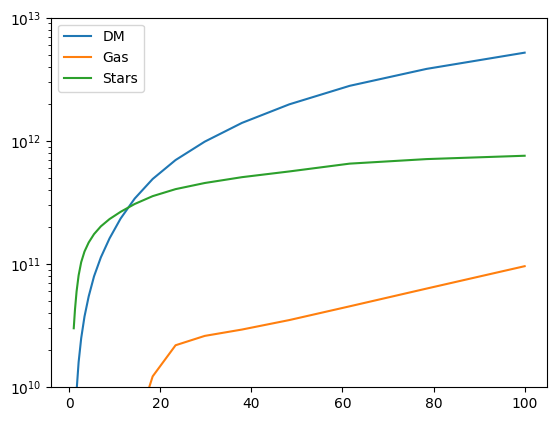

In [104]:
plt.plot(data['SubID_125027/R_bins'][()], data['SubID_125027/M_DM'][()], label = 'DM' )
plt.plot(data['SubID_125027/R_bins'][()], data['SubID_125027/M_gas'][()], label = 'Gas' )
plt.plot(data['SubID_125027/R_bins'][()], data['SubID_125027/M_stars'][()], label = 'Stars' )
plt.yscale('log')
plt.legend()
plt.ylim(1e10, 1e13)

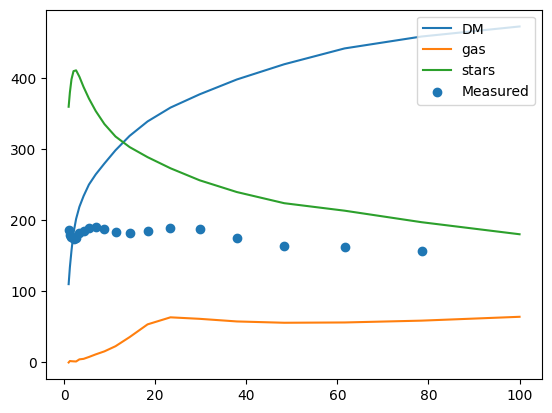

In [73]:
plt.plot(data['SubID_125027/R_bins'][()], np.sqrt(G * data['SubID_125027/M_DM'][()] / data['SubID_125027/R_bins'][()]), label = 'DM' )
plt.plot(data['SubID_125027/R_bins'][()], np.sqrt(G * data['SubID_125027/M_gas'][()] / data['SubID_125027/R_bins'][()]), label = 'gas' )
plt.plot(data['SubID_125027/R_bins'][()], np.sqrt(G * data['SubID_125027/M_stars'][()] / data['SubID_125027/R_bins'][()]), label = 'stars' )
plt.scatter(data['SubID_125027/R_bins'][()][:-1], data['SubID_125027/V_rot_stars_AM'][()], label = 'Measured')
plt.legend()

In [98]:
gal0 = np.load('../data/TNGgalaxies/137885/SDSS_Z_d_20.0_theta_1.57.npy')

(array([  333.,     0.,    95., 14636.,   972.,     0.,     0.,    23.,
          256.,    69.]),
 array([-15.        , -11.30196048,  -7.60392095,  -3.90588143,
         -0.2078419 ,   3.49019762,   7.18823715,  10.88627667,
         14.58431619,  18.28235572,  21.98039524]),
 <BarContainer object of 10 artists>)

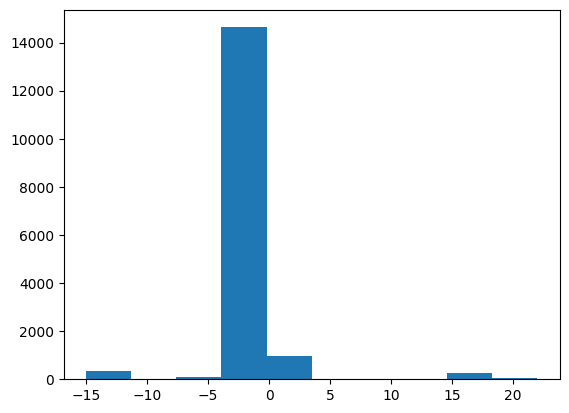

In [99]:
plt.hist(np.log10(gal0.flatten() + 1e-15))

/tmp/ipykernel_295978/305602038.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(gal0))


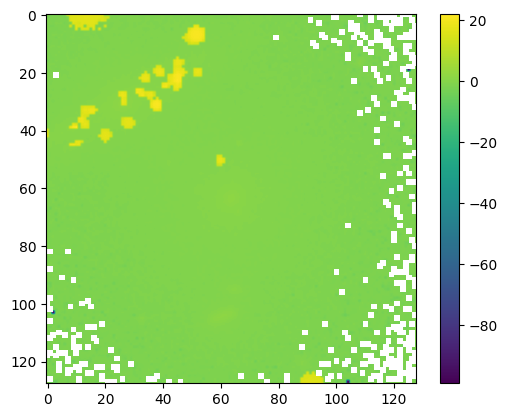

In [102]:
plt.imshow(np.log10(gal0))
plt.colorbar()


In [81]:
gal = np.load('../data/TNGgalaxies/154493/SDSS_Z_d_20.0_theta_0.79.npy')

(array([4.430e+02, 0.000e+00, 8.000e+00, 5.905e+03, 9.739e+03, 0.000e+00,
        0.000e+00, 1.000e+00, 4.700e+01, 2.410e+02]),
 array([-15.        , -11.62493367,  -8.24986734,  -4.87480101,
         -1.49973468,   1.87533165,   5.25039798,   8.62546431,
         12.00053064,  15.37559698,  18.75066331]),
 <BarContainer object of 10 artists>)

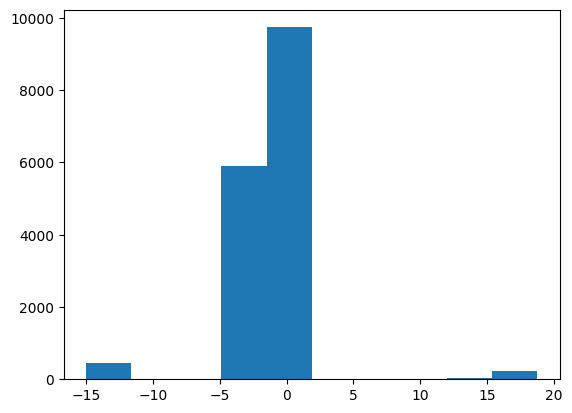

In [96]:
plt.hist(np.log10(gal.flatten() + 1e-15))

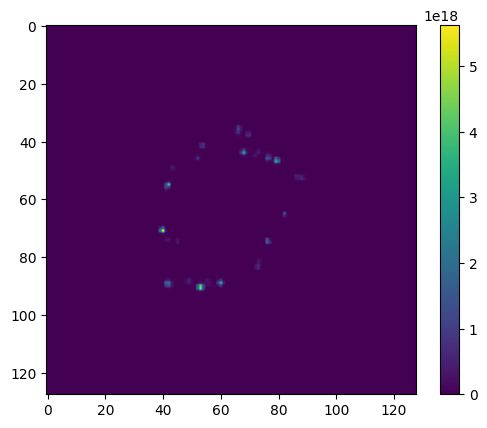

In [88]:
plt.imshow(gal)
plt.colorbar()

In [83]:
gal1 = np.load('../data/TNGgalaxies/154493/SDSS_Z_d_20.0_theta_0.79.npy')

(array([5.9200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.0000e+00, 2.8100e+02, 2.5340e+03, 1.2504e+04, 4.6700e+02]),
 array([-15.        , -13.35807086, -11.71614173, -10.07421259,
         -8.43228345,  -6.79035432,  -5.14842518,  -3.50649604,
         -1.86456691,  -0.22263777,   1.41929137]),
 <BarContainer object of 10 artists>)

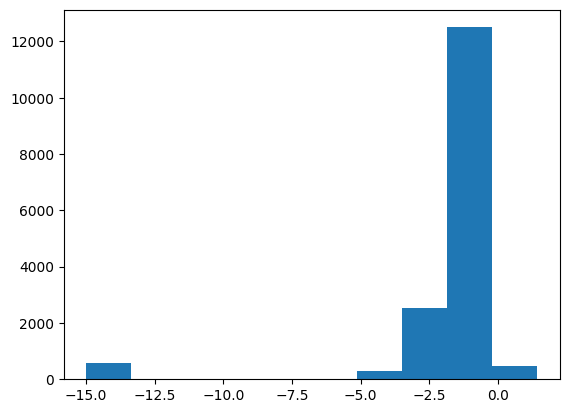

In [97]:
plt.hist(np.log10(gal1.flatten() + 1e-15))


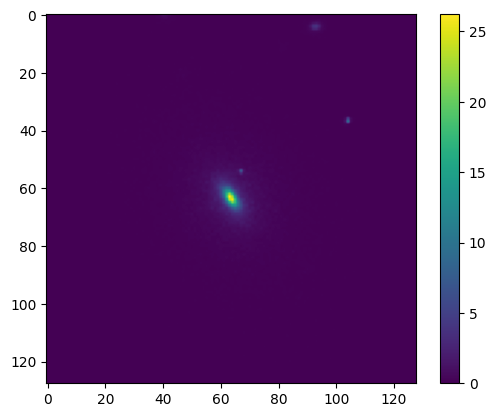

In [89]:
plt.imshow(gal1)
plt.colorbar()

In [56]:
data['SubID_154493/Props'][()][15]

0.3241575681402818

In [36]:
data.close()

In [33]:
data['SubID_121863']['M_DM'][()]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

/tmp/ipykernel_3564755/2896521005.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(pr), cmap = 'Grays', vmin = 1e-23,vmax = 10)


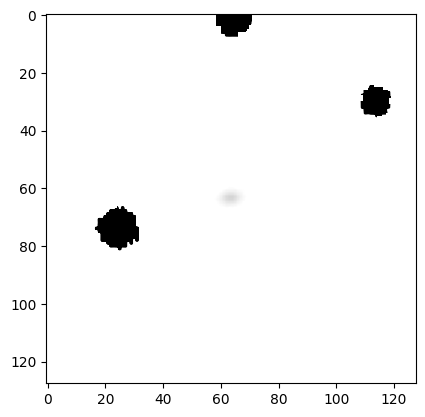

In [183]:
pr = np.load('../data/TNGgalaxies/121863_seq/SDSS_G_d_10.0_theta_0.00.npy')
plt.imshow(np.log(pr), cmap = 'Grays', vmin = 1e-23,vmax = 10)

In [178]:
from pts.visual.rgbimage import RGBImage
import astropy.units as u

In [179]:
pr_ast = np.stack((pr, pr, pr), axis=-1)

In [180]:
#pr = np.load('../data/TNGgalaxies/114388/HIMom1_d_10.0_theta_0.00.npy')
pr_ast = pr_ast * u.Unit('MJy/sr')

In [181]:
image = RGBImage(pr_ast.value)
fmin = 1e-5 * u.MJy/u.sr
fmax = 1e3 * u.MJy/u.sr
image.setRange(fmin.value, fmax.value)
image.applyLog()     # Aplicar transformación logarítmica
image.applyCurve()   # Aplicar curva de color
#image.saveTo('../data/TNGgalaxies/114388/pr.png')

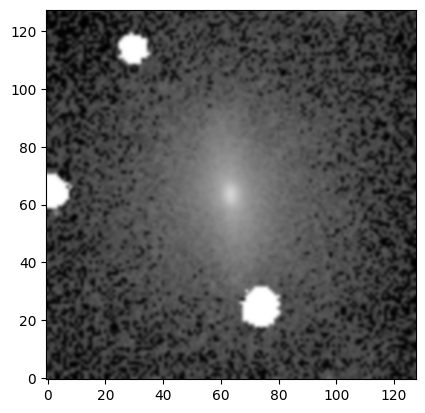

In [182]:
image.plot()

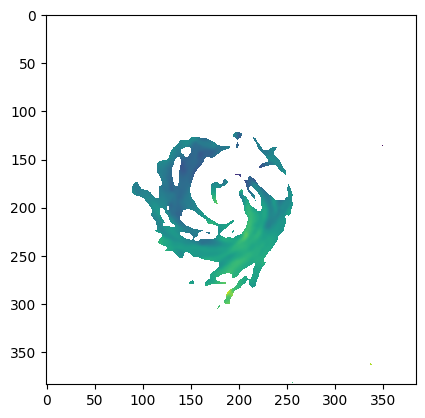

In [69]:
pr = np.load('../data/TNGgalaxies/114388/HIMom1_d_10.0_theta_0.00.npy')
plt.imshow(pr*mask)

# Post processing

In [17]:
data = h5py.File('../data/TNGgalaxies/test.h5','r')

In [20]:
len(list(data.keys()))

2972

In [21]:
list(data.keys())[-10:]

['SubID_609986',
 'SubID_610606',
 'SubID_611399',
 'SubID_613788',
 'SubID_615762',
 'SubID_621820',
 'SubID_623290',
 'SubID_623331',
 'SubID_633114',
 'SubID_76086']

In [72]:
data.close()

In [66]:
ngals = len(data.keys())
npix = 128
nch = 8
nbins = 20
nrots = 1
nprops = 20
nobs = ngals * nrots

In [67]:
images = np.zeros((nobs, nch, npix, npix))
labels = np.zeros((nobs, 3, nbins))
properties = np.zeros((nobs, nprops))

In [68]:
cimg = 0 # observation counter
for i in tqdm(range(ngals)):
    ID = list(data.keys())[i]
    if data[ID].attrs['done']: # Only look for subhalos that were done
        folder = '/scratch/mdelosri/MaDaMe/TNGgalaxies/' + ID[6:]
        for irot in range(nrots):
            if data[ID].attrs['flags'][irot] == 1: # Only look for images that were done
                D = data[ID].attrs['dists'][irot]
                theta = data[ID].attrs['thetas'][irot]
            
                # Let's load the images
                images[cimg,0,:,:] = np.load(folder + '/SDSS_U_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta))
                images[cimg,1,:,:] = np.load(folder + '/SDSS_G_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta))
                images[cimg,2,:,:] = np.load(folder + '/SDSS_R_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta))
                images[cimg,3,:,:] = np.load(folder + '/SDSS_I_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta))
                images[cimg,4,:,:] = np.load(folder + '/SDSS_Z_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta))
                images[cimg,5,:,:] = np.load(folder + '/HIMom0_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta))
                images[cimg,6,:,:] = np.load(folder + '/HIMom1_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta))
                images[cimg,7,:,:] = np.load(folder + '/HIMom2_d_{:.1f}_theta_{:.2f}.npy'.format(D, theta))
            
                # Let's load the labels
                labels[cimg, 0, :] = data[ID + '/M_DM']
                labels[cimg, 1, :] = data[ID + '/M_stars']
                labels[cimg, 2, :] = data[ID + '/M_gas']
            
                # Let's load the properties
                properties[cimg,:17] = data[ID + '/Props'][()]
                properties[cimg, 17] = D
                properties[cimg, 18] = theta
                properties[cimg, 19] = data[ID].attrs['flags'][irot]
                cimg += 1

100%|██████████| 2972/2972 [00:10<00:00, 289.88it/s]


In [69]:
# Delete 0's in the arrays
images = np.delete(images, np.where(properties[:,0] == 0)[0], axis = 0)
labels = np.delete(labels, np.where(properties[:,0] == 0)[0], axis = 0)
properties = np.delete(properties, np.where(properties[:,0] == 0)[0], axis = 0)

In [70]:
images.shape

(2972, 8, 128, 128)

In [71]:
np.save('/scratch/mdelosri/MaDaMe/TNGgalaxies/images.npy', images)
np.save('/scratch/mdelosri/MaDaMe/TNGgalaxies/labels.npy', labels)
np.save('/scratch/mdelosri/MaDaMe/TNGgalaxies/properties.npy', properties)

In [18]:
images = np.load('../data/TNGgalaxies/images.npy')
properties = np.load('../data/TNGgalaxies/properties.npy')
labels = np.load('../data/TNGgalaxies/labels.npy')

Text(0.5, 0, '$\\kappa$')

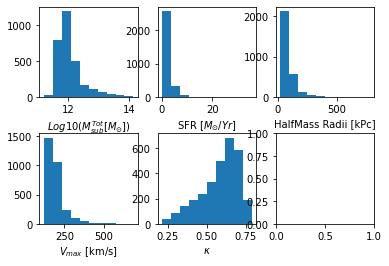

In [24]:
fig,ax = plt.subplots(2,3)

plt.subplots_adjust(hspace = 0.4)

ax[0,0].hist(np.log10(properties[:,2]))
ax[0,0].set_xlabel('$Log10(M_{sub}^{Tot} [M_{\odot}$])')

ax[0,1].hist(properties[:,3])
ax[0,1].set_xlabel('SFR [$M_{\odot} / Yr$]')

ax[0,2].hist(properties[:,4])
ax[0,2].set_xlabel('HalfMass Radii [kPc]')

ax[1,0].hist(properties[:,11])
ax[1,0].set_xlabel('$V_{max}$ [km/s]')

ax[1,1].hist(properties[:,15])
ax[1,1].set_xlabel('$\\kappa$')

In [19]:
R_bins

array([  1.        ,   1.27427499,   1.62377674,   2.06913808,
         2.6366509 ,   3.35981829,   4.2813324 ,   5.45559478,
         6.95192796,   8.8586679 ,  11.28837892,  14.38449888,
        18.32980711,  23.35721469,  29.76351442,  37.92690191,
        48.32930239,  61.58482111,  78.47599704, 100.        ])

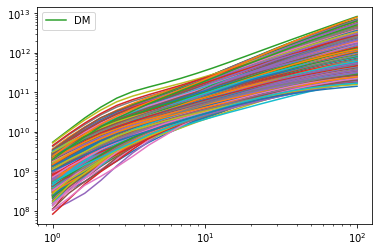

In [33]:
for i in range(len(labels)):
    plt.plot(R_bins,labels[i,0,:])
    #plt.plot(labels[i,1,:])
    #plt.plot(labels[i,2,:])
plt.yscale('log')
plt.xscale('log')
plt.plot(R_bins,labels[0,0,:],label='DM')
#plt.plot(labels[0,1,:],label='star')
#plt.plot(labels[0,2,:],label='gas')
plt.legend()

In [20]:
def NFW_mass(r, M200, c200):
    """
    Calcula la masa acumulada para un perfil NFW
    
    Parámetros:
    -----------
    r : array
        Radio en kpc
    M200 : float 
        Masa total del halo en Msun
    c200 : float
        Parámetro de concentración
        
    Retorna:
    --------
    M : array
        Masa acumulada en Msun
    """
    # Constantes
    G = 4.302e-6  # kpc (km/s)^2 Msun^-1
    H = 67.74     # km/s/Mpc
    rho_crit = 3 * H**2 / (8 * np.pi * G) * 1e-6  # Msun/kpc^3
    
    # Radio característico
    r200 = (3 * M200 / (4 * np.pi * 200 * rho_crit))**(1/3)
    rs = r200 / c200
    
    # Función g(c)
    gc = np.log(1 + c200) - c200/(1 + c200)
    
    return M200 * (np.log(1 + r/rs) - (r/rs)/(1 + r/rs)) / gc

# Función para ajustar
def fit_NFW(r, mass):
    """
    Ajusta un perfil NFW a los datos
    
    Parámetros:
    -----------
    r : array
        Radio en kpc
    mass : array
        Masa acumulada en Msun
        
    Retorna:
    --------
    M200 : float
        Masa total del halo en Msun
    c200 : float 
        Parámetro de concentración
    """
    # Eliminar valores nulos o negativos
    mask = (mass > 0)
    r = r[mask]
    mass = mass[mask]
    
    # Función a minimizar
    def chi2(params):
        M200, c200 = params
        model = NFW_mass(r, M200, c200)
        return np.sum((np.log10(mass) - np.log10(model))**2)
    
    # Valores iniciales
    M200_init = np.max(mass) * 1.5
    c200_init = 10
    
    # Ajuste
    from scipy.optimize import minimize
    result = minimize(chi2, [M200_init, c200_init], 
                     bounds=[(1e10, 1e15), (1, 100)])
    
    return result.x


In [23]:
results = np.zeros((len(labels), 3))
plot = False
# Ejemplo de uso:
for i in tqdm(range(len(labels))):
    # Obtener datos
    r = R_bins
    mass = labels[i,0,:]
    
    # Ajustar NFW
    M200, c200 = fit_NFW(r, mass)
    results[i,0] = M200
    results[i,1] = c200
    results[i,2] = np.sum((np.log10(mass) - np.log10(NFW_mass(r, M200, c200)))**2)
    
    # Graficar
    if plot:
        plt.figure()
        plt.plot(r, mass, 'o', label='Datos')
        plt.plot(r, NFW_mass(r, M200, c200), '-', label='NFW')
        plt.xscale('log')
        plt.yscale('log') 
        plt.xlabel('r [kpc]')
        plt.ylabel('M(<r) [Msun]')
        plt.title(f'M200={M200:.2e} Msun, c200={c200:.1f}')
        plt.legend()

  0%|          | 0/2972 [00:00<?, ?it/s]

100%|██████████| 2972/2972 [00:05<00:00, 500.96it/s]


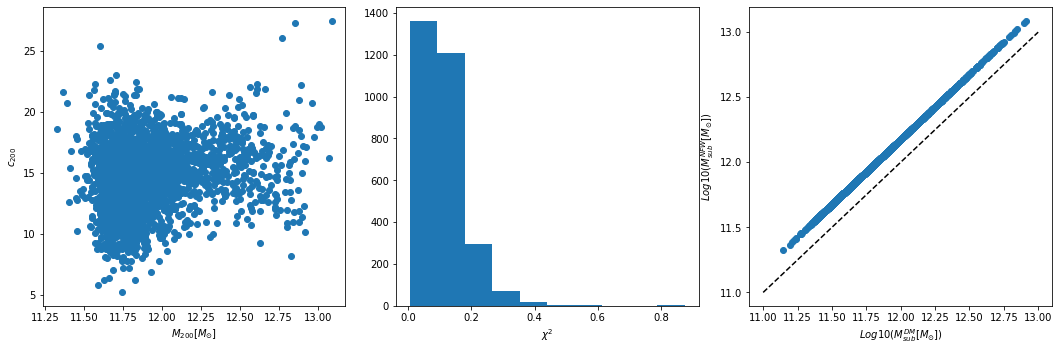

In [39]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(15, 5)
fig.tight_layout(pad=2.0)

ax[0].scatter(np.log10(results[:,0]), results[:,1])
ax[0].set_xlabel('$M_{200} [M_{\odot}]$')
ax[0].set_ylabel('$c_{200}$')
ax[1].hist(results[:,2])
ax[1].set_xlabel('$\chi^2$')

ax[2].scatter(np.log10(labels[:,0,19]), np.log10(results[:,0]))
ax[2].set_xlabel('$Log10(M_{sub}^{DM} [M_{\odot}$])')
ax[2].set_ylabel('$Log10(M_{sub}^{NFW} [M_{\odot}$])')
ax[2].plot([11,13], [11,13], 'k--')


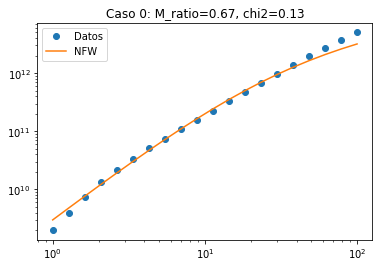

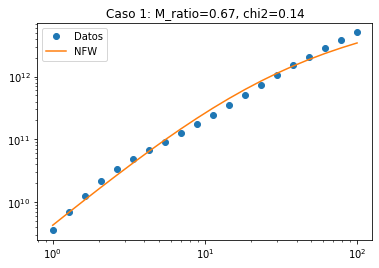

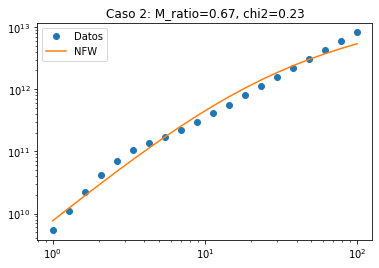

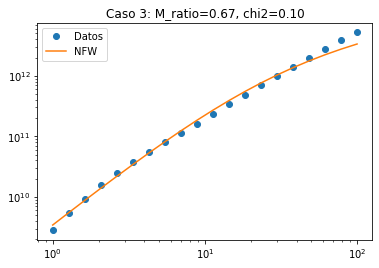

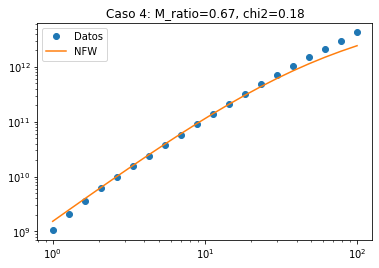

In [43]:
# 3. Ver algunos ajustes individuales
for i in range(5):  # Mostrar primeros 5 casos
    plt.figure()
    plt.plot(R_bins, labels[i,0,:], 'o', label='Datos')
    plt.plot(R_bins, NFW_mass(R_bins, results[i,0], results[i,1]), '-', label='NFW')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Caso {i}: M_ratio={ratio[i]:.2f}, chi2={results[i,2]:.2f}')
    plt.legend()

In [44]:
def mass_to_density(r, mass):
    """
    Convierte masa acumulada a densidad
    
    Parámetros:
    -----------
    r : array
        Radio en kpc
    mass : array
        Masa acumulada en Msun
        
    Retorna:
    --------
    rho_mean : array
        Densidad media en Msun/kpc³
    rho_local : array
        Densidad local en Msun/kpc³
    """
    # Densidad media
    volume = 4/3 * np.pi * r**3
    rho_mean = mass / volume
    
    # Densidad local (usando diferencias finitas)
    dr = np.diff(r)
    dM = np.diff(mass)
    r_mid = (r[1:] + r[:-1])/2
    rho_local = dM / (4 * np.pi * r_mid**2 * dr)
    
    return rho_mean, rho_local


In [45]:
def NFW_density(r, M200, c200):
    """Densidad local para un perfil NFW"""
    G = 4.302e-6
    H = 67.74
    rho_crit = 3 * H**2 / (8 * np.pi * G) * 1e-6
    
    r200 = (3 * M200 / (4 * np.pi * 200 * rho_crit))**(1/3)
    rs = r200 / c200
    
    rho_s = M200 / (4 * np.pi * rs**3 * (np.log(1 + c200) - c200/(1 + c200)))
    
    return rho_s / ((r/rs) * (1 + r/rs)**2)

<Figure size 432x288 with 0 Axes>

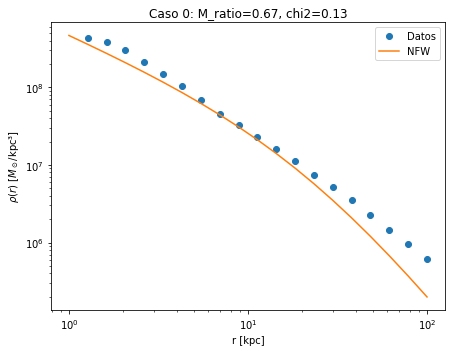

<Figure size 432x288 with 0 Axes>

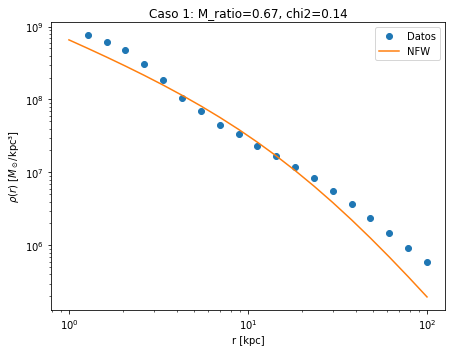

<Figure size 432x288 with 0 Axes>

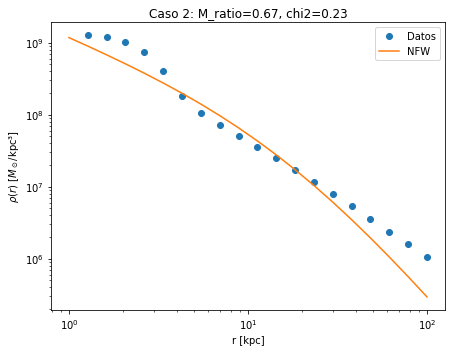

<Figure size 432x288 with 0 Axes>

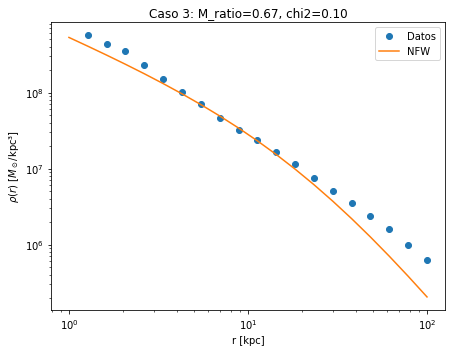

<Figure size 432x288 with 0 Axes>

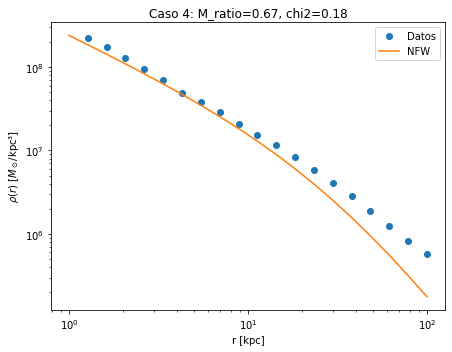

In [49]:
for i in range(5):  # Mostrar primeros 5 casos
    plt.figure()
    # Ejemplo de uso:
    plt.figure(figsize=(12,5))

    # Para los datos observados
    r = R_bins
    mass = labels[i,0,:] # Tomando la primera galaxia como ejemplo
    rho_mean, rho_local = mass_to_density(r, mass)

    # Para el perfil NFW ajustado
    rho_s = NFW_density(r, results[i,0], results[i,1])


    # Plotear densidad local
    plt.subplot(122)
    plt.plot(r[1:], rho_local, 'o', label='Datos')
    plt.plot(r, rho_s, '-', label='NFW')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('r [kpc]')
    plt.ylabel('$\\rho(r)$ [$M_\\odot$/kpc³]')
    plt.title(f'Caso {i}: M_ratio={ratio[i]:.2f}, chi2={results[i,2]:.2f}')
    plt.legend()

    plt.tight_layout()

Ratio promedio M_sub/M_NFW: 0.667
Desviación estándar: 0.000


Text(0, 0.5, 'Número')

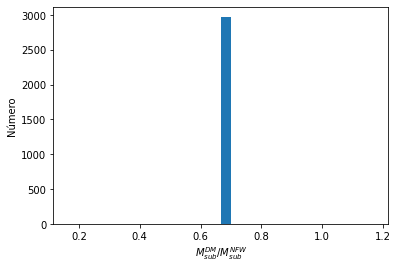

In [42]:
# Calcular el cociente entre M_sub y M_NFW
ratio = labels[:,0,19] / results[:,0]

# Mostrar estadísticas básicas
print(f"Ratio promedio M_sub/M_NFW: {np.mean(ratio):.3f}")
print(f"Desviación estándar: {np.std(ratio):.3f}")

# Graficar histograma del ratio
plt.figure()
plt.hist(ratio, bins=30)
plt.xlabel('$M_{sub}^{DM}/M_{sub}^{NFW}$')
plt.ylabel('Número')


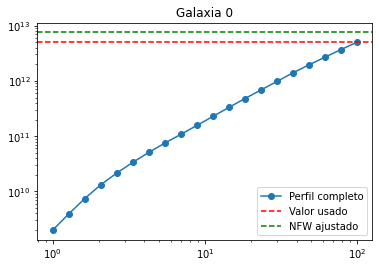

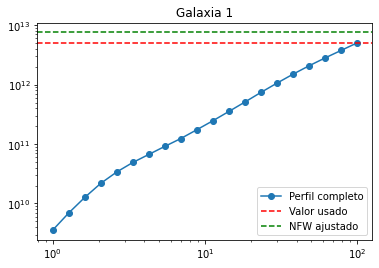

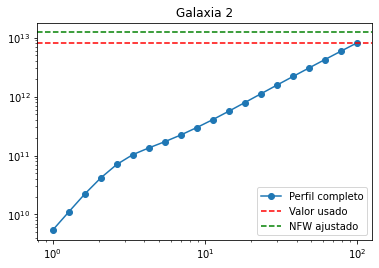

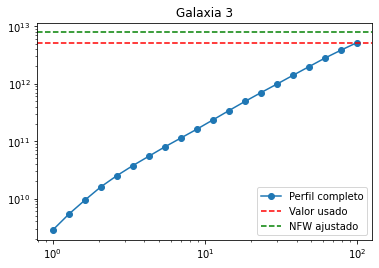

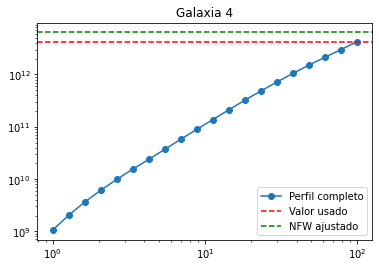

In [50]:
# Verificar los perfiles de masa completos
for i in range(5):
    plt.figure()
    plt.plot(R_bins, labels[i,0,:], 'o-', label='Perfil completo')
    plt.axhline(labels[i,0,19], color='r', linestyle='--', label='Valor usado')
    plt.axhline(results[i,0], color='g', linestyle='--', label='NFW ajustado')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.title(f'Galaxia {i}')

Text(0.5, 1.0, 'Perfiles de masa normalizados')

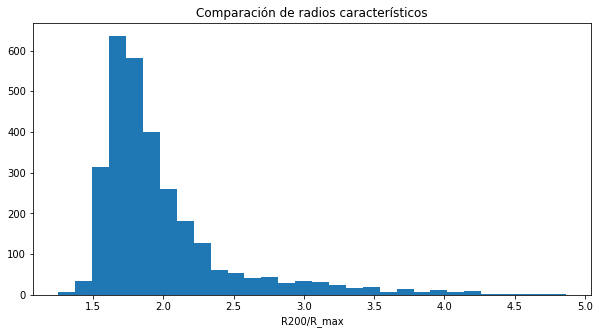

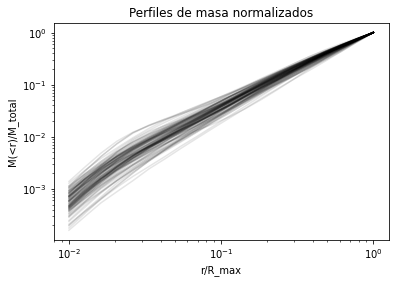

In [51]:
# 1. Verificar la relación entre radios
plt.figure(figsize=(10,5))

# Calcular R200 para cada halo
G = 4.302e-6
H = 67.74
rho_crit = 3 * H**2 / (8 * np.pi * G) * 1e-6
R200 = (3 * results[:,0] / (4 * np.pi * 200 * rho_crit))**(1/3)

# Comparar con el radio máximo de los datos
R_max = R_bins[-1]  # típicamente 100 kpc
plt.hist(R200/R_max, bins=30)
plt.xlabel('R200/R_max')
plt.title('Comparación de radios característicos')

# 2. Comparar perfiles normalizados
plt.figure()
for i in range(min(100, len(labels))):  # Primeros 100 halos
    mass_norm = labels[i,0,:]/labels[i,0,-1]  # Normalizar por masa total
    plt.plot(R_bins/R_bins[-1], mass_norm, 'k-', alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r/R_max')
plt.ylabel('M(<r)/M_total')
plt.title('Perfiles de masa normalizados')

In [35]:
list(data.keys())[-10:]

['SubID_609986',
 'SubID_610606',
 'SubID_611399',
 'SubID_613788',
 'SubID_615762',
 'SubID_621820',
 'SubID_623290',
 'SubID_623331',
 'SubID_633114',
 'SubID_76086']

In [36]:
data['SubID_623331/M_DM'][()]

<KeysViewHDF5 ['M_DM', 'M_DM_sub', 'M_DM_x', 'M_DM_y', 'M_DM_z', 'M_gas', 'M_gas_sub', 'M_stars', 'M_stars_sub', 'Props', 'R_bins', 'R_bins_sub', 'R_bins_vels', 'V_rot_gas_AM', 'V_rot_gas_IT', 'V_rot_stars_AM', 'V_rot_stars_IT', 'V_std_gas_AM', 'V_std_gas_IT', 'V_std_stars_AM', 'V_std_stars_IT']>

In [55]:
R_bins

array([  1.        ,   1.27427499,   1.62377674,   2.06913808,
         2.6366509 ,   3.35981829,   4.2813324 ,   5.45559478,
         6.95192796,   8.8586679 ,  11.28837892,  14.38449888,
        18.32980711,  23.35721469,  29.76351442,  37.92690191,
        48.32930239,  61.58482111,  78.47599704, 100.        ])

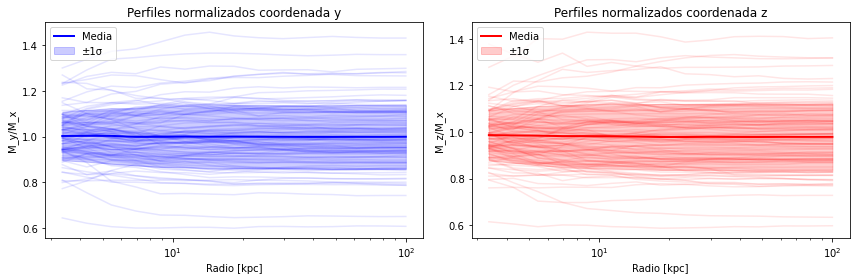

In [62]:
# Obtener las últimas 100 galaxias
last_100_gals = list(data.keys())[-100:]
# Crear figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Inicializar arrays para almacenar los ratios
y_ratios = np.zeros((len(last_100_gals), len(R_bins[5:])))
z_ratios = np.zeros((len(last_100_gals), len(R_bins[5:])))

# Calcular ratios para cada galaxia
for i, gal in enumerate(last_100_gals):
    if f'{gal}/M_DM_x' in data and f'{gal}/M_DM_y' in data and f'{gal}/M_DM_z' in data:
        y_ratios[i] = data[f'{gal}/M_DM_y'][()][5:] / data[f'{gal}/M_DM_x'][()][5:]
        z_ratios[i] = data[f'{gal}/M_DM_z'][()][5:] / data[f'{gal}/M_DM_x'][()][5:]

# Calcular medias por bin radial
y_mean = np.nanmean(y_ratios, axis=0)
z_mean = np.nanmean(z_ratios, axis=0)

# Plotear las medias con líneas más gruesas
ax1.plot(R_bins[5:], y_mean, 'b-', linewidth=2, label='Media')
ax2.plot(R_bins[5:], z_mean, 'r-', linewidth=2, label='Media')

# Calcular desviación estándar por bin radial
y_std = np.nanstd(y_ratios, axis=0)
z_std = np.nanstd(z_ratios, axis=0)

# Plotear bandas de dispersión (media ± 1 std)
ax1.fill_between(R_bins[5:], y_mean - y_std, y_mean + y_std, color='b', alpha=0.2, label='±1σ')
ax2.fill_between(R_bins[5:], z_mean - z_std, z_mean + z_std, color='r', alpha=0.2, label='±1σ')

ax1.legend()
ax2.legend()


# Plot para coordenada y
for gal in last_100_gals:
    if f'{gal}/M_DM_x' in data and f'{gal}/M_DM_y' in data:
        ax1.plot(R_bins[5:], data[f'{gal}/M_DM_y'][()][5:] / data[f'{gal}/M_DM_x'][()][5:], 'b-', alpha=0.1)
ax1.set_xscale('log')
ax1.set_xlabel('Radio [kpc]')
ax1.set_ylabel('M_y/M_x')
ax1.set_title('Perfiles normalizados coordenada y')

# Plot para coordenada z
for gal in last_100_gals:
    if f'{gal}/M_DM_x' in data and f'{gal}/M_DM_z' in data:
        ax2.plot(R_bins[5:], data[f'{gal}/M_DM_z'][()][5:] / data[f'{gal}/M_DM_x'][()][5:], 'r-', alpha=0.1)
ax2.set_xscale('log')
ax2.set_xlabel('Radio [kpc]')
ax2.set_ylabel('M_z/M_x') 
ax2.set_title('Perfiles normalizados coordenada z')

plt.tight_layout()



In [ ]:

plt.figure(figsize=(6,4))
for gal in last_100_gals:
    # Normalizar por el perfil en x
    if f'{gal}/M_DM_x' in data and f'{gal}/M_DM_y' in data and f'{gal}/M_DM_z' in data:
        plt.plot(R_bins[5:], data[f'{gal}/M_DM_y'][()][5:] / data[f'{gal}/M_DM_x'][()][5:], 'b-', alpha=0.1, label='y' if gal==last_100_gals[0] else "")
        plt.plot(R_bins[5:], data[f'{gal}/M_DM_z'][()][5:] / data[f'{gal}/M_DM_x'][()][5:], 'r-', alpha=0.1, label='z' if gal==last_100_gals[0] else "")

plt.xscale('log')
plt.xlabel('Radio [kpc]')
plt.ylabel('Razón de perfiles')
plt.title('Perfiles normalizados últimas 100 galaxias')

#plt.plot(R_bins[5:], data['SubID_613788/M_DM_y'][()][5:] /  data['SubID_613788/M_DM_x'][()][5:], label = 'y')
#plt.plot(R_bins[5:], data['SubID_613788/M_DM_z'][()][5:] /  data['SubID_613788/M_DM_x'][()][5:], label = 'z')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()